In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import sys
%matplotlib inline

In [3]:
# # Arrays to store object points and image points from all the images.
# objpoints = [] # 3d points in real world space
# imgpoints = [] # 2d points in image plane.

# #prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# objp = np.zeros((6*9,3), np.float32)
# objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [4]:
ret, mtx, dist, rvects, tvects = None, None, None, None, None

def calibrate_camera(path):
    images = glob.glob(path)

    cb_shape = (9, 6)  # Corners we expect to be detected on the chessboard

    objpoints = []  # 3D points in real-world space
    imgpoints = []  # 2D points in the image

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)

        obj_p = np.zeros((cb_shape[0]*cb_shape[1], 3), np.float32)
        coords = np.mgrid[0:cb_shape[0], 0:cb_shape[1]].T.reshape(-1, 2)  # x, y coords

        obj_p[:,:2] = coords

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        status, corners = cv2.findChessboardCorners(gray, cb_shape, None)
        if status:
            objpoints.append(obj_p)
            imgpoints.append(corners)
            img = cv2.drawChessboardCorners(img, cb_shape, corners, status)
        else:
            print("Couldn't find all corners in image:", fname)
    
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape, None, None)
    
ret, mtx, dist, rvects, tvects = calibrate_camera('../camera_cal/calibration*.jpg')
print(ret, mtx)
print(dist)


Couldn't find all corners in image: ../camera_cal/calibration1.jpg
Couldn't find all corners in image: ../camera_cal/calibration4.jpg
Couldn't find all corners in image: ../camera_cal/calibration5.jpg
1.1868973603151152 [[  1.15396100e+03   0.00000000e+00   6.69706490e+02]
 [  0.00000000e+00   1.14802504e+03   3.85655584e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
[[ -2.41018756e-01  -5.30666106e-02  -1.15811356e-03  -1.28285248e-04
    2.67027151e-02]]


In [5]:
def side_by_side_plot(im1, im2, im1_title=None, im2_title=None, im1_gray=False, im2_gray=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    if im1_gray:
        ax1.imshow(im1, cmap="gray")
    else:
        ax1.imshow(im1)
        
    if im1_title: ax1.set_title(im1_title, fontsize=30)
    if im2_gray:
        ax2.imshow(im2, cmap="gray")
    else:
        ax2.imshow(im2)
        
    if im2_title: ax2.set_title(im2_title, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

def big_plot(img):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(img)

In [6]:
# Undistort a image
def undistort(img, mtx, dist):
    try:
        undist = cv2.undistort(img, mtx, dist, None, mtx)
    except Exception as e:
        print(e)
        sys.exit(1)
    return undist

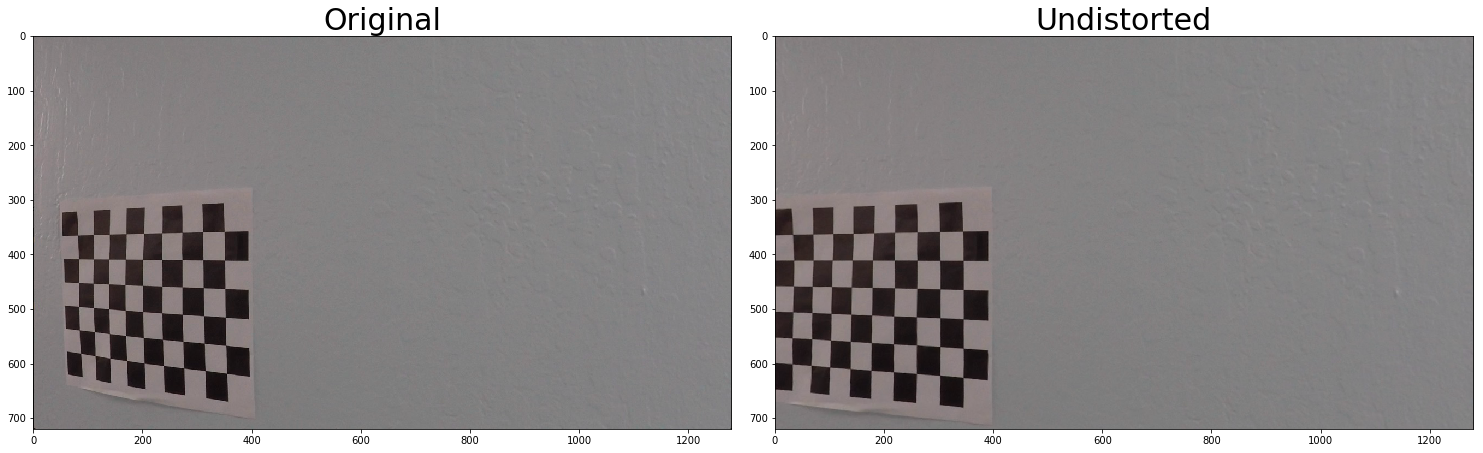

In [7]:
# validate the undistortion
img = cv2.imread('../camera_cal/calibration20.jpg')
undistorted = undistort(img, mtx, dist)
#cv2.imwrite('./example_images/undistorted_checkerboard.jpg', undistorted)
side_by_side_plot(img, undistorted, 'Original', 'Undistorted')

In [8]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255, kernel=5):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == "x":
        xdir, ydir = 1, 0
    else:
        xdir, ydir = 0, 1
    sobel = cv2.Sobel(gray, cv2.CV_64F, xdir, ydir, ksize=kernel)
    # 3) Take the absolute value of the derivative or gradient
    sobel_abs = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_factor = np.max(sobel_abs)/255 
    scaled_sobel = (sobel_abs/scale_factor).astype(np.uint8) 
#     scaled_sobel = np.uint8(255*sobel_abs/np.max(sobel_abs))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    # binary_output = np.copy(img) # Remove this line
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hsl_threshold(img, select, thresh=(0, 255)):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)   # ??? RGB or BGR 
    if select == "s":
        channel = hls[:,:,2]
    elif select == "l":
        channel = hls[:,:,1]
    else:
        channel = hls[:,:,0]
        
    # Threshold color channel
    thresh_min = thresh[0] #170
    thresh_max = thresh[1] #255
    binary = np.zeros_like(channel)
    binary[(channel >= thresh_min) & (channel <= thresh_max)] = 1
    
    return binary

def rg_threshold(img, select, thresh=(200, 255)):
#     print(img.shape)
    if select == "r":
        channel = img[:,:,0]
    elif select == "g":
        channel = img[:,:,1]
    else:
        channel = img[:,:,2]
    # Threshold color channel
    thresh_min = thresh[0] #170
    thresh_max = thresh[1] #255
    binary = np.zeros_like(channel)
    binary[(channel >= thresh_min) & (channel <= thresh_max)] = 1
    
    return binary

def apply_thresholds_v2(undistorted_image, draw=False):
    grad_binary_x = abs_sobel_thresh(undistorted_image, orient='x', thresh_min=10, thresh_max=200)
#     side_by_side_plot(undistorted_image, grad_binary_x, 'undistorted_image ' + fname, 'Grad x')
    grad_dir = dir_threshold(undistorted_image, sobel_kernel=15, thresh=(np.pi/6, np.pi/2))
#     side_by_side_plot(undistorted_image, grad_dir, 'undistorted_image ' + fname, 'Grad dir')
    combined_condition = np.zeros_like(grad_binary_x)
    combined_condition [(grad_binary_x == 1) & (grad_dir == 1)] = 1
#     side_by_side_plot(undistorted_image, combined_condition, 'undistorted_image ' + fname, 'combined_condition')
    sm_image = hsl_threshold(undistorted_image, "s", (100, 255))
#     side_by_side_plot(undistorted_image, sm_image, 'undistorted_image ' + fname, 'S threshold')
    l_thresh = (120, 255)
    lm_image = hsl_threshold(undistorted_image, "l", (120, 255))
#     side_by_side_plot(undistorted_image, lm_image, 'undistorted_image ' + fname, 'lm threshold')
    r_image = rg_threshold(undistorted_image, "r", (150, 255))
#     side_by_side_plot(undistorted_image, r_image, 'undistorted_image ' + fname, 'R threshold for white')
    g_image = rg_threshold(undistorted_image, "g", (150, 255))
#     side_by_side_plot(undistorted_image, g_image, 'undistorted_image ' + fname, 'G threshold for white')
    r_g_condition = (r_image & g_image)
#     side_by_side_plot(undistorted_image, r_g_condition, 'undistorted_image ' + fname, 'r_g_condition')
    color_combined1 = np.zeros_like(grad_binary_x)
    color_combined1 [(sm_image == 1) | (combined_condition == 1)] = 1
#     side_by_side_plot(undistorted_image, color_combined1, 'undistorted_image ' + fname, 'color_combined1')
    color_combined2 = np.zeros_like(grad_binary_x)
    color_combined2 [(lm_image == 1) & (r_g_condition == 1)] = 1
#     side_by_side_plot(undistorted_image, color_combined2, 'undistorted_image ' + fname, 'color_combined2')
    color_combined3 = np.zeros_like(grad_binary_x)
    color_combined3 [(color_combined1 == 1) & (color_combined2 == 1)] = 1
#     side_by_side_plot(undistorted_image, color_combined3, 'undistorted_image ' + fname, 'color_combined3')
    
    if draw:
        side_by_side_plot(undistorted_image, grad_binary_x, 'undistorted_image ' + fname, 'Grad x')

        side_by_side_plot(undistorted_image, grad_dir, 'undistorted_image ' + fname, 'Grad dir')

        side_by_side_plot(undistorted_image, combined_condition, 'undistorted_image ' + fname, 'combined_condition')

        side_by_side_plot(undistorted_image, sm_image, 'undistorted_image ' + fname, 'S threshold')

        side_by_side_plot(undistorted_image, lm_image, 'undistorted_image ' + fname, 'lm threshold')

        side_by_side_plot(undistorted_image, r_image, 'undistorted_image ' + fname, 'R threshold for white')

        side_by_side_plot(undistorted_image, g_image, 'undistorted_image ' + fname, 'G threshold for white')

        side_by_side_plot(undistorted_image, r_g_condition, 'undistorted_image ' + fname, 'r_g_condition')

        side_by_side_plot(undistorted_image, color_combined1, 'undistorted_image ' + fname, 'color_combined1')

        side_by_side_plot(undistorted_image, color_combined2, 'undistorted_image ' + fname, 'color_combined2')

        side_by_side_plot(undistorted_image, color_combined3, 'undistorted_image ' + fname, 'color_combined3')

    
    return color_combined3


def apply_thresholds_v1(image, show=True):
#     img, M = birds_eye(image, display = False)
    img = image

    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    s_thresh_min = 180
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #color_binary = np.dstack((u_binary, s_binary, l_binary))
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

#     if show == True:
#         # Plotting thresholded images
#         f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
#         f.tight_layout()
        
#         ax1.set_title('Original Image', fontsize=16)
#         ax1.imshow(image)
        
#         ax2.set_title('Warped Image', fontsize=16)
#         ax2.imshow(img)
        
#         ax3.set_title('s binary threshold', fontsize=16)
#         ax3.imshow(s_binary, cmap='gray')
        
#         ax4.set_title('b binary threshold', fontsize=16)
#         ax4.imshow(b_binary, cmap='gray')
        
#         ax5.set_title('l binary threshold', fontsize=16)
#         ax5.imshow(l_binary, cmap='gray')

#         ax6.set_title('Combined color thresholds', fontsize=16)
#         ax6.imshow(combined_binary, cmap='gray')
        
        
#     else: 
    return combined_binary

In [9]:
class placeholder(object):
    def __init__(self, M, Minv, mtx, dist, leftx, lefty, rightx, righty, leftcm, rightcm, left_fitx, right_fitx):
        """Return a Customer object whose name is *name* and starting
        balance is *balance*."""
        self.M = M         # warp matrix
        self.Minv = Minv   # unwarp matrix
        self.mtx = mtx     # camera calibration mtx
        self.dist = dist   # came calibration distortion
        self.prev_leftx = leftx
        self.prev_lefty = lefty
        self.prev_rightx = rightx
        self.prev_righty = righty
        self.prev_leftcm = leftcm  # left lane curvature
        self.prev_rightcm = rightcm # right lane curvature
        self.prev_left_fitx = left_fitx  # left lane curvature
        self.prev_right_fitx = right_fitx # right lane curvature
        



In [10]:
def findpeaks_v2(binary_warped, orig_img, draw=False):
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype(np.uint8)
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    if left_lane_inds is None:
        print("findpeaks_v2 left_lane_inds is None")
    right_lane_inds = np.concatenate(right_lane_inds)
    if left_lane_inds is None:
        print("findpeaks_v2 left_lane_inds is None")

    left_fitx, right_fitx = figure_out_line_predictions(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, binary_warped)
    
    return left_fitx, right_fitx
    
    
def figure_out_line_predictions(nonzerox, nonzeroy, left_lane_inds, right_lane_inds, binary_warped):
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    # If no pixels were found return None
    if(leftx.size == 0 or lefty.size == 0):
        return None, None
    
    left_fit = np.polyfit(lefty, leftx, 2)
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    if(rightx.size == 0 or righty.size == 0):
        return None, None
    
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx

def measure_radius_of_curvature(x_values, num_rows):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    ploty = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

def pipeline_v2(image, draw=False):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    if draw:
        fig = plt.figure(figsize=(60, 60))
    
    imshape = image.shape
    undistorted_image = undistort(image, placeme.mtx, placeme.dist)
    if draw:
        a = fig.add_subplot(7, 2, 1)
        a.set_title('original image', fontsize = 40)
        plt.imshow(image)
    if draw:
        a = fig.add_subplot(7, 2, 2)
        a.set_title('undistorted image', fontsize = 40)
        plt.imshow(undistorted_image)
#     grad_binary_x = abs_sobel_thresh(undistorted_image, orient='x', thresh_min=10, thresh_max=200)
#     if draw:
#         a = fig.add_subplot(7, 2, 1)
#         a.set_title('binary gradient along x', fontsize = 40)
#         plt.imshow(grad_binary_x)
#     s_image = s_threshold(undistorted_image, (100, 255))
#     if draw:
#         a = fig.add_subplot(7, 2, 2)
#         a.set_title('s image', fontsize = 40)
#         plt.imshow(s_image)
#     l_image = l_threshold(undistorted_image, (120, 255))
#     if draw:
#         a = fig.add_subplot(7, 2, 3)
#         a.set_title('l image', fontsize = 40)
#         plt.imshow(l_image)
#     r_image = rb_threshold(undistorted_image, "red", (150, 255))
#     if draw:
#         a = fig.add_subplot(7, 2, 4)
#         a.set_title('red image', fontsize = 40)
#         plt.imshow(r_image)
#     g_image = rb_threshold(undistorted_image, "green", (150, 255))
#     if draw:
#         a = fig.add_subplot(7, 2, 5)
#         a.set_title('green image', fontsize = 40)
#         plt.imshow(g_image)
#     rg_binary = np.zeros_like(r_image)
#     rg_binary[(g_image == 1) & (r_image == 1)] = 1
#     if draw:
#         a = fig.add_subplot(7, 2, 6)
#         a.set_title('rg binary', fontsize = 40)
#         plt.imshow(rg_binary)
#     rgl_binary = np.zeros_like(l_image)
#     rgl_binary[(rg_binary == 1) & (l_image == 1)] = 1
#     if draw:
#         a = fig.add_subplot(7, 2, 7)
#         a.set_title('rgl_binary', fontsize = 40)
#         plt.imshow(rgl_binary)
#     rgls_binary = np.zeros_like(s_image)
#     rgls_binary[(rgl_binary == 1) & (s_image == 1)] = 1
#     if draw:
#         a = fig.add_subplot(7, 2, 8)
#         a.set_title('rgls_binary', fontsize = 40)
#         plt.imshow(rgls_binary)
#     rglsx_binary = np.zeros_like(grad_binary_x)
#     rglsx_binary[(grad_binary_x == 1) | (rgls_binary == 1)] = 1
#     if draw:
#         a = fig.add_subplot(7, 2, 9)
#         a.set_title('rglsx_binary', fontsize = 40)
#         plt.imshow(rglsx_binary)
    
    rglsx_binary = apply_thresholds_v2(undistorted_image)
    if draw:
        a = fig.add_subplot(7, 2, 3)
        a.set_title('rglsx_binary', fontsize = 40)
        plt.imshow(rglsx_binary)
        
    # get region of interest
    vertices = np.array([[(0, imshape[0]), (550, 470), (730, 470), (1280,imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(rglsx_binary, vertices)
    if draw:
        a = fig.add_subplot(7, 2, 4)
        a.set_title('masked with region of interest', fontsize = 40)
        plt.imshow(masked_image)
        
    if placeme.M is None and placeme.Minv is None:
        src, dst = calculate_dst_for_perspective_transform(vertices, correction_factor=(40.0, -40.0, 40.0, -40.0))  #correction_factor=(-75.0, 20.0))
        M, Minv = calculate_perspective_matrix(src, dst)
        placeme.M = M
        placeme.Minv = Minv
    
    # warp it
    warped = cv2.warpPerspective(masked_image, placeme.M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    if draw:
        a = fig.add_subplot(7, 2, 5)
        a.set_title('warped image', fontsize = 40)
        plt.imshow(warped)
    warped_bin = np.zeros_like(warped[:,:])
    warped_bin[(warped[:,:] > 0)] = 1
    
    out_img = np.dstack((warped_bin, warped_bin, warped_bin))*255
    
    nonzero = warped_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    num_rows = warped_bin.shape[0]
    ploty = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a brute force search
        searchpeaks = True
        left_fitx, right_fitx = findpeaks_v2(warped_bin, image, draw)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        searchpeaks = False
        margin = 100
        left_fitx = polyfit_left[0]*nonzeroy**2 + polyfit_left[1]*nonzeroy + polyfit_left[2]
        left_lane_inds = ((nonzerox >= left_fitx - margin) & (nonzerox <= left_fitx + margin)).nonzero()[0]

        right_fitx = polyfit_right[0]*nonzeroy**2 + polyfit_right[1]*nonzeroy + polyfit_right[2]
        right_lane_inds = ((nonzerox >= right_fitx - margin) & (nonzerox <= right_fitx + margin)).nonzero()[0]
        
        left_fitx, right_fitx = figure_out_line_predictions(nonxerox, nonzeroy, left_lane_inds, right_lane_inds, binary_warped)
        
    if (left_fitx is None or right_fitx is None):
        if not searchpeaks:
            left_fitx, right_fitx = findpeaks_v2(warped_bin, image, draw)
            
    bad_lines = False
            
    if (left_fitx is None or right_fitx is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_fitx - left_fitx)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not searchpeaks:
                left_fitx, right_fitx = findpeaks_v2(warped_bin, image, draw)
                if (left_fitx is None or right_fitx is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_fitx - left_fitx)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return image
        else:
            left_fitx = past_good_left_lines[-1]
            right_fitx = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_fitx = get_averaged_line(past_good_left_lines, left_fitx)
        past_good_right_lines, right_fitx = get_averaged_line(past_good_right_lines, right_fitx)
        mean_difference = np.mean(right_fitx - left_fitx)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
        
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
#     left_curverad = ((1 + (2*left_fitx[0]*y_eval + left_fitx[1])**2)**1.5) / np.absolute(2*left_fitx[0])
#     right_curverad = ((1 + (2*right_fitx[0]*y_eval + right_fitx[1])**2)**1.5) / np.absolute(2*right_fitx[0])
#     print("left curvead right curvead in pixels: ", left_curverad, right_curverad)
    
#     # Define conversions in x and y from pixels space to meters
#     ym_per_pix = 30/720 # meters per pixel in y dimension
#     xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    

#     # Fit new polynomials to x,y in world space
#     left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
#     right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
#     # Calculate the new radii of curvature
#     left_curveadm = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
#     right_curveadm = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # compute the radius of curvature
    left_curveadm = measure_radius_of_curvature(left_fitx, num_rows)
    right_curveadm = measure_radius_of_curvature(right_fitx, num_rows)
    average_curve_radm = (left_curveadm + right_curveadm)/2
    # Now our radius of curvature is in meters
    print(left_curveadm, 'm', right_curveadm, 'm', average_curve_radm, 'm')
    
    midpoint = np.int(image.shape[1]/2)
    middle_of_lane = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    offset = abs(midpoint - middle_of_lane) * xm_per_pix
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(out_img, placeme.Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, unwarp, 0.3, 0)
    
    cv2.putText(result,"Avg Radius of curvature: " + "{:0.2f}".format(average_curve_radm/1000) + 'km', org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"C. Position from center: " + "{:0.2f}".format(offset) + 'm', org=(50,150), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    
    if draw:
        a = fig.add_subplot(7, 2, 6)
        a.set_title('image with lanes traced', fontsize = 40)
        plt.imshow(result)
    
    if draw:
        plt.show()
    
    return result


def get_averaged_line(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """
    
    # Number of frames to average over
    num_frames = 12
    
    if new_line is None:
        # No line was detected
        
        if len(previous_lines) == 0:
            # If there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_frames:
            # we need at least num_frames frames to average over
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # average over the last num_frames frames
            previous_lines[0:num_frames-1] = previous_lines[1:]
            previous_lines[num_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_frames):
                new_line += previous_lines[i]
            new_line /= num_frames
            return previous_lines, new_line

        
def pipeline_v3(image, draw=False):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    if draw:
        fig = plt.figure(figsize=(60, 60))
    
    imshape = image.shape
    undistorted_image = undistort(image, placeme.mtx, placeme.dist)
    if draw:
        a = fig.add_subplot(7, 2, 1)
        a.set_title('original image', fontsize = 40)
        plt.imshow(image)
    if draw:
        a = fig.add_subplot(7, 2, 2)
        a.set_title('undistorted image', fontsize = 40)
        plt.imshow(undistorted_image)  
        
    rglsx_binary = apply_thresholds_v2(undistorted_image)
    if draw:
        a = fig.add_subplot(7, 2, 3)
        a.set_title('rglsx_binary', fontsize = 40)
        plt.imshow(rglsx_binary)
        
    # get region of interest
    vertices = np.array([[(0, imshape[0]), (550, 470), (730, 470), (1280,imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(rglsx_binary, vertices)
    if draw:
        a = fig.add_subplot(7, 2, 4)
        a.set_title('masked with region of interest', fontsize = 40)
        plt.imshow(masked_image)
        
    if placeme.M is None and placeme.Minv is None:
        src, dst = calculate_dst_for_perspective_transform(vertices, correction_factor=(40.0, -40.0, 40.0, -40.0))  #correction_factor=(-75.0, 20.0))
        M, Minv = calculate_perspective_matrix(src, dst)
        placeme.M = M
        placeme.Minv = Minv
    
    # warp it
    warped = cv2.warpPerspective(masked_image, placeme.M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    if draw:
        a = fig.add_subplot(7, 2, 5)
        a.set_title('warped image', fontsize = 40)
        plt.imshow(warped)
    warped_bin = np.zeros_like(warped[:,:])
    warped_bin[(warped[:,:] > 0)] = 1
    
    out_img = np.dstack((warped_bin, warped_bin, warped_bin))*255
    
    nonzero = warped_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    num_rows = warped_bin.shape[0]
    ploty = np.linspace(0, num_rows-1, num_rows)

    left_fitx, right_fitx = findpeaks_v2(warped_bin, image, draw)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fitx[0]*y_eval + left_fitx[1])**2)**1.5) / np.absolute(2*left_fitx[0])
    right_curverad = ((1 + (2*right_fitx[0]*y_eval + right_fitx[1])**2)**1.5) / np.absolute(2*right_fitx[0])
    print("left curvead right curvead in pixels: ", left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curveadm = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curveadm = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # compute the radius of curvature
    left_curveadm = measure_radius_of_curvature(left_fitx, num_rows)
    right_curveadm = measure_radius_of_curvature(right_fitx, num_rows)
    average_curve_radm = (left_curveadm + right_curveadm)/2
    # Now our radius of curvature is in meters
    print(left_curveadm, 'm', right_curveadm, 'm', average_curve_radm, 'm')
    
    midpoint = np.int(image.shape[1]/2)
    middle_of_lane = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    offset = abs(midpoint - middle_of_lane) * xm_per_pix
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(out_img, placeme.Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, unwarp, 0.3, 0)
    
    cv2.putText(result,"Avg Radius of curvature: " + "{:0.2f}".format(average_curve_radm/1000) + 'km', org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"C. Position from center: " + "{:0.2f}".format(offset) + 'm', org=(50,150), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    
    if draw:
        a = fig.add_subplot(7, 2, 6)
        a.set_title('image with lanes traced', fontsize = 40)
        plt.imshow(result)
    
    if draw:
        plt.show()
    
    return result
    
    
    
    

In [11]:
def findvertices(vertex_lower, vertex_upper):
    # find center point of line
    yl = vertex_lower[0,1]
    xl = vertex_lower[0,0]
#     print(xl, yl)

    yu = vertex_upper[0,1]
    xu = vertex_upper[0,0]
#     print(xu, yu)

    centerX = abs(xu - xl) / 2 + xl
    # centerY = abs(abs(yu - yl) / 2 - yl)
    # centerYfromtop = abs(abs(yu - yl)/2 + yu)

    # print(centerX, centerY, centerYfromtop)
    x_lower_left = centerX
    y_lower_left = yl

    x_upper_left = centerX
    y_upper_left = yu

#     print(x_lower_left, y_lower_left, x_upper_left, y_upper_left)
    
    return int(x_lower_left), int(y_lower_left), int(x_upper_left), int(y_upper_left)

def calculate_dst_for_perspective_transform(vertices, correction_factor=(0.0, 0.0, 0.0, 0.0)):
    # find src and dest points for perspective transform 
# for src use the points of roi trapezium
# for dest: find the center of each line in roi trapezium, then draw a perpendicular line trhough center tocuhing horizontal
# axes, that will be the lower co-ordinate for left side. For upper co-ordinate, take x axes of lower co-ordinate and y-axes o
# of the upper point on left side of roi ... do same thing for right side ... now we have the dst points
    left_vertex_lower = vertices[:,0,:]
    left_vertex_upper = vertices[:,1,:]
    right_vertex_upper = vertices[:,3,:]
    right_vertex_lower = vertices[:,2,:]
    
    src = np.squeeze(vertices, axis=0).astype('float32')
    
    lxl, lyl, lxu, lyu = findvertices(left_vertex_lower, left_vertex_upper)
    rxl, ryl, rxu, ryu = findvertices(right_vertex_lower, right_vertex_upper)
    
    
    # the correction factor can be made more dynamic by calculating the slope of the one of the
    # lines in the warped image and then if the slope is +ve/-ve , a +ve/-ve correction_factor 
    # can be increased in steps of 5.
    # but here im going with 35

    dst = np.float32(
        [[lxl - correction_factor[0] , lyl],
         [lxu - correction_factor[1] , 0],
         [rxl - correction_factor[2] , 0],
         [rxu - correction_factor[3] , ryu]])
    
    return src, dst
    

def calculate_perspective_matrix(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


Target image is :  ../test_images/straight_lines1.jpg
left curvead right curvead in pixels:  2.1207749284e+14 1.26638127515e+15
4902.47345183 m 4195.1714655 m 4548.82245866 m


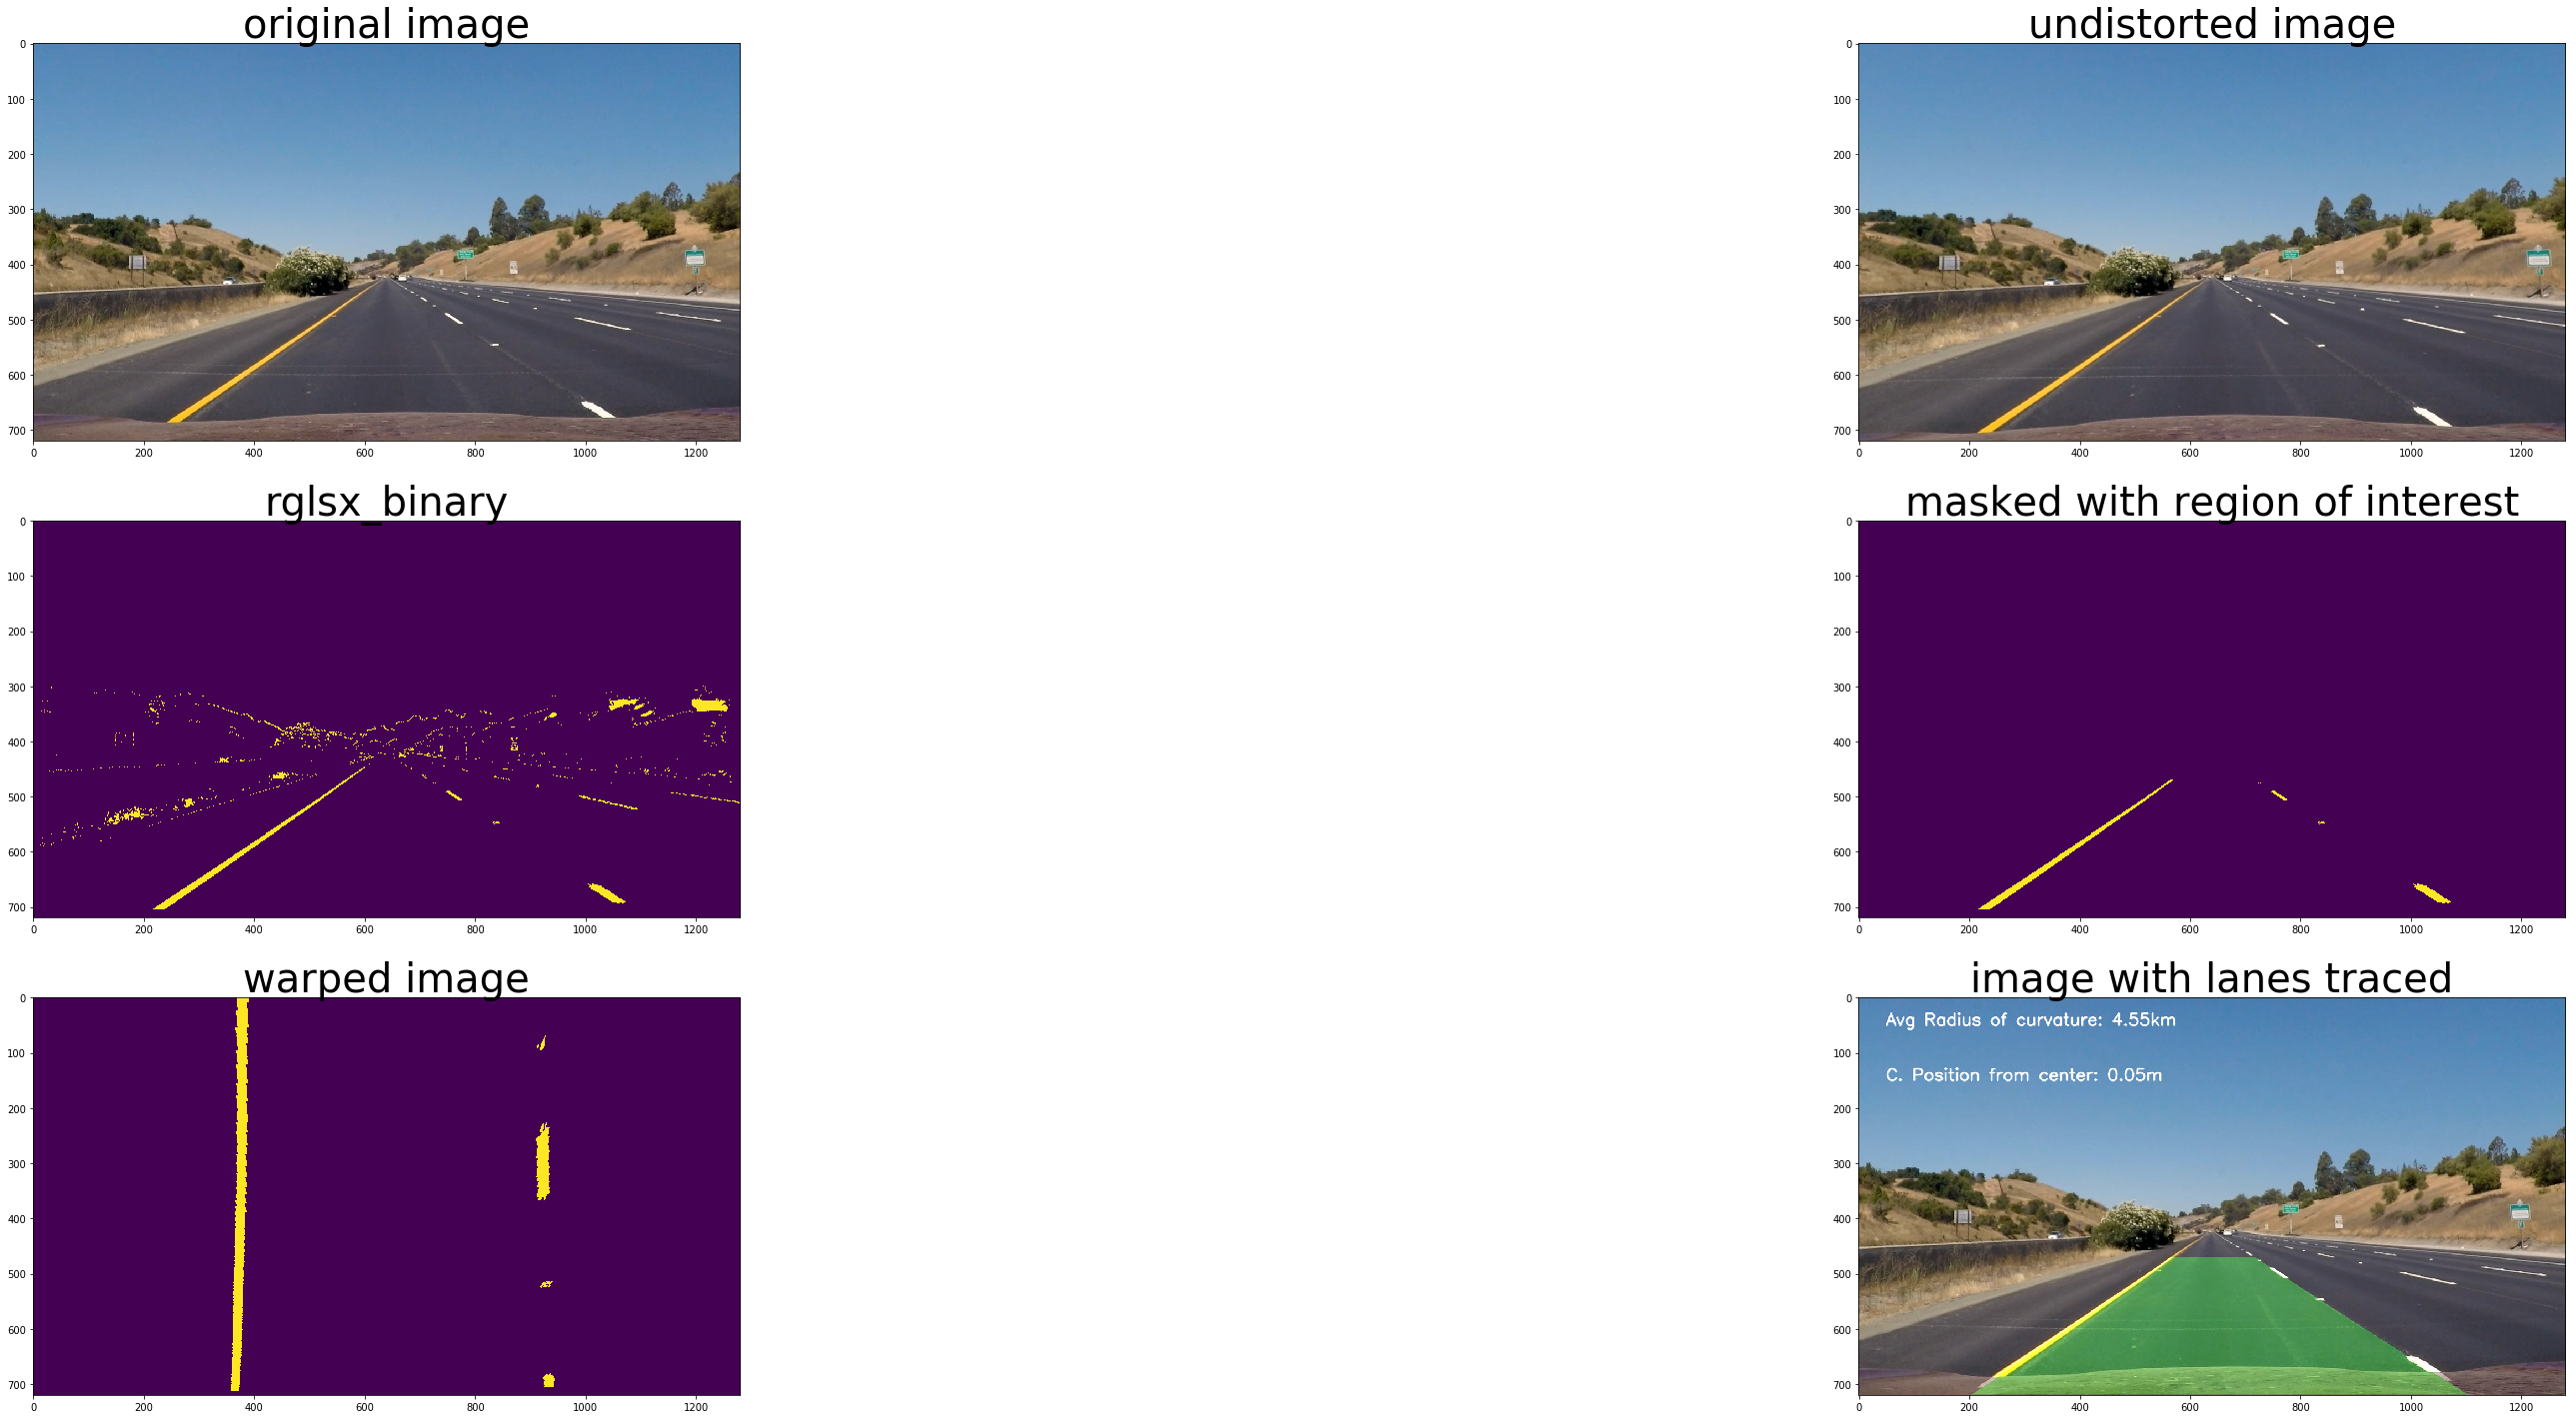

Target image is :  ../test_images/straight_lines2.jpg
left curvead right curvead in pixels:  2.04874118833e+14 1.2912927294e+15
8079.47830562 m 20676.3965389 m 14377.9374222 m


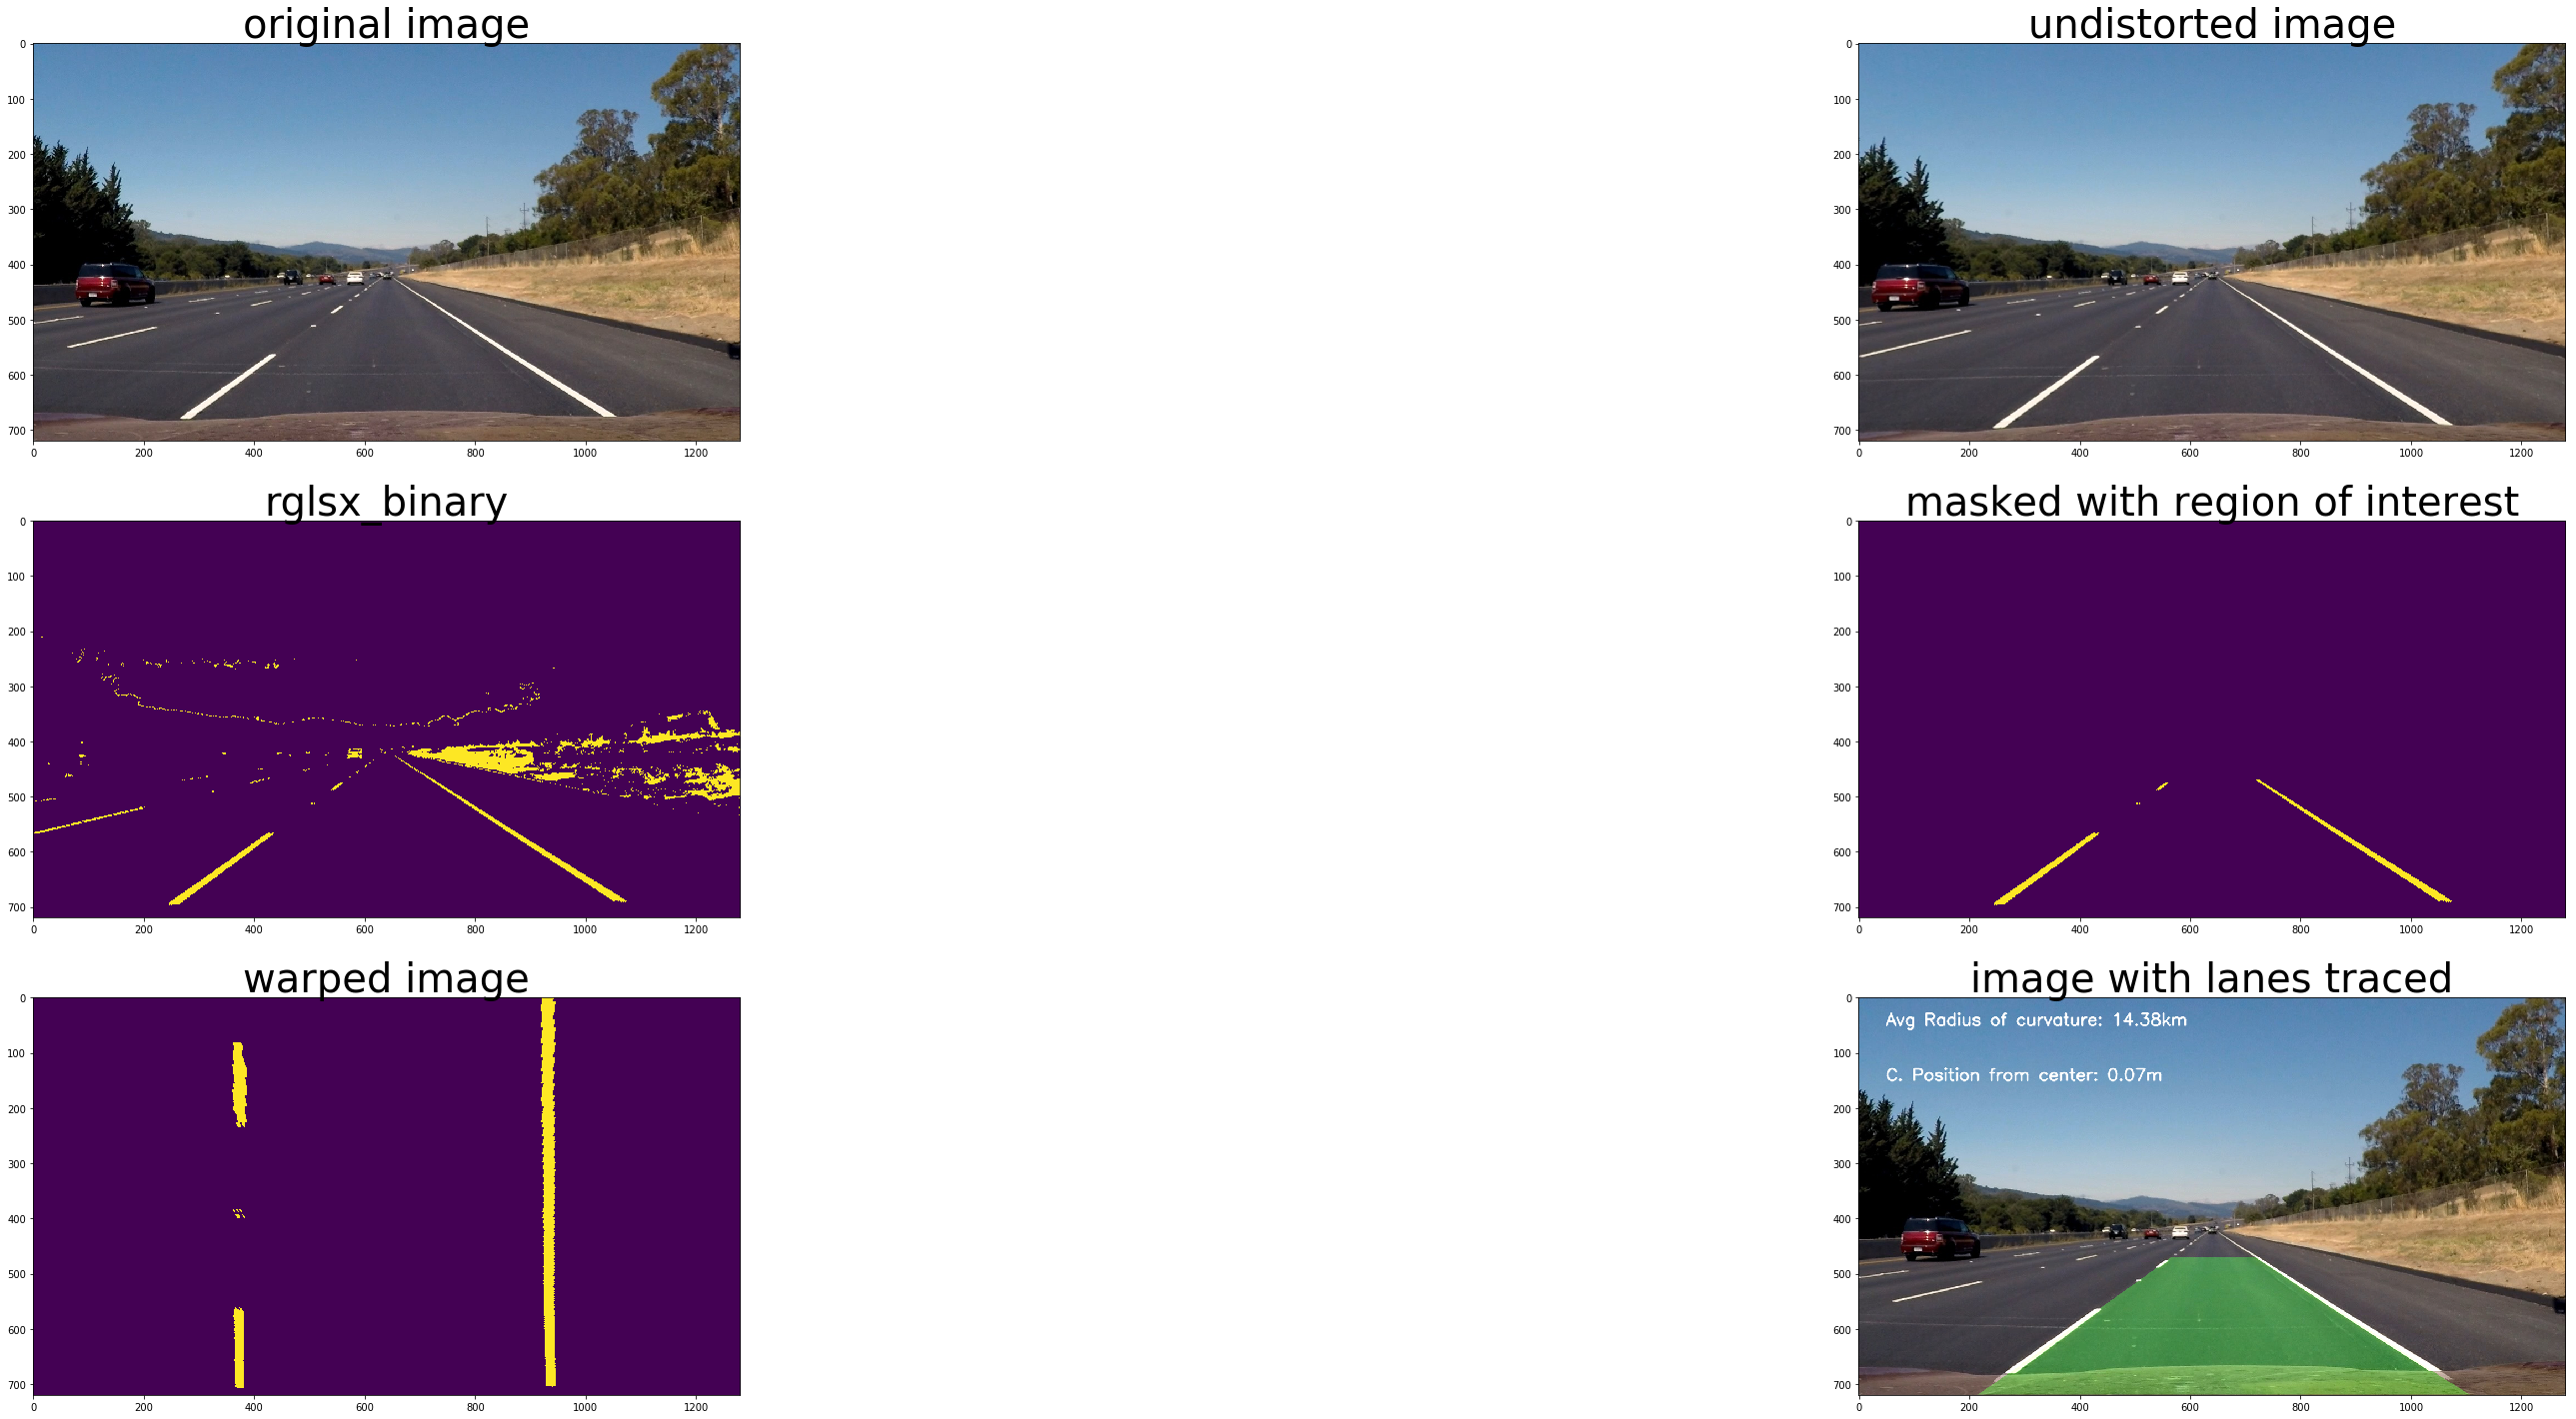

In [12]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

path="../test_images/straight*.jpg"
images = sorted(glob.glob(path))
placeme = placeholder(None, None, mtx, dist, None, None, None, None, None, None, None, None)
for idx, fname in enumerate(images):
    print("Target image is : ", fname)
    image = mpimg.imread(fname)
    result = pipeline_v3(image, draw=True)

Target image is :  ../test_images/test2.jpg
left curvead right curvead in pixels:  2.05297908064e+14 1.26652446701e+15
1421.01774675 m 14700.9220957 m 8060.96992122 m


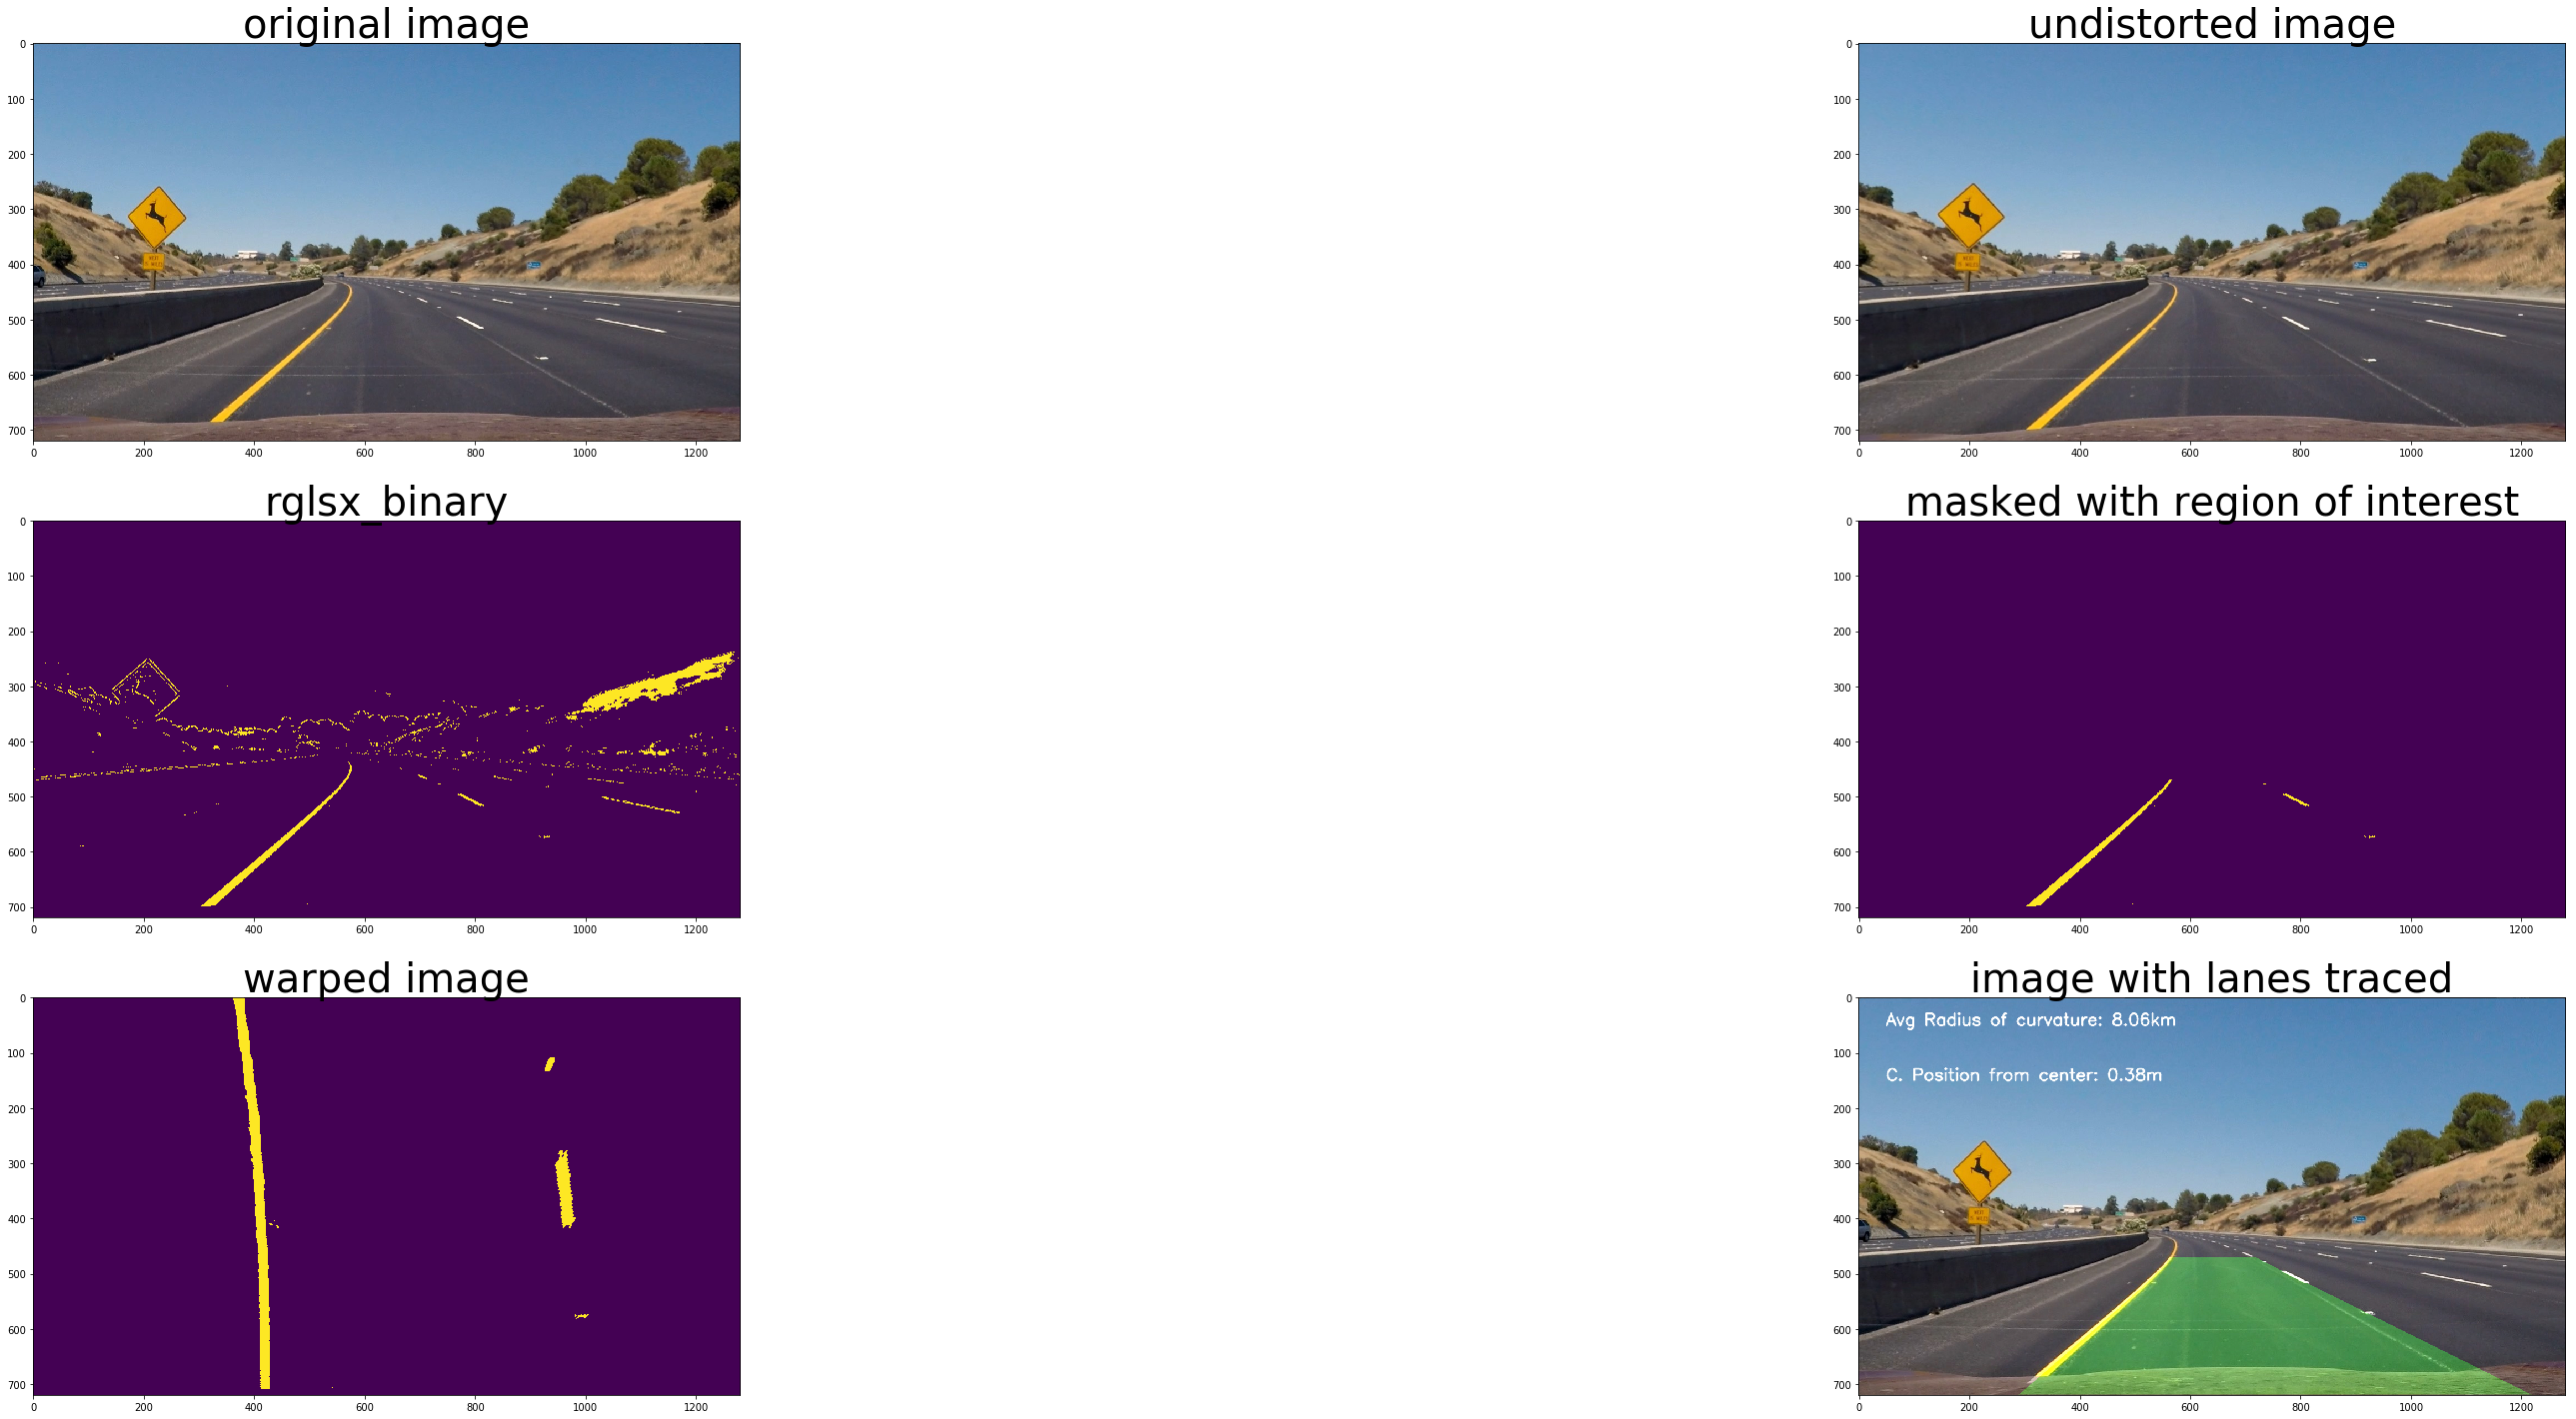

In [14]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

path="../test_images/test2.jpg"
images = sorted(glob.glob(path))
placeme = placeholder(None, None, mtx, dist, None, None, None, None, None, None, None, None)
for idx, fname in enumerate(images):
    print("Target image is : ", fname)
    image = mpimg.imread(fname)
    result = pipeline_v3(image, draw=True)

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

import imageio
imageio.plugins.ffmpeg.download()

placeme = placeholder(None, None, mtx, dist, None, None, None, None, None, None, None, None)

output = 'project_output_colour_pipeline_v3_2.mp4' 
clip1 = VideoFileClip("../project_video.mp4")
output_clip = clip1.fl_image(pipeline_v3)
%time output_clip.write_videofile(output, audio=False)

left curvead right curvead in pixels:  2.04233813692e+14 1.25606928176e+15
1565.70602785 m 3902.56420394 m 2734.13511589 m
[MoviePy] >>>> Building video project_output_colour_pipeline_v3_2.mp4
[MoviePy] Writing video project_output_colour_pipeline_v3_2.mp4


  0%|          | 1/1261 [00:00<08:03,  2.60it/s]

left curvead right curvead in pixels:  2.04233813692e+14 1.25606928176e+15
1565.70602785 m 3902.56420394 m 2734.13511589 m


  0%|          | 2/1261 [00:00<07:41,  2.73it/s]

left curvead right curvead in pixels:  2.04159596626e+14 1.2460757206e+15
1426.19552537 m 3293.04384912 m 2359.61968724 m


  0%|          | 3/1261 [00:01<07:16,  2.88it/s]

left curvead right curvead in pixels:  2.03859542691e+14 1.23669918632e+15
1316.45277701 m 3325.97911074 m 2321.21594388 m


  0%|          | 4/1261 [00:01<06:57,  3.01it/s]

left curvead right curvead in pixels:  2.03801615268e+14 1.2305158474e+15
1277.0266512 m 3170.9562294 m 2223.9914403 m


  0%|          | 5/1261 [00:01<06:47,  3.08it/s]

left curvead right curvead in pixels:  2.02537651174e+14 1.221893758e+15
1267.86934244 m 2054.94059088 m 1661.40496666 m


  0%|          | 6/1261 [00:01<06:37,  3.16it/s]

left curvead right curvead in pixels:  2.02454161116e+14 1.20143386089e+15
1261.22037945 m 1588.77180636 m 1424.99609291 m


  1%|          | 7/1261 [00:02<06:31,  3.20it/s]

left curvead right curvead in pixels:  2.00177588629e+14 1.20196088895e+15
1289.74042569 m 1464.60395181 m 1377.17218875 m


  1%|          | 8/1261 [00:02<06:26,  3.24it/s]

left curvead right curvead in pixels:  1.99267804921e+14 1.18661074953e+15
1252.64445272 m 1669.75202661 m 1461.19823966 m


  1%|          | 9/1261 [00:02<06:26,  3.24it/s]

left curvead right curvead in pixels:  1.95692786654e+14 1.19465481646e+15
1277.28462159 m 1641.30293958 m 1459.29378058 m


  1%|          | 10/1261 [00:03<06:23,  3.26it/s]

left curvead right curvead in pixels:  1.92275102275e+14 1.16944489058e+15
1226.67826898 m 1139.51380312 m 1183.09603605 m


  1%|          | 11/1261 [00:03<06:22,  3.27it/s]

left curvead right curvead in pixels:  1.91332363588e+14 1.17410702458e+15
1227.98756961 m 1413.30216829 m 1320.64486895 m


  1%|          | 12/1261 [00:03<06:18,  3.30it/s]

left curvead right curvead in pixels:  1.84489231611e+14 1.2089691257e+15
1287.46274618 m 1759.56905762 m 1523.5159019 m


  1%|          | 13/1261 [00:04<06:18,  3.30it/s]

left curvead right curvead in pixels:  1.83460394986e+14 1.20129370279e+15
1322.419379 m 3186.57381917 m 2254.49659909 m


  1%|          | 14/1261 [00:04<06:15,  3.32it/s]

left curvead right curvead in pixels:  1.81996362712e+14 1.20067990634e+15
1317.94085915 m 6999.49436946 m 4158.71761431 m


  1%|          | 15/1261 [00:04<06:15,  3.32it/s]

left curvead right curvead in pixels:  1.84754179645e+14 1.1756456121e+15
1407.19701721 m 5037.96167248 m 3222.57934484 m


  1%|▏         | 16/1261 [00:04<06:15,  3.32it/s]

left curvead right curvead in pixels:  1.86016740967e+14 1.16223080247e+15
1436.720822 m 17402.9154043 m 9419.81811317 m


  1%|▏         | 17/1261 [00:05<06:15,  3.31it/s]

left curvead right curvead in pixels:  1.85367773926e+14 1.15654423392e+15
1481.35047601 m 5917.19393101 m 3699.27220351 m


  1%|▏         | 18/1261 [00:05<06:15,  3.31it/s]

left curvead right curvead in pixels:  1.86960967425e+14 1.14219125287e+15
1713.96623112 m 4509.03265452 m 3111.49944282 m


  2%|▏         | 19/1261 [00:05<06:15,  3.31it/s]

left curvead right curvead in pixels:  1.84846988014e+14 1.16751568793e+15
1984.35838844 m 8250.92594255 m 5117.64216549 m


  2%|▏         | 20/1261 [00:06<06:12,  3.33it/s]

left curvead right curvead in pixels:  1.83739200348e+14 1.17340588348e+15
2357.94891536 m 4837.76282667 m 3597.85587102 m


  2%|▏         | 21/1261 [00:06<06:10,  3.35it/s]

left curvead right curvead in pixels:  1.82280357911e+14 1.21209465101e+15
2753.4370049 m 30142.7315438 m 16448.0842743 m


  2%|▏         | 22/1261 [00:06<06:12,  3.33it/s]

left curvead right curvead in pixels:  1.79865291143e+14 1.24657437884e+15
3544.08433794 m 6778.99155712 m 5161.53794753 m


  2%|▏         | 23/1261 [00:07<06:10,  3.34it/s]

left curvead right curvead in pixels:  1.78453834086e+14 1.19533134849e+15
3860.00940326 m 1430.20034553 m 2645.10487439 m


  2%|▏         | 24/1261 [00:07<06:08,  3.35it/s]

left curvead right curvead in pixels:  1.81059717262e+14 1.18464536349e+15
3813.41857503 m 1560.60593516 m 2687.0122551 m


  2%|▏         | 25/1261 [00:07<06:11,  3.33it/s]

left curvead right curvead in pixels:  1.82017027159e+14 1.1804178469e+15
3095.72052145 m 1665.00958156 m 2380.36505151 m


  2%|▏         | 26/1261 [00:07<06:12,  3.32it/s]

left curvead right curvead in pixels:  1.80253263062e+14 1.2032290406e+15
3240.36791123 m 1685.02599803 m 2462.69695463 m


  2%|▏         | 27/1261 [00:08<06:11,  3.32it/s]

left curvead right curvead in pixels:  1.81234276775e+14 1.21305925584e+15
3311.45723329 m 2244.47354009 m 2777.96538669 m


  2%|▏         | 28/1261 [00:08<06:13,  3.30it/s]

left curvead right curvead in pixels:  1.77574242224e+14 1.2387841929e+15
2726.89861434 m 2722.46847932 m 2724.68354683 m


  2%|▏         | 29/1261 [00:08<06:11,  3.31it/s]

left curvead right curvead in pixels:  1.80253501599e+14 1.22669827483e+15
2427.99915953 m 2478.42787547 m 2453.2135175 m


  2%|▏         | 30/1261 [00:09<06:10,  3.32it/s]

left curvead right curvead in pixels:  1.82606550008e+14 1.22035957488e+15
1901.54928104 m 3172.60025193 m 2537.07476649 m


  2%|▏         | 31/1261 [00:09<06:10,  3.32it/s]

left curvead right curvead in pixels:  1.85523476633e+14 1.19546786987e+15
1644.77035917 m 2150.84313679 m 1897.80674798 m


  3%|▎         | 32/1261 [00:09<06:11,  3.30it/s]

left curvead right curvead in pixels:  1.89141614026e+14 1.18405251448e+15
1481.72153028 m 2678.27151301 m 2079.99652165 m


  3%|▎         | 33/1261 [00:10<06:11,  3.30it/s]

left curvead right curvead in pixels:  1.87369709123e+14 1.19460851605e+15
1447.74871845 m 2231.59548429 m 1839.67210137 m


  3%|▎         | 34/1261 [00:10<06:08,  3.33it/s]

left curvead right curvead in pixels:  1.88623004199e+14 1.19633084607e+15
1367.3054422 m 3579.26895098 m 2473.28719659 m


  3%|▎         | 35/1261 [00:10<06:10,  3.31it/s]

left curvead right curvead in pixels:  1.89922535777e+14 1.15480683528e+15
1385.70923197 m 1108.39359181 m 1247.05141189 m


  3%|▎         | 36/1261 [00:10<06:07,  3.33it/s]

left curvead right curvead in pixels:  1.90748871709e+14 1.14656090956e+15
1309.19003641 m 1427.47191215 m 1368.33097428 m


  3%|▎         | 37/1261 [00:11<06:06,  3.34it/s]

left curvead right curvead in pixels:  1.91009794639e+14 1.14659797477e+15
1264.87381768 m 1610.75701454 m 1437.81541611 m


  3%|▎         | 38/1261 [00:11<06:05,  3.34it/s]

left curvead right curvead in pixels:  1.91622126182e+14 1.14179205514e+15
1238.06442722 m 2194.68540766 m 1716.37491744 m


  3%|▎         | 39/1261 [00:11<06:06,  3.34it/s]

left curvead right curvead in pixels:  1.91155427079e+14 1.13084525076e+15
1128.96450452 m 2199.72306635 m 1664.34378544 m


  3%|▎         | 40/1261 [00:12<06:04,  3.35it/s]

left curvead right curvead in pixels:  1.89278003179e+14 1.13598360869e+15
1115.42241537 m 1995.52074318 m 1555.47157927 m


  3%|▎         | 41/1261 [00:12<06:06,  3.33it/s]

left curvead right curvead in pixels:  1.88224788265e+14 1.14042165048e+15
1085.51049433 m 2636.92753384 m 1861.21901409 m


  3%|▎         | 42/1261 [00:12<06:04,  3.34it/s]

left curvead right curvead in pixels:  1.86536292241e+14 1.141937272e+15
1065.15061749 m 2131.28370932 m 1598.21716341 m


  3%|▎         | 43/1261 [00:13<06:08,  3.31it/s]

left curvead right curvead in pixels:  1.83932562273e+14 1.15001777817e+15
1030.26425259 m 1940.94155721 m 1485.6029049 m


  3%|▎         | 44/1261 [00:13<06:06,  3.32it/s]

left curvead right curvead in pixels:  1.81782694486e+14 1.17978185517e+15
1061.49640561 m 2783.05282292 m 1922.27461427 m


  4%|▎         | 45/1261 [00:13<06:04,  3.34it/s]

left curvead right curvead in pixels:  1.78894413842e+14 1.19184993486e+15
1051.45039442 m 2780.82225784 m 1916.13632613 m


  4%|▎         | 46/1261 [00:13<06:04,  3.33it/s]

left curvead right curvead in pixels:  1.77378022352e+14 1.17504665815e+15
1055.50899286 m 2381.50729163 m 1718.50814224 m


  4%|▎         | 47/1261 [00:14<06:05,  3.32it/s]

left curvead right curvead in pixels:  1.75016789016e+14 1.20685338361e+15
1079.85865922 m 9429.25131705 m 5254.55498814 m


  4%|▍         | 48/1261 [00:14<06:07,  3.30it/s]

left curvead right curvead in pixels:  1.73962177036e+14 1.13782819197e+15
1067.31103679 m 1077.00559951 m 1072.15831815 m


  4%|▍         | 49/1261 [00:14<06:08,  3.29it/s]

left curvead right curvead in pixels:  1.70403266063e+14 1.16435981035e+15
1094.81425477 m 1250.45954931 m 1172.63690204 m


  4%|▍         | 50/1261 [00:15<06:07,  3.29it/s]

left curvead right curvead in pixels:  1.68813805371e+14 1.15778991699e+15
1091.30282644 m 1361.91561128 m 1226.60921886 m


  4%|▍         | 51/1261 [00:15<06:06,  3.30it/s]

left curvead right curvead in pixels:  1.67202052969e+14 1.1595118102e+15
1129.80341799 m 1483.51899026 m 1306.66120413 m


  4%|▍         | 52/1261 [00:15<06:11,  3.25it/s]

left curvead right curvead in pixels:  1.6802945991e+14 1.15091528066e+15
1158.87947101 m 2715.40458874 m 1937.14202987 m


  4%|▍         | 53/1261 [00:16<06:11,  3.25it/s]

left curvead right curvead in pixels:  1.68271904363e+14 1.14985079595e+15
1234.92361418 m 3956.28062827 m 2595.60212122 m


  4%|▍         | 54/1261 [00:16<06:10,  3.25it/s]

left curvead right curvead in pixels:  1.68620348075e+14 1.13353984271e+15
1336.10854053 m 1846.06970341 m 1591.08912197 m


  4%|▍         | 55/1261 [00:16<06:10,  3.25it/s]

left curvead right curvead in pixels:  1.67691227248e+14 1.13925171401e+15
1414.17841808 m 1902.90997871 m 1658.5441984 m


  4%|▍         | 56/1261 [00:17<06:10,  3.25it/s]

left curvead right curvead in pixels:  1.67829290216e+14 1.15212555771e+15
1616.09742758 m 2273.04306945 m 1944.57024852 m


  5%|▍         | 57/1261 [00:17<06:10,  3.25it/s]

left curvead right curvead in pixels:  1.70189604866e+14 1.14487529434e+15
1953.96134137 m 2019.65482544 m 1986.80808341 m


  5%|▍         | 58/1261 [00:17<06:10,  3.25it/s]

left curvead right curvead in pixels:  1.70767258035e+14 1.1456896398e+15
2305.1658457 m 1928.68614274 m 2116.92599422 m


  5%|▍         | 59/1261 [00:17<06:10,  3.25it/s]

left curvead right curvead in pixels:  1.75058321576e+14 1.10681034212e+15
2446.54200064 m 1359.29702191 m 1902.91951127 m


  5%|▍         | 60/1261 [00:18<06:11,  3.23it/s]

left curvead right curvead in pixels:  1.79805595522e+14 1.07838904174e+15
3032.9623149 m 1139.31867839 m 2086.14049665 m


  5%|▍         | 61/1261 [00:18<06:13,  3.21it/s]

left curvead right curvead in pixels:  1.81806291362e+14 1.07542713945e+15
3106.10718617 m 1482.34592017 m 2294.22655317 m


  5%|▍         | 62/1261 [00:18<06:11,  3.22it/s]

left curvead right curvead in pixels:  1.84108328618e+14 1.06696629825e+15
2853.40818904 m 1780.56769923 m 2316.98794413 m


  5%|▍         | 63/1261 [00:19<06:09,  3.25it/s]

left curvead right curvead in pixels:  1.83299010697e+14 1.08686638486e+15
2777.82397513 m 5767.11207517 m 4272.46802515 m


  5%|▌         | 64/1261 [00:19<06:08,  3.25it/s]

left curvead right curvead in pixels:  1.85300836114e+14 1.07700883178e+15
2394.09416063 m 2392.30442781 m 2393.19929422 m


  5%|▌         | 65/1261 [00:19<06:12,  3.21it/s]

left curvead right curvead in pixels:  1.83463230734e+14 1.09867828683e+15
2107.12826553 m 4270.71176892 m 3188.92001722 m


  5%|▌         | 66/1261 [00:20<06:09,  3.23it/s]

left curvead right curvead in pixels:  1.84580341533e+14 1.09136319752e+15
1838.72069212 m 3414.63286483 m 2626.67677848 m


  5%|▌         | 67/1261 [00:20<06:14,  3.19it/s]

left curvead right curvead in pixels:  1.8268744794e+14 1.09369148392e+15
1563.11298653 m 2573.83719166 m 2068.4750891 m


  5%|▌         | 68/1261 [00:20<06:12,  3.20it/s]

left curvead right curvead in pixels:  1.8021505934e+14 1.11669101755e+15
1464.40271282 m 5713.87167961 m 3589.13719621 m


  5%|▌         | 69/1261 [00:21<06:10,  3.21it/s]

left curvead right curvead in pixels:  1.80299696841e+14 1.10792144627e+15
1292.55949173 m 5579.11229421 m 3435.83589297 m


  6%|▌         | 70/1261 [00:21<06:07,  3.24it/s]

left curvead right curvead in pixels:  1.77285474707e+14 1.10708957786e+15
1275.50626916 m 2575.22507798 m 1925.36567357 m


  6%|▌         | 71/1261 [00:21<06:08,  3.23it/s]

left curvead right curvead in pixels:  1.77213846507e+14 1.12485994043e+15
1257.00482331 m 7978.48623676 m 4617.74553003 m


  6%|▌         | 72/1261 [00:21<06:06,  3.24it/s]

left curvead right curvead in pixels:  1.73904291647e+14 1.08884951002e+15
1237.86230255 m 1232.47086522 m 1235.16658389 m


  6%|▌         | 73/1261 [00:22<06:07,  3.23it/s]

left curvead right curvead in pixels:  1.73164706013e+14 1.10542265714e+15
1379.39156605 m 2076.29799832 m 1727.84478218 m


  6%|▌         | 74/1261 [00:22<06:08,  3.22it/s]

left curvead right curvead in pixels:  1.73019668914e+14 1.10853356055e+15
1484.6270339 m 2343.80248332 m 1914.21475861 m


  6%|▌         | 75/1261 [00:22<06:08,  3.22it/s]

left curvead right curvead in pixels:  1.70752264283e+14 1.12034682478e+15
1737.00946375 m 2483.41486292 m 2110.21216334 m


  6%|▌         | 76/1261 [00:23<06:07,  3.22it/s]

left curvead right curvead in pixels:  1.72569694998e+14 1.12314000682e+15
2009.22518471 m 2369.57600626 m 2189.40059549 m


  6%|▌         | 77/1261 [00:23<06:05,  3.24it/s]

left curvead right curvead in pixels:  1.67938149391e+14 1.15254942156e+15
2484.11638761 m 3328.14080684 m 2906.12859723 m


  6%|▌         | 78/1261 [00:23<06:03,  3.26it/s]

left curvead right curvead in pixels:  1.67784858162e+14 1.16087003493e+15
3135.07671478 m 2676.40169025 m 2905.73920252 m


  6%|▋         | 79/1261 [00:24<06:02,  3.26it/s]

left curvead right curvead in pixels:  1.66641843161e+14 1.17197141786e+15
3861.09682121 m 3040.43428414 m 3450.76555268 m


  6%|▋         | 80/1261 [00:24<06:03,  3.25it/s]

left curvead right curvead in pixels:  1.67557059724e+14 1.16976303286e+15
4532.78534459 m 2455.02023221 m 3493.9027884 m


  6%|▋         | 81/1261 [00:24<06:00,  3.27it/s]

left curvead right curvead in pixels:  1.71066919212e+14 1.16439845864e+15
6629.52477979 m 2757.55266379 m 4693.53872179 m


  7%|▋         | 82/1261 [00:25<06:00,  3.27it/s]

left curvead right curvead in pixels:  1.70599861199e+14 1.17550040632e+15
8076.3471951 m 3217.18385313 m 5646.76552412 m


  7%|▋         | 83/1261 [00:25<06:01,  3.26it/s]

left curvead right curvead in pixels:  1.70945511289e+14 1.1614836945e+15
8100.53148979 m 2026.9525508 m 5063.7420203 m


  7%|▋         | 84/1261 [00:25<05:58,  3.28it/s]

left curvead right curvead in pixels:  1.6652919967e+14 1.1957238554e+15
8278.32360657 m 2536.09906393 m 5407.21133525 m


  7%|▋         | 85/1261 [00:25<05:59,  3.28it/s]

left curvead right curvead in pixels:  1.68359411612e+14 1.18457051206e+15
7019.79194666 m 1922.3054303 m 4471.04868848 m


  7%|▋         | 86/1261 [00:26<05:57,  3.29it/s]

left curvead right curvead in pixels:  1.70078274647e+14 1.15827884052e+15
5130.58809407 m 1151.94746464 m 3141.26777935 m


  7%|▋         | 87/1261 [00:26<05:56,  3.29it/s]

left curvead right curvead in pixels:  1.77383734074e+14 1.13645007995e+15
3366.61936603 m 1467.756072 m 2417.18771901 m


  7%|▋         | 88/1261 [00:26<05:57,  3.28it/s]

left curvead right curvead in pixels:  1.81588865274e+14 1.12337990601e+15
2573.13043698 m 2241.86417551 m 2407.49730624 m


  7%|▋         | 89/1261 [00:27<05:58,  3.27it/s]

left curvead right curvead in pixels:  1.85085762714e+14 1.12099569867e+15
2201.47461382 m 3408.81758055 m 2805.14609718 m


  7%|▋         | 90/1261 [00:27<05:53,  3.31it/s]

left curvead right curvead in pixels:  1.89719796316e+14 1.09936964443e+15
1815.22077306 m 2924.82295296 m 2370.02186301 m


  7%|▋         | 91/1261 [00:27<05:54,  3.30it/s]

left curvead right curvead in pixels:  1.87580307386e+14 1.11881378602e+15
1780.18390849 m 2891.7741824 m 2335.97904545 m


  7%|▋         | 92/1261 [00:28<06:03,  3.22it/s]

left curvead right curvead in pixels:  1.86258528235e+14 1.12665484339e+15
1635.8577653 m 2991.96613244 m 2313.91194887 m


  7%|▋         | 93/1261 [00:28<06:04,  3.20it/s]

left curvead right curvead in pixels:  1.88946484649e+14 1.12249882428e+15
1497.73579829 m 3121.4684752 m 2309.60213674 m


  7%|▋         | 94/1261 [00:28<06:01,  3.23it/s]

left curvead right curvead in pixels:  1.88906979769e+14 1.12188460738e+15
1393.81940344 m 3124.95411933 m 2259.38676139 m


  8%|▊         | 95/1261 [00:29<06:00,  3.23it/s]

left curvead right curvead in pixels:  1.8727293288e+14 1.13946265237e+15
1412.00029608 m 4256.43334438 m 2834.21682023 m


  8%|▊         | 96/1261 [00:29<05:59,  3.24it/s]

left curvead right curvead in pixels:  1.86527637978e+14 1.14837587508e+15
1367.0085384 m 8224.40504387 m 4795.70679113 m


  8%|▊         | 97/1261 [00:29<05:58,  3.24it/s]

left curvead right curvead in pixels:  1.86531599908e+14 1.10725689025e+15
1367.7418541 m 1218.42726461 m 1293.08455935 m


  8%|▊         | 98/1261 [00:29<06:07,  3.17it/s]

left curvead right curvead in pixels:  1.84390807023e+14 1.11940402898e+15
1430.10050481 m 1197.62099053 m 1313.86074767 m


  8%|▊         | 99/1261 [00:30<06:02,  3.21it/s]

left curvead right curvead in pixels:  1.86069089678e+14 1.12073765619e+15
1467.27326103 m 1661.56256671 m 1564.41791387 m


  8%|▊         | 100/1261 [00:30<05:59,  3.23it/s]

left curvead right curvead in pixels:  1.84627457218e+14 1.13057613348e+15
1466.1392309 m 1648.9641604 m 1557.55169565 m


  8%|▊         | 101/1261 [00:30<05:57,  3.25it/s]

left curvead right curvead in pixels:  1.86472123211e+14 1.13118067668e+15
1556.29937623 m 1523.09246828 m 1539.69592225 m


  8%|▊         | 102/1261 [00:31<05:56,  3.26it/s]

left curvead right curvead in pixels:  1.87682394927e+14 1.12942262675e+15
1568.23878207 m 1730.59410165 m 1649.41644186 m


  8%|▊         | 103/1261 [00:31<05:55,  3.26it/s]

left curvead right curvead in pixels:  1.88099792215e+14 1.13466205422e+15
1602.72205946 m 1645.99638674 m 1624.3592231 m


  8%|▊         | 104/1261 [00:31<05:55,  3.26it/s]

left curvead right curvead in pixels:  1.90012644649e+14 1.13610935922e+15
1768.93428569 m 1591.72260129 m 1680.32844349 m


  8%|▊         | 105/1261 [00:32<05:57,  3.23it/s]

left curvead right curvead in pixels:  1.87932845889e+14 1.16365509046e+15
1854.2282996 m 1907.06202705 m 1880.64516333 m


  8%|▊         | 106/1261 [00:32<05:54,  3.26it/s]

left curvead right curvead in pixels:  1.86794612497e+14 1.17229607641e+15
1857.48784009 m 1708.89289691 m 1783.1903685 m


  8%|▊         | 107/1261 [00:32<05:58,  3.21it/s]

left curvead right curvead in pixels:  1.85089779367e+14 1.20051216258e+15
1793.95668643 m 2380.05815983 m 2087.00742313 m


  9%|▊         | 108/1261 [00:33<05:55,  3.25it/s]

left curvead right curvead in pixels:  1.89488125958e+14 1.19284482318e+15
1738.75164641 m 2521.77513204 m 2130.26338923 m


  9%|▊         | 109/1261 [00:33<05:57,  3.22it/s]

left curvead right curvead in pixels:  1.91017968824e+14 1.19415255842e+15
1753.7396046 m 4661.64779468 m 3207.69369964 m


  9%|▊         | 110/1261 [00:33<05:53,  3.26it/s]

left curvead right curvead in pixels:  1.90830589951e+14 1.23126176219e+15
1623.33481081 m 9603.47122154 m 5613.40301618 m


  9%|▉         | 111/1261 [00:33<05:50,  3.28it/s]

left curvead right curvead in pixels:  1.92128568972e+14 1.1609666278e+15
1629.42633352 m 1332.00890426 m 1480.71761889 m


  9%|▉         | 112/1261 [00:34<05:53,  3.25it/s]

left curvead right curvead in pixels:  1.88286087546e+14 1.19609014981e+15
1619.81076709 m 1639.80170093 m 1629.80623401 m


  9%|▉         | 113/1261 [00:34<05:52,  3.26it/s]

left curvead right curvead in pixels:  1.9111769643e+14 1.18390830548e+15
1518.10596528 m 1797.96151776 m 1658.03374152 m


  9%|▉         | 114/1261 [00:34<05:50,  3.27it/s]

left curvead right curvead in pixels:  1.92886734321e+14 1.18850071307e+15
1510.70312099 m 2664.13075546 m 2087.41693823 m


  9%|▉         | 115/1261 [00:35<05:54,  3.24it/s]

left curvead right curvead in pixels:  1.94952787657e+14 1.18089483363e+15
1389.36392325 m 3030.19165252 m 2209.77778789 m


  9%|▉         | 116/1261 [00:35<05:53,  3.24it/s]

left curvead right curvead in pixels:  1.95422873759e+14 1.1744723194e+15
1359.80756542 m 2693.88115513 m 2026.84436027 m


  9%|▉         | 117/1261 [00:35<05:53,  3.23it/s]

left curvead right curvead in pixels:  1.94701856073e+14 1.18272121582e+15
1340.45075421 m 3139.10382093 m 2239.77728757 m


  9%|▉         | 118/1261 [00:36<05:49,  3.27it/s]

left curvead right curvead in pixels:  1.95150053119e+14 1.18071989848e+15
1347.93465268 m 2454.30933075 m 1901.12199171 m


  9%|▉         | 119/1261 [00:36<05:49,  3.26it/s]

left curvead right curvead in pixels:  1.95027846691e+14 1.17671064836e+15
1319.68089102 m 1910.32467578 m 1615.0027834 m


 10%|▉         | 120/1261 [00:36<05:50,  3.26it/s]

left curvead right curvead in pixels:  1.96407974136e+14 1.16610572148e+15
1254.58787869 m 2016.82431995 m 1635.70609932 m


 10%|▉         | 121/1261 [00:37<05:47,  3.28it/s]

left curvead right curvead in pixels:  1.95167757233e+14 1.15942164834e+15
1281.76094367 m 1359.63825008 m 1320.69959687 m


 10%|▉         | 122/1261 [00:37<05:46,  3.29it/s]

left curvead right curvead in pixels:  1.95053052829e+14 1.12527764168e+15
1229.54889105 m 862.91752851 m 1046.23320978 m


 10%|▉         | 123/1261 [00:37<05:45,  3.29it/s]

left curvead right curvead in pixels:  1.97761694911e+14 1.1211557816e+15
1266.41038677 m 986.353235754 m 1126.38181126 m


 10%|▉         | 124/1261 [00:37<05:43,  3.31it/s]

left curvead right curvead in pixels:  1.97487925631e+14 1.12030664665e+15
1228.93683135 m 1174.89060461 m 1201.91371798 m


 10%|▉         | 125/1261 [00:38<05:43,  3.31it/s]

left curvead right curvead in pixels:  1.97785747356e+14 1.11996165673e+15
1231.19668254 m 1285.58598176 m 1258.39133215 m


 10%|▉         | 126/1261 [00:38<05:44,  3.30it/s]

left curvead right curvead in pixels:  1.94236691709e+14 1.14524964836e+15
1267.59648218 m 1464.25189621 m 1365.92418919 m


 10%|█         | 127/1261 [00:38<05:47,  3.27it/s]

left curvead right curvead in pixels:  1.94263734415e+14 1.13832750928e+15
1234.14464647 m 1585.76942805 m 1409.95703726 m


 10%|█         | 128/1261 [00:39<05:44,  3.29it/s]

left curvead right curvead in pixels:  1.92611243247e+14 1.15398084944e+15
1231.98239912 m 1853.13389567 m 1542.55814739 m


 10%|█         | 129/1261 [00:39<05:40,  3.32it/s]

left curvead right curvead in pixels:  1.94377660963e+14 1.12369054284e+15
1168.04784793 m 1490.85544431 m 1329.45164612 m


 10%|█         | 130/1261 [00:39<05:38,  3.35it/s]

left curvead right curvead in pixels:  1.92636895833e+14 1.1362233053e+15
1153.50729945 m 1736.05251747 m 1444.77990846 m


 10%|█         | 131/1261 [00:40<05:38,  3.34it/s]

left curvead right curvead in pixels:  1.93156343847e+14 1.132030589e+15
1216.53958426 m 1713.04093048 m 1464.79025737 m


 10%|█         | 132/1261 [00:40<05:39,  3.32it/s]

left curvead right curvead in pixels:  1.94781837796e+14 1.13330746874e+15
1232.26217563 m 2036.3011659 m 1634.28167077 m


 11%|█         | 133/1261 [00:40<05:39,  3.32it/s]

left curvead right curvead in pixels:  1.94334720905e+14 1.1414435329e+15
1282.39304405 m 1881.49925802 m 1581.94615104 m


 11%|█         | 134/1261 [00:40<05:43,  3.28it/s]

left curvead right curvead in pixels:  1.96339419946e+14 1.10423703822e+15
1351.84519473 m 875.511635161 m 1113.67841495 m


 11%|█         | 135/1261 [00:41<05:45,  3.26it/s]

left curvead right curvead in pixels:  1.96905034608e+14 1.11879493519e+15
1493.59627874 m 969.970456338 m 1231.78336754 m


 11%|█         | 136/1261 [00:41<05:43,  3.27it/s]

left curvead right curvead in pixels:  1.96461033144e+14 1.13154998686e+15
1592.847034 m 1312.50183993 m 1452.67443696 m


 11%|█         | 137/1261 [00:41<05:42,  3.28it/s]

left curvead right curvead in pixels:  1.96169441908e+14 1.14788369458e+15
1685.78533287 m 1484.17243095 m 1584.97888191 m


 11%|█         | 138/1261 [00:42<05:42,  3.28it/s]

left curvead right curvead in pixels:  1.94623789525e+14 1.16675472567e+15
1772.86985504 m 1525.28469343 m 1649.07727423 m


 11%|█         | 139/1261 [00:42<05:40,  3.29it/s]

left curvead right curvead in pixels:  1.9480827548e+14 1.17471062657e+15
1919.1940026 m 1827.106079 m 1873.1500408 m


 11%|█         | 140/1261 [00:42<05:40,  3.29it/s]

left curvead right curvead in pixels:  1.91652042562e+14 1.19824463179e+15
1939.05669606 m 2359.1008197 m 2149.07875788 m


 11%|█         | 141/1261 [00:43<05:44,  3.26it/s]

left curvead right curvead in pixels:  1.92045488431e+14 1.1963814076e+15
1923.79554138 m 3090.09602212 m 2506.94578175 m


 11%|█▏        | 142/1261 [00:43<05:40,  3.29it/s]

left curvead right curvead in pixels:  1.92081780237e+14 1.20275647036e+15
1839.36590669 m 4572.73239585 m 3206.04915127 m


 11%|█▏        | 143/1261 [00:43<05:39,  3.29it/s]

left curvead right curvead in pixels:  1.94429437194e+14 1.17111788178e+15
1754.75785839 m 2072.94754052 m 1913.85269945 m


 11%|█▏        | 144/1261 [00:44<05:37,  3.31it/s]

left curvead right curvead in pixels:  1.9333866693e+14 1.16885577449e+15
1613.53242625 m 1971.29192391 m 1792.41217508 m


 11%|█▏        | 145/1261 [00:44<05:37,  3.31it/s]

left curvead right curvead in pixels:  1.93351334193e+14 1.18363783241e+15
1621.67092316 m 2895.92455298 m 2258.79773807 m


 12%|█▏        | 146/1261 [00:44<05:45,  3.23it/s]

left curvead right curvead in pixels:  1.94628066429e+14 1.19085901907e+15
1545.89091483 m 4942.81715785 m 3244.35403634 m


 12%|█▏        | 147/1261 [00:44<05:44,  3.24it/s]

left curvead right curvead in pixels:  1.94378456655e+14 1.16567142551e+15
1544.02969919 m 1667.18728334 m 1605.60849126 m


 12%|█▏        | 148/1261 [00:45<05:41,  3.25it/s]

left curvead right curvead in pixels:  2.00738863314e+14 1.13764442703e+15
1591.22186474 m 2040.25672475 m 1815.73929475 m


 12%|█▏        | 149/1261 [00:45<05:40,  3.26it/s]

left curvead right curvead in pixels:  2.02692242791e+14 1.14178247218e+15
1735.5540535 m 2451.90140418 m 2093.72772884 m


 12%|█▏        | 150/1261 [00:45<05:41,  3.25it/s]

left curvead right curvead in pixels:  2.01122670731e+14 1.16246076407e+15
1907.08176944 m 2717.01610848 m 2312.04893896 m


 12%|█▏        | 151/1261 [00:46<05:40,  3.26it/s]

left curvead right curvead in pixels:  2.00355680074e+14 1.17721042622e+15
2125.1254948 m 9705.31650124 m 5915.22099802 m


 12%|█▏        | 152/1261 [00:46<05:39,  3.26it/s]

left curvead right curvead in pixels:  1.98191901209e+14 1.18327914212e+15
2204.68056722 m 4043.05320532 m 3123.86688627 m


 12%|█▏        | 153/1261 [00:46<05:39,  3.26it/s]

left curvead right curvead in pixels:  1.99971763775e+14 1.17329253007e+15
2210.91022632 m 4673.26362314 m 3442.08692473 m


 12%|█▏        | 154/1261 [00:47<05:42,  3.24it/s]

left curvead right curvead in pixels:  1.96819080183e+14 1.19234179053e+15
2390.82119411 m 3468.83990979 m 2929.83055195 m


 12%|█▏        | 155/1261 [00:47<05:41,  3.23it/s]

left curvead right curvead in pixels:  1.94952753528e+14 1.20722883547e+15
2715.24181561 m 4998.17836988 m 3856.71009274 m


 12%|█▏        | 156/1261 [00:47<05:41,  3.24it/s]

left curvead right curvead in pixels:  1.94515821543e+14 1.18401794649e+15
2771.01275425 m 1751.480835 m 2261.24679462 m


 12%|█▏        | 157/1261 [00:48<05:41,  3.23it/s]

left curvead right curvead in pixels:  1.91757235145e+14 1.19770479226e+15
2387.54460045 m 3069.56185527 m 2728.55322786 m


 13%|█▎        | 158/1261 [00:48<05:39,  3.25it/s]

left curvead right curvead in pixels:  1.93576068665e+14 1.13462013625e+15
2121.98608851 m 1161.04243762 m 1641.51426306 m


 13%|█▎        | 159/1261 [00:48<05:42,  3.22it/s]

left curvead right curvead in pixels:  1.90997228431e+14 1.14307551601e+15
2069.37065028 m 1051.75808405 m 1560.56436717 m


 13%|█▎        | 160/1261 [00:48<05:39,  3.24it/s]

left curvead right curvead in pixels:  1.90052013708e+14 1.13143419583e+15
1843.80692435 m 1227.06597328 m 1535.43644882 m


 13%|█▎        | 161/1261 [00:49<05:36,  3.27it/s]

left curvead right curvead in pixels:  1.86180338797e+14 1.14512414486e+15
1822.56160976 m 1187.29797418 m 1504.92979197 m


 13%|█▎        | 162/1261 [00:49<05:34,  3.28it/s]

left curvead right curvead in pixels:  1.82922673887e+14 1.15121473273e+15
1649.58983465 m 1751.65903512 m 1700.62443489 m


 13%|█▎        | 163/1261 [00:49<05:36,  3.26it/s]

left curvead right curvead in pixels:  1.79182911781e+14 1.16176026436e+15
1611.47422381 m 1746.05004373 m 1678.76213377 m


 13%|█▎        | 164/1261 [00:50<05:35,  3.27it/s]

left curvead right curvead in pixels:  1.80281518842e+14 1.15475652615e+15
1555.94278963 m 5165.8693916 m 3360.90609062 m


 13%|█▎        | 165/1261 [00:50<05:35,  3.27it/s]

left curvead right curvead in pixels:  1.82547429293e+14 1.1369267876e+15
1506.02131305 m 6708.07653206 m 4107.04892255 m


 13%|█▎        | 166/1261 [00:50<05:34,  3.27it/s]

left curvead right curvead in pixels:  1.79678702906e+14 1.1423122219e+15
1482.36123428 m 5282.50572656 m 3382.43348042 m


 13%|█▎        | 167/1261 [00:51<05:34,  3.27it/s]

left curvead right curvead in pixels:  1.80411125016e+14 1.12866183068e+15
1391.97152843 m 3925.03056012 m 2658.50104427 m


 13%|█▎        | 168/1261 [00:51<05:35,  3.26it/s]

left curvead right curvead in pixels:  1.76042627041e+14 1.15537503771e+15
1510.63121613 m 5251.13021561 m 3380.88071587 m


 13%|█▎        | 169/1261 [00:51<05:33,  3.27it/s]

left curvead right curvead in pixels:  1.72360219325e+14 1.17353117026e+15
1467.0519683 m 9773.42773102 m 5620.23984966 m


 13%|█▎        | 170/1261 [00:52<05:33,  3.27it/s]

left curvead right curvead in pixels:  1.68152346729e+14 1.20606724578e+15
1473.60547032 m 12065.3106219 m 6769.45804609 m


 14%|█▎        | 171/1261 [00:52<05:35,  3.25it/s]

left curvead right curvead in pixels:  1.65809356235e+14 1.18886752291e+15
1469.3241808 m 4319.37977979 m 2894.3519803 m


 14%|█▎        | 172/1261 [00:52<05:34,  3.26it/s]

left curvead right curvead in pixels:  1.64920593833e+14 1.18979245773e+15
1504.44106469 m 3617.40698364 m 2560.92402417 m


 14%|█▎        | 173/1261 [00:52<05:32,  3.27it/s]

left curvead right curvead in pixels:  1.65486838188e+14 1.14248197498e+15
1541.01917146 m 1201.22085735 m 1371.12001441 m


 14%|█▍        | 174/1261 [00:53<05:33,  3.26it/s]

left curvead right curvead in pixels:  1.700174963e+14 1.11690424027e+15
1819.50503663 m 1418.96481506 m 1619.23492584 m


 14%|█▍        | 175/1261 [00:53<05:33,  3.26it/s]

left curvead right curvead in pixels:  1.73264773682e+14 1.10918756972e+15
2219.8910992 m 1462.79387483 m 1841.34248701 m


 14%|█▍        | 176/1261 [00:53<05:34,  3.24it/s]

left curvead right curvead in pixels:  1.7437096799e+14 1.10594570781e+15
2387.58825494 m 1286.05984547 m 1836.82405021 m


 14%|█▍        | 177/1261 [00:54<05:32,  3.26it/s]

left curvead right curvead in pixels:  1.71191902255e+14 1.13101745598e+15
2956.75527706 m 1396.90719008 m 2176.83123357 m


 14%|█▍        | 178/1261 [00:54<05:33,  3.25it/s]

left curvead right curvead in pixels:  1.71776530629e+14 1.13939853526e+15
3395.79970299 m 1337.57187049 m 2366.68578674 m


 14%|█▍        | 179/1261 [00:54<05:33,  3.25it/s]

left curvead right curvead in pixels:  1.72296577612e+14 1.14518346198e+15
3267.77248188 m 1323.36804839 m 2295.57026514 m


 14%|█▍        | 180/1261 [00:55<05:30,  3.27it/s]

left curvead right curvead in pixels:  1.72733841817e+14 1.15792116289e+15
3576.24056437 m 1246.32540232 m 2411.28298335 m


 14%|█▍        | 181/1261 [00:55<05:31,  3.26it/s]

left curvead right curvead in pixels:  1.75567471283e+14 1.15193527536e+15
2630.0947737 m 1376.97845775 m 2003.53661573 m


 14%|█▍        | 182/1261 [00:55<05:30,  3.27it/s]

left curvead right curvead in pixels:  1.74811872411e+14 1.14257211748e+15
2506.25036149 m 932.861405121 m 1719.55588331 m


 15%|█▍        | 183/1261 [00:55<05:29,  3.27it/s]

left curvead right curvead in pixels:  1.77945055336e+14 1.12494804964e+15
2029.0376377 m 934.58550875 m 1481.81157323 m


 15%|█▍        | 184/1261 [00:56<05:31,  3.25it/s]

left curvead right curvead in pixels:  1.80865956736e+14 1.08177383374e+15
1722.19633812 m 672.047039111 m 1197.12168861 m


 15%|█▍        | 185/1261 [00:56<05:30,  3.25it/s]

left curvead right curvead in pixels:  1.81575489159e+14 1.07733886409e+15
1371.14201428 m 857.008095707 m 1114.07505499 m


 15%|█▍        | 186/1261 [00:56<05:27,  3.28it/s]

left curvead right curvead in pixels:  1.86381324294e+14 1.04650091401e+15
1139.83424992 m 1120.47926731 m 1130.15675862 m


 15%|█▍        | 187/1261 [00:57<05:27,  3.28it/s]

left curvead right curvead in pixels:  1.8535214212e+14 1.04363335483e+15
1044.6224867 m 961.169801161 m 1002.89614393 m


 15%|█▍        | 188/1261 [00:57<05:29,  3.26it/s]

left curvead right curvead in pixels:  1.85855600538e+14 1.03855895594e+15
966.992620494 m 1553.73526771 m 1260.3639441 m


 15%|█▍        | 189/1261 [00:57<05:27,  3.27it/s]

left curvead right curvead in pixels:  1.85448817839e+14 1.03822954994e+15
952.645435107 m 1209.25096436 m 1080.94819973 m


 15%|█▌        | 190/1261 [00:58<05:26,  3.28it/s]

left curvead right curvead in pixels:  1.85780911127e+14 1.04092678234e+15
951.478899863 m 1289.17375681 m 1120.32632834 m


 15%|█▌        | 191/1261 [00:58<05:26,  3.28it/s]

left curvead right curvead in pixels:  1.87564726157e+14 1.03909790814e+15
951.525671644 m 1548.70508706 m 1250.11537935 m


 15%|█▌        | 192/1261 [00:58<05:26,  3.28it/s]

left curvead right curvead in pixels:  1.86186390886e+14 1.04844987176e+15
1033.53073923 m 1404.62481342 m 1219.07777633 m


 15%|█▌        | 193/1261 [00:59<05:25,  3.29it/s]

left curvead right curvead in pixels:  1.87725091674e+14 1.05124210247e+15
1053.5531662 m 1756.51354945 m 1405.03335783 m


 15%|█▌        | 194/1261 [00:59<05:24,  3.29it/s]

left curvead right curvead in pixels:  1.87897334775e+14 1.06792963254e+15
1133.07467162 m 2109.3462159 m 1621.21044376 m


 15%|█▌        | 195/1261 [00:59<05:24,  3.28it/s]

left curvead right curvead in pixels:  1.8732888585e+14 1.02606113063e+15
1156.66210719 m 996.460498881 m 1076.56130303 m


 16%|█▌        | 196/1261 [00:59<05:24,  3.28it/s]

left curvead right curvead in pixels:  1.80465397171e+14 1.07466301063e+15
1267.52255621 m 923.626969408 m 1095.57476281 m


 16%|█▌        | 197/1261 [01:00<05:24,  3.28it/s]

left curvead right curvead in pixels:  1.74114401595e+14 1.1221674801e+15
1387.97350699 m 1155.30886289 m 1271.64118494 m


 16%|█▌        | 198/1261 [01:00<05:25,  3.26it/s]

left curvead right curvead in pixels:  1.6734502366e+14 1.15991901324e+15
1496.02023448 m 1223.80475957 m 1359.91249703 m


 16%|█▌        | 199/1261 [01:00<05:26,  3.26it/s]

left curvead right curvead in pixels:  1.60925563919e+14 1.19295735431e+15
1541.70927463 m 1334.43160076 m 1438.07043769 m


 16%|█▌        | 200/1261 [01:01<05:25,  3.26it/s]

left curvead right curvead in pixels:  1.6043469719e+14 1.1982070763e+15
1513.01346157 m 1798.37528058 m 1655.69437108 m


 16%|█▌        | 201/1261 [01:01<05:24,  3.27it/s]

left curvead right curvead in pixels:  1.57592176418e+14 1.20335419746e+15
1519.42122837 m 1773.64017604 m 1646.53070221 m


 16%|█▌        | 202/1261 [01:01<05:23,  3.28it/s]

left curvead right curvead in pixels:  1.60795746685e+14 1.18230887901e+15
1586.94041895 m 3034.83724369 m 2310.88883132 m


 16%|█▌        | 203/1261 [01:02<05:22,  3.28it/s]

left curvead right curvead in pixels:  1.62213611673e+14 1.17120767871e+15
1534.84028722 m 2942.08224758 m 2238.4612674 m


 16%|█▌        | 204/1261 [01:02<05:21,  3.29it/s]

left curvead right curvead in pixels:  1.62178629534e+14 1.16917391852e+15
1560.58007545 m 2577.12456534 m 2068.8523204 m


 16%|█▋        | 205/1261 [01:02<05:19,  3.30it/s]

left curvead right curvead in pixels:  1.66652790579e+14 1.15203234455e+15
1729.62570836 m 2548.8039902 m 2139.21484928 m


 16%|█▋        | 206/1261 [01:03<05:19,  3.30it/s]

left curvead right curvead in pixels:  1.68703317868e+14 1.13656351794e+15
1753.78220665 m 1820.60560285 m 1787.19390475 m


 16%|█▋        | 207/1261 [01:03<05:22,  3.27it/s]

left curvead right curvead in pixels:  1.74668345775e+14 1.11369386994e+15
1707.13285332 m 1940.91975389 m 1824.02630361 m


 16%|█▋        | 208/1261 [01:03<05:19,  3.29it/s]

left curvead right curvead in pixels:  1.76930076791e+14 1.07695646032e+15
1605.72334818 m 1199.14211189 m 1402.43273003 m


 17%|█▋        | 209/1261 [01:03<05:19,  3.29it/s]

left curvead right curvead in pixels:  1.7489157619e+14 1.07727645113e+15
1699.45388894 m 962.095429084 m 1330.77465901 m


 17%|█▋        | 210/1261 [01:04<05:21,  3.27it/s]

left curvead right curvead in pixels:  1.73293019824e+14 1.09808731375e+15
1707.65982967 m 1171.19335941 m 1439.42659454 m


 17%|█▋        | 211/1261 [01:04<05:22,  3.26it/s]

left curvead right curvead in pixels:  1.6843259455e+14 1.13422347209e+15
1713.12793212 m 1511.3220357 m 1612.22498391 m


 17%|█▋        | 212/1261 [01:04<05:20,  3.27it/s]

left curvead right curvead in pixels:  1.68180536513e+14 1.12506544459e+15
1545.30091044 m 1475.01065923 m 1510.15578483 m


 17%|█▋        | 213/1261 [01:05<05:21,  3.26it/s]

left curvead right curvead in pixels:  1.6737707834e+14 1.1270693855e+15
1464.76982329 m 1628.18610145 m 1546.47796237 m


 17%|█▋        | 214/1261 [01:05<05:22,  3.25it/s]

left curvead right curvead in pixels:  1.66867315693e+14 1.11746330157e+15
1348.97327096 m 1770.71786796 m 1559.84556946 m


 17%|█▋        | 215/1261 [01:05<05:23,  3.23it/s]

left curvead right curvead in pixels:  1.65824839595e+14 1.11595975594e+15
1273.72902095 m 2487.71204977 m 1880.72053536 m


 17%|█▋        | 216/1261 [01:06<05:24,  3.22it/s]

left curvead right curvead in pixels:  1.6356897322e+14 1.10444946518e+15
1211.33001979 m 1808.37418897 m 1509.85210438 m


 17%|█▋        | 217/1261 [01:06<05:24,  3.22it/s]

left curvead right curvead in pixels:  1.62861729874e+14 1.0917917196e+15
1169.79492251 m 1661.25132893 m 1415.52312572 m


 17%|█▋        | 218/1261 [01:06<05:25,  3.20it/s]

left curvead right curvead in pixels:  1.59416062561e+14 1.10856007727e+15
1223.80652536 m 1769.91722511 m 1496.86187524 m


 17%|█▋        | 219/1261 [01:07<05:24,  3.21it/s]

left curvead right curvead in pixels:  1.60329597076e+14 1.07957300884e+15
1163.82435954 m 1563.73343124 m 1363.77889539 m


 17%|█▋        | 220/1261 [01:07<05:21,  3.24it/s]

left curvead right curvead in pixels:  1.56116731394e+14 1.1212404996e+15
1268.94029757 m 3144.33752775 m 2206.63891266 m


 18%|█▊        | 221/1261 [01:07<05:22,  3.22it/s]

left curvead right curvead in pixels:  1.54954508171e+14 1.10746544539e+15
1313.4664696 m 2601.35408728 m 1957.41027844 m


 18%|█▊        | 222/1261 [01:07<05:20,  3.24it/s]

left curvead right curvead in pixels:  1.54413005519e+14 1.07886839629e+15
1352.87529127 m 1316.36989516 m 1334.62259321 m


 18%|█▊        | 223/1261 [01:08<05:19,  3.24it/s]

left curvead right curvead in pixels:  1.5347559002e+14 1.08696190152e+15
1444.66146107 m 1628.7955634 m 1536.72851224 m


 18%|█▊        | 224/1261 [01:08<05:21,  3.23it/s]

left curvead right curvead in pixels:  1.56661566293e+14 1.07767967803e+15
1434.16839265 m 2596.02199756 m 2015.0951951 m


 18%|█▊        | 225/1261 [01:08<05:18,  3.26it/s]

left curvead right curvead in pixels:  1.55863463238e+14 1.09585828862e+15
1480.64654886 m 52401.8576119 m 26941.2520804 m


 18%|█▊        | 226/1261 [01:09<05:16,  3.27it/s]

left curvead right curvead in pixels:  1.56921164647e+14 1.08348153105e+15
1452.57704296 m 10566.3650134 m 6009.47102818 m


 18%|█▊        | 227/1261 [01:09<05:19,  3.24it/s]

left curvead right curvead in pixels:  1.55807065701e+14 1.09471542844e+15
1491.03902444 m 18511.4709452 m 10001.2549848 m


 18%|█▊        | 228/1261 [01:09<05:19,  3.24it/s]

left curvead right curvead in pixels:  1.53723800422e+14 1.10348219297e+15
1551.67672887 m 11345.1814409 m 6448.42908489 m


 18%|█▊        | 229/1261 [01:10<05:18,  3.24it/s]

left curvead right curvead in pixels:  1.53359050589e+14 1.10986278584e+15
1670.08349941 m 14053.5977054 m 7861.84060241 m


 18%|█▊        | 230/1261 [01:10<05:16,  3.25it/s]

left curvead right curvead in pixels:  1.49915568117e+14 1.11981817803e+15
1796.10668932 m 5495.34993026 m 3645.72830979 m


 18%|█▊        | 231/1261 [01:10<05:15,  3.26it/s]

left curvead right curvead in pixels:  1.50244238928e+14 1.1087818712e+15
1835.00193214 m 3445.46347751 m 2640.23270483 m


 18%|█▊        | 232/1261 [01:11<05:17,  3.24it/s]

left curvead right curvead in pixels:  1.47115274876e+14 1.12018469695e+15
1966.68701516 m 3149.10379998 m 2557.89540757 m


 18%|█▊        | 233/1261 [01:11<05:16,  3.25it/s]

left curvead right curvead in pixels:  1.45436766329e+14 1.11651953363e+15
1925.1096488 m 3916.51329969 m 2920.81147425 m


 19%|█▊        | 234/1261 [01:11<05:13,  3.27it/s]

left curvead right curvead in pixels:  1.44917690006e+14 1.08458265999e+15
2048.82528986 m 1423.62145824 m 1736.22337405 m


 19%|█▊        | 235/1261 [01:11<05:14,  3.26it/s]

left curvead right curvead in pixels:  1.4472227186e+14 1.07757683629e+15
2121.58275694 m 1211.03680738 m 1666.30978216 m


 19%|█▊        | 236/1261 [01:12<05:13,  3.27it/s]

left curvead right curvead in pixels:  1.49198709739e+14 1.05714816323e+15
2204.69169726 m 1489.65568609 m 1847.17369167 m


 19%|█▉        | 237/1261 [01:12<05:15,  3.25it/s]

left curvead right curvead in pixels:  1.48340459448e+14 1.06186441095e+15
2192.11766259 m 1657.47180844 m 1924.79473552 m


 19%|█▉        | 238/1261 [01:12<05:13,  3.26it/s]

left curvead right curvead in pixels:  1.50089716918e+14 1.05158661761e+15
2223.71557341 m 1636.79770393 m 1930.25663867 m


 19%|█▉        | 239/1261 [01:13<05:11,  3.28it/s]

left curvead right curvead in pixels:  1.52098543151e+14 1.04842836014e+15
2301.06762549 m 1525.94060231 m 1913.5041139 m


 19%|█▉        | 240/1261 [01:13<05:11,  3.28it/s]

left curvead right curvead in pixels:  1.51621065736e+14 1.05485829786e+15
2311.44497045 m 1823.91140562 m 2067.67818804 m


 19%|█▉        | 241/1261 [01:13<05:10,  3.29it/s]

left curvead right curvead in pixels:  1.51074856806e+14 1.05756676394e+15
2146.19357088 m 1700.46283863 m 1923.32820475 m


 19%|█▉        | 242/1261 [01:14<05:08,  3.30it/s]

left curvead right curvead in pixels:  1.48529399511e+14 1.07689672309e+15
2319.77294898 m 1819.36095989 m 2069.56695443 m


 19%|█▉        | 243/1261 [01:14<05:09,  3.29it/s]

left curvead right curvead in pixels:  1.52126248373e+14 1.06378475562e+15
2099.33804176 m 1887.29900108 m 1993.31852142 m


 19%|█▉        | 244/1261 [01:14<05:09,  3.29it/s]

left curvead right curvead in pixels:  1.51200661886e+14 1.07552777543e+15
2095.44903118 m 2029.15630751 m 2062.30266935 m


 19%|█▉        | 245/1261 [01:15<05:10,  3.27it/s]

left curvead right curvead in pixels:  1.53028139926e+14 1.02910528477e+15
1876.46242893 m 1001.82648283 m 1439.14445588 m


 20%|█▉        | 246/1261 [01:15<05:11,  3.25it/s]

left curvead right curvead in pixels:  1.53988069579e+14 1.01436688992e+15
1799.1743734 m 997.139329654 m 1398.15685153 m


 20%|█▉        | 247/1261 [01:15<05:11,  3.25it/s]

left curvead right curvead in pixels:  1.52267825904e+14 1.02386386582e+15
1717.34490836 m 1161.25914875 m 1439.30202856 m


 20%|█▉        | 248/1261 [01:15<05:11,  3.25it/s]

left curvead right curvead in pixels:  1.55106331742e+14 1.0083799604e+15
1583.88958515 m 1376.45969622 m 1480.17464069 m


 20%|█▉        | 249/1261 [01:16<05:09,  3.27it/s]

left curvead right curvead in pixels:  1.51981281615e+14 1.03165462243e+15
1538.34142074 m 1827.81179571 m 1683.07660822 m


 20%|█▉        | 250/1261 [01:16<05:09,  3.26it/s]

left curvead right curvead in pixels:  1.51931686046e+14 1.03017814005e+15
1424.84229695 m 1738.06872281 m 1581.45550988 m


 20%|█▉        | 251/1261 [01:16<05:10,  3.25it/s]

left curvead right curvead in pixels:  1.51952076801e+14 1.04569212915e+15
1571.93881278 m 2091.26255722 m 1831.600685 m


 20%|█▉        | 252/1261 [01:17<05:12,  3.22it/s]

left curvead right curvead in pixels:  1.51434442441e+14 1.05328683074e+15
1620.10207509 m 1736.96128226 m 1678.53167867 m


 20%|██        | 253/1261 [01:17<05:10,  3.25it/s]

left curvead right curvead in pixels:  1.51589073862e+14 1.05117337604e+15
1541.35114743 m 1625.49063329 m 1583.42089036 m


 20%|██        | 254/1261 [01:17<05:07,  3.27it/s]

left curvead right curvead in pixels:  1.51105574998e+14 1.07493697921e+15
1720.17427987 m 2169.68960303 m 1944.93194145 m


 20%|██        | 255/1261 [01:18<05:08,  3.26it/s]

left curvead right curvead in pixels:  1.5509390175e+14 1.07159021498e+15
1632.77739803 m 2388.84790975 m 2010.81265389 m


 20%|██        | 256/1261 [01:18<05:10,  3.24it/s]

left curvead right curvead in pixels:  1.55660669484e+14 1.05903135374e+15
1653.64280676 m 1494.60676757 m 1574.12478716 m


 20%|██        | 257/1261 [01:18<05:07,  3.26it/s]

left curvead right curvead in pixels:  1.59101047114e+14 1.04253559568e+15
1681.51746853 m 1119.46705501 m 1400.49226177 m


 20%|██        | 258/1261 [01:19<05:09,  3.24it/s]

left curvead right curvead in pixels:  1.62104731507e+14 1.04552914569e+15
1690.82178376 m 1252.63880574 m 1471.73029475 m


 21%|██        | 259/1261 [01:19<05:07,  3.26it/s]

left curvead right curvead in pixels:  1.62428122935e+14 1.0632962685e+15
1709.23365116 m 1678.71549278 m 1693.97457197 m


 21%|██        | 260/1261 [01:19<05:10,  3.23it/s]

left curvead right curvead in pixels:  1.66782293388e+14 1.06033496912e+15
1770.6288834 m 1742.55266614 m 1756.59077477 m


 21%|██        | 261/1261 [01:19<05:08,  3.24it/s]

left curvead right curvead in pixels:  1.64576427324e+14 1.09136791058e+15
1903.29338204 m 2173.76321397 m 2038.52829801 m


 21%|██        | 262/1261 [01:20<05:10,  3.22it/s]

left curvead right curvead in pixels:  1.67725782335e+14 1.09624866821e+15
2006.19484324 m 2002.32742329 m 2004.26113327 m


 21%|██        | 263/1261 [01:20<05:14,  3.18it/s]

left curvead right curvead in pixels:  1.69159785329e+14 1.1078590925e+15
2179.91082421 m 2397.65628416 m 2288.78355418 m


 21%|██        | 264/1261 [01:20<05:10,  3.21it/s]

left curvead right curvead in pixels:  1.69956489825e+14 1.11670525723e+15
2226.69670707 m 2175.85743989 m 2201.27707348 m


 21%|██        | 265/1261 [01:21<05:07,  3.24it/s]

left curvead right curvead in pixels:  1.70089230707e+14 1.1269027259e+15
2125.1154495 m 2208.63683502 m 2166.87614226 m


 21%|██        | 266/1261 [01:21<05:07,  3.23it/s]

left curvead right curvead in pixels:  1.66644079136e+14 1.14633237551e+15
2008.15371565 m 2079.6859479 m 2043.91983177 m


 21%|██        | 267/1261 [01:21<05:06,  3.25it/s]

left curvead right curvead in pixels:  1.7000363387e+14 1.13244860809e+15
1902.39980034 m 1605.99532511 m 1754.19756272 m


 21%|██▏       | 268/1261 [01:22<05:07,  3.23it/s]

left curvead right curvead in pixels:  1.69798064437e+14 1.14033617063e+15
1906.69621766 m 1631.18294586 m 1768.93958176 m


 21%|██▏       | 269/1261 [01:22<05:06,  3.24it/s]

left curvead right curvead in pixels:  1.68310236881e+14 1.14685986087e+15
1956.2739748 m 1360.23769819 m 1658.25583649 m


 21%|██▏       | 270/1261 [01:22<05:06,  3.24it/s]

left curvead right curvead in pixels:  1.6992162368e+14 1.13036236014e+15
1944.34730643 m 988.156815581 m 1466.25206101 m


 21%|██▏       | 271/1261 [01:23<05:05,  3.24it/s]

left curvead right curvead in pixels:  1.73099912577e+14 1.13478976826e+15
1941.50314511 m 1507.64219903 m 1724.57267207 m


 22%|██▏       | 272/1261 [01:23<05:04,  3.25it/s]

left curvead right curvead in pixels:  1.78526362364e+14 1.1112871897e+15
1772.79903179 m 1545.55322729 m 1659.17612954 m


 22%|██▏       | 273/1261 [01:23<05:03,  3.26it/s]

left curvead right curvead in pixels:  1.80264038705e+14 1.11769075091e+15
1839.86760063 m 1727.0020962 m 1783.43484841 m


 22%|██▏       | 274/1261 [01:23<05:03,  3.25it/s]

left curvead right curvead in pixels:  1.84727751532e+14 1.11039009164e+15
1726.101344 m 5723.21027941 m 3724.65581171 m


 22%|██▏       | 275/1261 [01:24<05:04,  3.24it/s]

left curvead right curvead in pixels:  1.8472597273e+14 1.12580951108e+15
1872.60784708 m 3881.4457948 m 2877.02682094 m


 22%|██▏       | 276/1261 [01:24<05:05,  3.22it/s]

left curvead right curvead in pixels:  1.8384539692e+14 1.150600103e+15
1993.60491461 m 5561.71687332 m 3777.66089396 m


 22%|██▏       | 277/1261 [01:24<05:03,  3.24it/s]

left curvead right curvead in pixels:  1.84331651438e+14 1.15522019802e+15
2005.01076513 m 4230.37751395 m 3117.69413954 m


 22%|██▏       | 278/1261 [01:25<05:05,  3.21it/s]

left curvead right curvead in pixels:  1.8199697885e+14 1.16479203467e+15
1922.9164956 m 2379.54061109 m 2151.22855334 m


 22%|██▏       | 279/1261 [01:25<05:04,  3.23it/s]

left curvead right curvead in pixels:  1.86460707259e+14 1.15177461744e+15
1886.31358849 m 2274.75924254 m 2080.53641551 m


 22%|██▏       | 280/1261 [01:25<05:02,  3.25it/s]

left curvead right curvead in pixels:  1.87372024114e+14 1.15985821693e+15
1821.52327404 m 2472.34606041 m 2146.93466722 m


 22%|██▏       | 281/1261 [01:26<05:00,  3.27it/s]

left curvead right curvead in pixels:  1.89001676541e+14 1.14388831289e+15
1921.42242461 m 1420.72892662 m 1671.07567561 m


 22%|██▏       | 282/1261 [01:26<05:00,  3.26it/s]

left curvead right curvead in pixels:  1.92533090765e+14 1.13332945443e+15
1911.7688276 m 1252.02808016 m 1581.89845388 m


 22%|██▏       | 283/1261 [01:26<04:59,  3.27it/s]

left curvead right curvead in pixels:  1.92007232225e+14 1.15579594104e+15
2012.07715709 m 1683.85372925 m 1847.96544317 m


 23%|██▎       | 284/1261 [01:27<04:58,  3.27it/s]

left curvead right curvead in pixels:  1.95712009302e+14 1.16302136734e+15
2145.83889448 m 1923.99532668 m 2034.91711058 m


 23%|██▎       | 285/1261 [01:27<04:58,  3.27it/s]

left curvead right curvead in pixels:  1.95268519227e+14 1.18645837285e+15
2233.37547095 m 2358.82437619 m 2296.09992357 m


 23%|██▎       | 286/1261 [01:27<04:57,  3.28it/s]

left curvead right curvead in pixels:  1.94600804254e+14 1.2099473647e+15
2402.36155599 m 4903.63604522 m 3652.99880061 m


 23%|██▎       | 287/1261 [01:27<04:56,  3.29it/s]

left curvead right curvead in pixels:  1.96665923449e+14 1.2147149953e+15
2393.00477977 m 4464.67868733 m 3428.84173355 m


 23%|██▎       | 288/1261 [01:28<04:59,  3.25it/s]

left curvead right curvead in pixels:  1.97176646156e+14 1.23554878613e+15
2545.20497402 m 4959.96948676 m 3752.58723039 m


 23%|██▎       | 289/1261 [01:28<04:58,  3.26it/s]

left curvead right curvead in pixels:  2.03524446988e+14 1.22593832809e+15
2463.2618476 m 7001.10674422 m 4732.18429591 m


 23%|██▎       | 290/1261 [01:28<04:57,  3.26it/s]

left curvead right curvead in pixels:  2.04308656629e+14 1.23783124912e+15
2645.3747013 m 7109.11487449 m 4877.2447879 m


 23%|██▎       | 291/1261 [01:29<04:57,  3.26it/s]

left curvead right curvead in pixels:  2.1102750867e+14 1.24466180365e+15
2729.66034871 m 18334.4282803 m 10532.0443145 m


 23%|██▎       | 292/1261 [01:29<04:55,  3.28it/s]

left curvead right curvead in pixels:  2.14961126449e+14 1.24282239082e+15
3069.57554484 m 69540.7920904 m 36305.1838176 m


 23%|██▎       | 293/1261 [01:29<04:55,  3.28it/s]

left curvead right curvead in pixels:  2.14965961427e+14 1.26359828957e+15
3300.60614635 m 3758.86540737 m 3529.73577686 m


 23%|██▎       | 294/1261 [01:30<04:56,  3.27it/s]

left curvead right curvead in pixels:  2.1803970203e+14 1.19712471101e+15
3504.64025028 m 1797.62113323 m 2651.13069175 m


 23%|██▎       | 295/1261 [01:30<04:55,  3.27it/s]

left curvead right curvead in pixels:  2.1626227498e+14 1.20526745048e+15
3312.81534305 m 2088.60735157 m 2700.71134731 m


 23%|██▎       | 296/1261 [01:30<04:54,  3.27it/s]

left curvead right curvead in pixels:  2.18505601877e+14 1.20016195881e+15
3396.30562042 m 2005.89316775 m 2701.09939408 m


 24%|██▎       | 297/1261 [01:30<04:53,  3.28it/s]

left curvead right curvead in pixels:  2.16435605416e+14 1.21069314127e+15
3362.64000209 m 2761.51128157 m 3062.07564183 m


 24%|██▎       | 298/1261 [01:31<04:53,  3.28it/s]

left curvead right curvead in pixels:  2.148434077e+14 1.22088923564e+15
3661.82260605 m 5150.04545218 m 4405.93402911 m


 24%|██▎       | 299/1261 [01:31<04:52,  3.29it/s]

left curvead right curvead in pixels:  2.13036622677e+14 1.22658802302e+15
3506.54521826 m 5773.78446069 m 4640.16483947 m


 24%|██▍       | 300/1261 [01:31<04:54,  3.27it/s]

left curvead right curvead in pixels:  2.10224243472e+14 1.23739271336e+15
3544.83291276 m 4593.06915053 m 4068.95103164 m


 24%|██▍       | 301/1261 [01:32<04:52,  3.29it/s]

left curvead right curvead in pixels:  2.10506896983e+14 1.23272997971e+15
3314.08798977 m 5141.48894663 m 4227.7884682 m


 24%|██▍       | 302/1261 [01:32<04:53,  3.27it/s]

left curvead right curvead in pixels:  2.04514396724e+14 1.23420782878e+15
3339.07587948 m 2120.44466712 m 2729.7602733 m


 24%|██▍       | 303/1261 [01:32<04:56,  3.23it/s]

left curvead right curvead in pixels:  2.04811419358e+14 1.25426281336e+15
3341.40511104 m 11360.6894526 m 7351.04728183 m


 24%|██▍       | 304/1261 [01:33<04:51,  3.28it/s]

left curvead right curvead in pixels:  2.04926184537e+14 1.2234133855e+15
3106.97943048 m 2206.39576071 m 2656.68759559 m


 24%|██▍       | 305/1261 [01:33<04:49,  3.30it/s]

left curvead right curvead in pixels:  2.01999465295e+14 1.24127503631e+15
3078.70286264 m 3304.90496193 m 3191.80391229 m


 24%|██▍       | 306/1261 [01:33<04:54,  3.24it/s]

left curvead right curvead in pixels:  2.10695899567e+14 1.19546958377e+15
4020.8675019 m 1508.32083293 m 2764.59416741 m


 24%|██▍       | 307/1261 [01:34<04:51,  3.27it/s]

left curvead right curvead in pixels:  2.07193072412e+14 1.22498417092e+15
4257.85782787 m 2672.70390028 m 3465.28086407 m


 24%|██▍       | 308/1261 [01:34<04:50,  3.28it/s]

left curvead right curvead in pixels:  2.18989301008e+14 1.20433720637e+15
5003.18311402 m 3256.461149 m 4129.82213151 m


 25%|██▍       | 309/1261 [01:34<04:50,  3.27it/s]

left curvead right curvead in pixels:  2.19920818242e+14 1.21921157185e+15
5578.50571658 m 5850.23797125 m 5714.37184392 m


 25%|██▍       | 310/1261 [01:34<04:50,  3.28it/s]

left curvead right curvead in pixels:  2.24156081989e+14 1.22661339218e+15
6468.5108824 m 7482.74508524 m 6975.62798382 m


 25%|██▍       | 311/1261 [01:35<04:48,  3.29it/s]

left curvead right curvead in pixels:  2.29617527617e+14 1.22199475905e+15
5750.71421396 m 6706.11791973 m 6228.41606685 m


 25%|██▍       | 312/1261 [01:35<04:50,  3.27it/s]

left curvead right curvead in pixels:  2.31634443464e+14 1.23281569858e+15
6733.38995591 m 5480.43508431 m 6106.91252011 m


 25%|██▍       | 313/1261 [01:35<04:51,  3.26it/s]

left curvead right curvead in pixels:  2.40760615292e+14 1.21209543848e+15
6086.37233544 m 12203.3387769 m 9144.85555615 m


 25%|██▍       | 314/1261 [01:36<04:52,  3.24it/s]

left curvead right curvead in pixels:  2.40409136353e+14 1.23126152524e+15
7236.90546336 m 8760.09992452 m 7998.50269394 m


 25%|██▍       | 315/1261 [01:36<04:53,  3.23it/s]

left curvead right curvead in pixels:  2.41175817133e+14 1.25059979832e+15
6843.14703981 m 4111.3738427 m 5477.26044126 m


 25%|██▌       | 316/1261 [01:36<04:52,  3.23it/s]

left curvead right curvead in pixels:  2.39993837949e+14 1.26325079478e+15
7507.57894649 m 5964.71550134 m 6736.14722392 m


 25%|██▌       | 317/1261 [01:37<04:50,  3.25it/s]

left curvead right curvead in pixels:  2.39240053947e+14 1.29214234114e+15
8133.83624523 m 1850.15391426 m 4991.99507974 m


 25%|██▌       | 318/1261 [01:37<04:50,  3.24it/s]

left curvead right curvead in pixels:  2.48094241308e+14 1.23729468869e+15
10781.2047437 m 16632.1791106 m 13706.6919272 m


 25%|██▌       | 319/1261 [01:37<04:51,  3.23it/s]

left curvead right curvead in pixels:  2.47071559341e+14 1.25030496968e+15
10978.9794295 m 59647.6515334 m 35313.3154814 m


 25%|██▌       | 320/1261 [01:38<04:53,  3.20it/s]

left curvead right curvead in pixels:  2.52912875447e+14 1.24841617401e+15
13077.7441815 m 13963.5337479 m 13520.6389647 m


 25%|██▌       | 321/1261 [01:38<04:52,  3.21it/s]

left curvead right curvead in pixels:  2.51495329855e+14 1.26549075387e+15
28723.779253 m 9010.16168329 m 18866.9704682 m


 26%|██▌       | 322/1261 [01:38<04:50,  3.24it/s]

left curvead right curvead in pixels:  2.52546271893e+14 1.27185299447e+15
137201.400914 m 9220.1821216 m 73210.7915178 m


 26%|██▌       | 323/1261 [01:38<04:46,  3.28it/s]

left curvead right curvead in pixels:  2.53919144958e+14 1.27520954753e+15
32340.2375105 m 13188.299322 m 22764.2684163 m


 26%|██▌       | 324/1261 [01:39<04:45,  3.29it/s]

left curvead right curvead in pixels:  2.48645309198e+14 1.30164236585e+15
22019.2352609 m 20178.3829675 m 21098.8091142 m


 26%|██▌       | 325/1261 [01:39<04:45,  3.28it/s]

left curvead right curvead in pixels:  2.52118122234e+14 1.29766423533e+15
15352.1834749 m 26063.3124859 m 20707.7479804 m


 26%|██▌       | 326/1261 [01:39<04:51,  3.20it/s]

left curvead right curvead in pixels:  2.5291114132e+14 1.30218466773e+15
14549.2684937 m 28567.9027985 m 21558.5856461 m


 26%|██▌       | 327/1261 [01:40<04:52,  3.19it/s]

left curvead right curvead in pixels:  2.49886808159e+14 1.32226551094e+15
14272.2449922 m 13395.4978243 m 13833.8714082 m


 26%|██▌       | 328/1261 [01:40<04:51,  3.20it/s]

left curvead right curvead in pixels:  2.49798770623e+14 1.31797613972e+15
17127.9776666 m 38678.223176 m 27903.1004213 m


 26%|██▌       | 329/1261 [01:40<04:51,  3.20it/s]

left curvead right curvead in pixels:  2.43403981814e+14 1.34471419111e+15
12202.0583767 m 492264.101905 m 252233.080141 m


 26%|██▌       | 330/1261 [01:41<04:48,  3.22it/s]

left curvead right curvead in pixels:  2.49029231309e+14 1.28631519539e+15
13267.109599 m 1656.48277995 m 7461.79618946 m


 26%|██▌       | 331/1261 [01:41<04:48,  3.22it/s]

left curvead right curvead in pixels:  2.53333429216e+14 1.2887305744e+15
10985.347364 m 3085.54778777 m 7035.44757588 m


 26%|██▋       | 332/1261 [01:41<04:47,  3.23it/s]

left curvead right curvead in pixels:  2.62523575827e+14 1.26456026779e+15
15373.7879995 m 12097.0713588 m 13735.4296792 m


 26%|██▋       | 333/1261 [01:42<04:45,  3.25it/s]

left curvead right curvead in pixels:  2.66333321587e+14 1.25925969995e+15
17459.0435609 m 10085.0684706 m 13772.0560157 m


 26%|██▋       | 334/1261 [01:42<04:43,  3.27it/s]

left curvead right curvead in pixels:  2.65004320257e+14 1.26608645264e+15
18827.0944174 m 20927.2891267 m 19877.1917721 m


 27%|██▋       | 335/1261 [01:42<04:42,  3.27it/s]

left curvead right curvead in pixels:  2.64733074952e+14 1.27275678455e+15
24238.0230509 m 8237.76522709 m 16237.894139 m


 27%|██▋       | 336/1261 [01:42<04:42,  3.27it/s]

left curvead right curvead in pixels:  2.55441657003e+14 1.30606501859e+15
24926.0983981 m 15435.9739451 m 20181.0361716 m


 27%|██▋       | 337/1261 [01:43<04:43,  3.26it/s]

left curvead right curvead in pixels:  2.55041728311e+14 1.30930648918e+15
53700.8025215 m 45056.723649 m 49378.7630853 m


 27%|██▋       | 338/1261 [01:43<04:44,  3.24it/s]

left curvead right curvead in pixels:  2.54706471132e+14 1.32079367842e+15
57833.8361665 m 12967.3463233 m 35400.5912449 m


 27%|██▋       | 339/1261 [01:43<04:42,  3.26it/s]

left curvead right curvead in pixels:  2.55439746766e+14 1.31697752448e+15
28495.2495372 m 22334.0653025 m 25414.6574199 m


 27%|██▋       | 340/1261 [01:44<04:41,  3.27it/s]

left curvead right curvead in pixels:  2.60506820699e+14 1.30891730449e+15
15223.9514809 m 8001.49953917 m 11612.7255101 m


 27%|██▋       | 341/1261 [01:44<04:41,  3.26it/s]

left curvead right curvead in pixels:  2.60168834864e+14 1.29604426182e+15
11792.7980047 m 11120.0643295 m 11456.4311671 m


 27%|██▋       | 342/1261 [01:44<04:49,  3.17it/s]

left curvead right curvead in pixels:  2.6863645487e+14 1.26760598661e+15
15976.0431742 m 7721.56572727 m 11848.8044507 m


 27%|██▋       | 343/1261 [01:45<04:46,  3.20it/s]

left curvead right curvead in pixels:  2.64499400177e+14 1.28251766089e+15
27018.404725 m 114013.988654 m 70516.1966895 m


 27%|██▋       | 344/1261 [01:45<04:46,  3.20it/s]

left curvead right curvead in pixels:  2.60891940279e+14 1.29580894344e+15
116301.957883 m 38855.9918283 m 77578.9748559 m


 27%|██▋       | 345/1261 [01:45<04:48,  3.18it/s]

left curvead right curvead in pixels:  2.59196897333e+14 1.30625974465e+15
25620.7872018 m 6971.64562233 m 16296.2164121 m


 27%|██▋       | 346/1261 [01:46<04:46,  3.19it/s]

left curvead right curvead in pixels:  2.5534062528e+14 1.32361981565e+15
13735.0207063 m 5062.08020829 m 9398.55045732 m


 28%|██▊       | 347/1261 [01:46<04:47,  3.17it/s]

left curvead right curvead in pixels:  2.60134134415e+14 1.31496882001e+15
8904.25228916 m 5197.54097092 m 7050.89663004 m


 28%|██▊       | 348/1261 [01:46<04:46,  3.19it/s]

left curvead right curvead in pixels:  2.56253346851e+14 1.33478082976e+15
6952.5666292 m 4629.82566841 m 5791.1961488 m


 28%|██▊       | 349/1261 [01:47<04:43,  3.22it/s]

left curvead right curvead in pixels:  2.61324809381e+14 1.32736860795e+15
5890.18438577 m 5622.57560447 m 5756.37999512 m


 28%|██▊       | 350/1261 [01:47<04:41,  3.24it/s]

left curvead right curvead in pixels:  2.584577344e+14 1.33727949206e+15
4874.39463667 m 12409.5563637 m 8641.97550019 m


 28%|██▊       | 351/1261 [01:47<04:40,  3.24it/s]

left curvead right curvead in pixels:  2.60552158297e+14 1.352911786e+15
4995.63816698 m 3617.19854868 m 4306.41835783 m


 28%|██▊       | 352/1261 [01:47<04:38,  3.26it/s]

left curvead right curvead in pixels:  2.60529080038e+14 1.36613233801e+15
6035.87722827 m 2768.1889814 m 4402.03310483 m


 28%|██▊       | 353/1261 [01:48<04:37,  3.27it/s]

left curvead right curvead in pixels:  2.55513960885e+14 1.37473166169e+15
7669.25205683 m 4287.34867302 m 5978.30036493 m


 28%|██▊       | 354/1261 [01:48<04:36,  3.27it/s]

left curvead right curvead in pixels:  2.56707828047e+14 1.33360957513e+15
17622.9985761 m 3844.7861559 m 10733.892366 m


 28%|██▊       | 355/1261 [01:48<04:38,  3.26it/s]

left curvead right curvead in pixels:  2.53700763349e+14 1.33541154157e+15
33733.1371196 m 5308.0150712 m 19520.5760954 m


 28%|██▊       | 356/1261 [01:49<04:37,  3.26it/s]

left curvead right curvead in pixels:  2.53962994913e+14 1.34019377595e+15
10455.5295661 m 42793.2311301 m 26624.3803481 m


 28%|██▊       | 357/1261 [01:49<04:36,  3.27it/s]

left curvead right curvead in pixels:  2.56497262366e+14 1.32793888241e+15
4894.35303415 m 31699.3528948 m 18296.8529645 m


 28%|██▊       | 358/1261 [01:49<04:32,  3.32it/s]

left curvead right curvead in pixels:  2.52757094466e+14 1.33576390426e+15
3993.61786376 m 17894.9029718 m 10944.2604178 m


 28%|██▊       | 359/1261 [01:50<04:33,  3.30it/s]

left curvead right curvead in pixels:  2.5593958001e+14 1.33044101791e+15
3440.13373956 m 5467.29064143 m 4453.71219049 m


 29%|██▊       | 360/1261 [01:50<04:32,  3.31it/s]

left curvead right curvead in pixels:  2.51769729422e+14 1.34123809321e+15
3086.29205332 m 7570.28641928 m 5328.2892363 m


 29%|██▊       | 361/1261 [01:50<04:32,  3.30it/s]

left curvead right curvead in pixels:  2.49519859847e+14 1.33836162882e+15
2770.04809915 m 61107.4643503 m 31938.7562247 m


 29%|██▊       | 362/1261 [01:50<04:31,  3.31it/s]

left curvead right curvead in pixels:  2.5244611432e+14 1.3267108897e+15
3339.9430651 m 32210.9364102 m 17775.4397376 m


 29%|██▉       | 363/1261 [01:51<04:30,  3.32it/s]

left curvead right curvead in pixels:  2.51629676948e+14 1.33999576112e+15
4191.75152847 m 32427.9554991 m 18309.8535138 m


 29%|██▉       | 364/1261 [01:51<04:30,  3.32it/s]

left curvead right curvead in pixels:  2.62032525489e+14 1.32812942974e+15
11994.8036316 m 6517.33776817 m 9256.07069986 m


 29%|██▉       | 365/1261 [01:51<04:31,  3.30it/s]

left curvead right curvead in pixels:  2.59609831065e+14 1.29510329912e+15
44131.0883946 m 2382.68610997 m 23256.8872523 m


 29%|██▉       | 366/1261 [01:52<04:36,  3.24it/s]

left curvead right curvead in pixels:  2.62668177487e+14 1.29632224707e+15
9944.14473163 m 2763.12109228 m 6353.63291196 m


 29%|██▉       | 367/1261 [01:52<04:34,  3.26it/s]

left curvead right curvead in pixels:  2.62025221612e+14 1.30940291821e+15
4766.87788854 m 5709.1714423 m 5238.02466542 m


 29%|██▉       | 368/1261 [01:52<04:32,  3.27it/s]

left curvead right curvead in pixels:  2.60761673132e+14 1.32418672684e+15
3058.22292253 m 10317.4782596 m 6687.85059107 m


 29%|██▉       | 369/1261 [01:53<04:31,  3.28it/s]

left curvead right curvead in pixels:  2.69342680672e+14 1.31490867088e+15
2228.8712406 m 10768.0239252 m 6498.44758288 m


 29%|██▉       | 370/1261 [01:53<04:30,  3.29it/s]

left curvead right curvead in pixels:  2.67111014571e+14 1.32540497616e+15
1984.8297822 m 392810.065999 m 197397.447891 m


 29%|██▉       | 371/1261 [01:53<04:30,  3.29it/s]

left curvead right curvead in pixels:  2.70438620192e+14 1.33107434808e+15
1739.50897941 m 4050.29254462 m 2894.90076201 m


 30%|██▉       | 372/1261 [01:54<04:28,  3.31it/s]

left curvead right curvead in pixels:  2.6614801981e+14 1.33646070515e+15
1783.04681778 m 11566.4041541 m 6674.72548594 m


 30%|██▉       | 373/1261 [01:54<04:34,  3.24it/s]

left curvead right curvead in pixels:  2.65471352131e+14 1.35079964454e+15
1757.39438222 m 4268.11285192 m 3012.75361707 m


 30%|██▉       | 374/1261 [01:54<04:29,  3.29it/s]

left curvead right curvead in pixels:  2.69890739234e+14 1.33679648724e+15
1850.15760541 m 5051.06889006 m 3450.61324773 m


 30%|██▉       | 375/1261 [01:54<04:27,  3.31it/s]

left curvead right curvead in pixels:  2.72780068204e+14 1.34539362419e+15
2102.90865747 m 2953.16270497 m 2528.03568122 m


 30%|██▉       | 376/1261 [01:55<04:27,  3.31it/s]

left curvead right curvead in pixels:  2.81859585879e+14 1.29312619243e+15
2435.89840076 m 61436.1570837 m 31936.0277422 m


 30%|██▉       | 377/1261 [01:55<04:26,  3.32it/s]

left curvead right curvead in pixels:  2.80158498938e+14 1.27617096041e+15
3149.10812418 m 3798.59353522 m 3473.8508297 m


 30%|██▉       | 378/1261 [01:55<04:27,  3.30it/s]

left curvead right curvead in pixels:  2.80757575729e+14 1.28364077809e+15
5013.5693628 m 51129.6814921 m 28071.6254274 m


 30%|███       | 379/1261 [01:56<04:28,  3.29it/s]

left curvead right curvead in pixels:  2.77123543872e+14 1.29722932481e+15
7237.75155069 m 47600.4202177 m 27419.0858842 m


 30%|███       | 380/1261 [01:56<04:26,  3.31it/s]

left curvead right curvead in pixels:  2.72510029128e+14 1.3121900875e+15
25352.1682067 m 15655.6929022 m 20503.9305544 m


 30%|███       | 381/1261 [01:56<04:25,  3.32it/s]

left curvead right curvead in pixels:  2.68946575584e+14 1.32364975669e+15
75597.1198588 m 9789.27132252 m 42693.1955906 m


 30%|███       | 382/1261 [01:57<04:23,  3.34it/s]

left curvead right curvead in pixels:  2.65984387077e+14 1.33709797578e+15
10253.444863 m 2559.60666766 m 6406.52576535 m


 30%|███       | 383/1261 [01:57<04:23,  3.33it/s]

left curvead right curvead in pixels:  2.68143768448e+14 1.32901135031e+15
7354.73071137 m 3290.55222079 m 5322.64146608 m


 30%|███       | 384/1261 [01:57<04:22,  3.34it/s]

left curvead right curvead in pixels:  2.6751489485e+14 1.33201238952e+15
5841.06637033 m 3207.92507253 m 4524.49572143 m


 31%|███       | 385/1261 [01:57<04:28,  3.26it/s]

left curvead right curvead in pixels:  2.64845278713e+14 1.33622100655e+15
5123.87004194 m 3178.75143614 m 4151.31073904 m


 31%|███       | 386/1261 [01:58<04:28,  3.26it/s]

left curvead right curvead in pixels:  2.60087231601e+14 1.33000639841e+15
4456.38965353 m 13655.6637268 m 9056.02669017 m


 31%|███       | 387/1261 [01:58<04:26,  3.28it/s]

left curvead right curvead in pixels:  2.53561140428e+14 1.36085546767e+15
4664.90309683 m 4017.33964959 m 4341.12137321 m


 31%|███       | 388/1261 [01:58<04:23,  3.31it/s]

left curvead right curvead in pixels:  2.55022436433e+14 1.34553577339e+15
4916.00753057 m 6357.0613921 m 5636.53446134 m


 31%|███       | 389/1261 [01:59<04:28,  3.25it/s]

left curvead right curvead in pixels:  2.5110178331e+14 1.35379213652e+15
6541.91350753 m 7054.23823196 m 6798.07586974 m


 31%|███       | 390/1261 [01:59<04:29,  3.23it/s]

left curvead right curvead in pixels:  2.47143038556e+14 1.36786412876e+15
8519.40414382 m 3784.02703563 m 6151.71558973 m


 31%|███       | 391/1261 [01:59<04:29,  3.22it/s]

left curvead right curvead in pixels:  2.46380532257e+14 1.32550181628e+15
16898.2378914 m 4105.94681081 m 10502.0923511 m


 31%|███       | 392/1261 [02:00<04:29,  3.22it/s]

left curvead right curvead in pixels:  2.4357215847e+14 1.33175800991e+15
344780.08078 m 5671.08999513 m 175225.585388 m


 31%|███       | 393/1261 [02:00<04:27,  3.24it/s]

left curvead right curvead in pixels:  2.46696730562e+14 1.31674214409e+15
43777.5823485 m 13556.7799316 m 28667.1811401 m


 31%|███       | 394/1261 [02:00<04:25,  3.26it/s]

left curvead right curvead in pixels:  2.42819970375e+14 1.32825522581e+15
15187.2245329 m 4110.21150668 m 9648.71801981 m


 31%|███▏      | 395/1261 [02:01<04:25,  3.26it/s]

left curvead right curvead in pixels:  2.43056468278e+14 1.32324628772e+15
13466.7237706 m 4838.33923405 m 9152.53150232 m


 31%|███▏      | 396/1261 [02:01<04:27,  3.23it/s]

left curvead right curvead in pixels:  2.41519954483e+14 1.32684573257e+15
16440.492638 m 3244.98793259 m 9842.74028531 m


 31%|███▏      | 397/1261 [02:01<04:27,  3.23it/s]

left curvead right curvead in pixels:  2.3691074666e+14 1.33060735593e+15
81501.3261458 m 6117.23801961 m 43809.2820827 m


 32%|███▏      | 398/1261 [02:02<04:31,  3.18it/s]

left curvead right curvead in pixels:  2.3472844128e+14 1.33433774209e+15
21762.6926535 m 4522.91372581 m 13142.8031897 m


 32%|███▏      | 399/1261 [02:02<04:31,  3.18it/s]

left curvead right curvead in pixels:  2.30648557043e+14 1.35431481694e+15
7748.60437573 m 2538.10625717 m 5143.35531645 m


 32%|███▏      | 400/1261 [02:02<04:32,  3.16it/s]

left curvead right curvead in pixels:  2.30157676267e+14 1.3359549018e+15
5470.90055774 m 5431.58139296 m 5451.24097535 m


 32%|███▏      | 401/1261 [02:02<04:32,  3.15it/s]

left curvead right curvead in pixels:  2.27446617424e+14 1.3634283434e+15
4704.06729138 m 2569.46739077 m 3636.76734107 m


 32%|███▏      | 402/1261 [02:03<04:30,  3.18it/s]

left curvead right curvead in pixels:  2.26143939321e+14 1.35345987967e+15
4795.14106177 m 2253.20086896 m 3524.17096536 m


 32%|███▏      | 403/1261 [02:03<04:30,  3.17it/s]

left curvead right curvead in pixels:  2.27246739197e+14 1.30697326668e+15
5324.88894015 m 133399.721083 m 69362.3050116 m


 32%|███▏      | 404/1261 [02:03<04:27,  3.20it/s]

left curvead right curvead in pixels:  2.22930226877e+14 1.31531844256e+15
5233.80139976 m 17186.7190655 m 11210.2602326 m


 32%|███▏      | 405/1261 [02:04<04:25,  3.22it/s]

left curvead right curvead in pixels:  2.25354954682e+14 1.31698184629e+15
6100.76662261 m 7324.48394202 m 6712.62528231 m


 32%|███▏      | 406/1261 [02:04<04:24,  3.23it/s]

left curvead right curvead in pixels:  2.22678288175e+14 1.32386099553e+15
11516.2880345 m 26987.4616978 m 19251.8748662 m


 32%|███▏      | 407/1261 [02:04<04:26,  3.21it/s]

left curvead right curvead in pixels:  2.21082042701e+14 1.33124352196e+15
23255.1359353 m 4051.78742047 m 13653.4616779 m


 32%|███▏      | 408/1261 [02:05<04:24,  3.22it/s]

left curvead right curvead in pixels:  2.21905084284e+14 1.33538944132e+15
41336.2707959 m 2708.79195574 m 22022.5313758 m


 32%|███▏      | 409/1261 [02:05<04:22,  3.24it/s]

left curvead right curvead in pixels:  2.22141246387e+14 1.33444653103e+15
10471.0562191 m 3237.28143922 m 6854.16882914 m


 33%|███▎      | 410/1261 [02:05<04:26,  3.20it/s]

left curvead right curvead in pixels:  2.24934951757e+14 1.33097328524e+15
8924.32856027 m 2870.39086097 m 5897.35971062 m


 33%|███▎      | 411/1261 [02:06<04:24,  3.22it/s]

left curvead right curvead in pixels:  2.23723116705e+14 1.33166556668e+15
7594.56515458 m 3677.21689946 m 5635.89102702 m


 33%|███▎      | 412/1261 [02:06<04:22,  3.23it/s]

left curvead right curvead in pixels:  2.24052011961e+14 1.35094717949e+15
7373.77481904 m 1932.75667261 m 4653.26574582 m


 33%|███▎      | 413/1261 [02:06<04:21,  3.25it/s]

left curvead right curvead in pixels:  2.24446476654e+14 1.32393750961e+15
7721.79773742 m 6560.31604241 m 7141.05688991 m


 33%|███▎      | 414/1261 [02:06<04:19,  3.26it/s]

left curvead right curvead in pixels:  2.25075578142e+14 1.3078608467e+15
8987.40523357 m 20671.0089763 m 14829.2071049 m


 33%|███▎      | 415/1261 [02:07<04:18,  3.28it/s]

left curvead right curvead in pixels:  2.31194280764e+14 1.27272120116e+15
12302.0728198 m 4082.12491095 m 8192.09886537 m


 33%|███▎      | 416/1261 [02:07<04:18,  3.27it/s]

left curvead right curvead in pixels:  2.24294486608e+14 1.29294914148e+15
37550.8063033 m 4815.41756304 m 21183.1119332 m


 33%|███▎      | 417/1261 [02:07<04:18,  3.27it/s]

left curvead right curvead in pixels:  2.26082588634e+14 1.28530291306e+15
33579.5849907 m 25475.7337499 m 29527.6593703 m


 33%|███▎      | 418/1261 [02:08<04:18,  3.26it/s]

left curvead right curvead in pixels:  2.23972859141e+14 1.29396623817e+15
24843.3252641 m 4903.18466093 m 14873.2549625 m


 33%|███▎      | 419/1261 [02:08<04:19,  3.25it/s]

left curvead right curvead in pixels:  2.21011119095e+14 1.30406488889e+15
12471.622888 m 2616.55259313 m 7544.08774056 m


 33%|███▎      | 420/1261 [02:08<04:18,  3.25it/s]

left curvead right curvead in pixels:  2.24448576724e+14 1.29424907036e+15
9492.75641712 m 3499.03275516 m 6495.89458614 m


 33%|███▎      | 421/1261 [02:09<04:17,  3.26it/s]

left curvead right curvead in pixels:  2.23723489013e+14 1.29985291368e+15
9293.80728762 m 3643.54259154 m 6468.67493958 m


 33%|███▎      | 422/1261 [02:09<04:17,  3.25it/s]

left curvead right curvead in pixels:  2.27073764136e+14 1.28320843935e+15
6136.05443782 m 4119.15935353 m 5127.60689568 m


 34%|███▎      | 423/1261 [02:09<04:17,  3.26it/s]

left curvead right curvead in pixels:  2.22613257338e+14 1.28874128534e+15
6205.8376755 m 5882.67663421 m 6044.25715485 m


 34%|███▎      | 424/1261 [02:10<04:17,  3.25it/s]

left curvead right curvead in pixels:  2.20344845494e+14 1.29318155691e+15
5870.75594531 m 5298.590617 m 5584.67328116 m


 34%|███▎      | 425/1261 [02:10<04:19,  3.23it/s]

left curvead right curvead in pixels:  2.18663758883e+14 1.31373323509e+15
5755.47245411 m 2426.82686413 m 4091.14965912 m


 34%|███▍      | 426/1261 [02:10<04:23,  3.17it/s]

left curvead right curvead in pixels:  2.11022691209e+14 1.34274650191e+15
5713.86258501 m 1677.78349153 m 3695.82303827 m


 34%|███▍      | 427/1261 [02:11<04:21,  3.19it/s]

left curvead right curvead in pixels:  2.1258550996e+14 1.27585455754e+15
6427.0872077 m 5057.35395927 m 5742.22058348 m


 34%|███▍      | 428/1261 [02:11<04:20,  3.20it/s]

left curvead right curvead in pixels:  2.11531268156e+14 1.27149581975e+15
6445.82583612 m 8365.92912792 m 7405.87748202 m


 34%|███▍      | 429/1261 [02:11<04:18,  3.22it/s]

left curvead right curvead in pixels:  2.12613636847e+14 1.27102941858e+15
7258.11161066 m 19990.5207323 m 13624.3161715 m


 34%|███▍      | 430/1261 [02:11<04:17,  3.23it/s]

left curvead right curvead in pixels:  2.11528884708e+14 1.27735951642e+15
8719.44950446 m 8264.53389046 m 8491.99169746 m


 34%|███▍      | 431/1261 [02:12<04:17,  3.22it/s]

left curvead right curvead in pixels:  2.05524758634e+14 1.29523254914e+15
11403.3076235 m 2939.17580187 m 7171.2417127 m


 34%|███▍      | 432/1261 [02:12<04:18,  3.21it/s]

left curvead right curvead in pixels:  2.06160427484e+14 1.29240331754e+15
15665.8968963 m 4524.32530009 m 10095.1110982 m


 34%|███▍      | 433/1261 [02:12<04:18,  3.20it/s]

left curvead right curvead in pixels:  1.99711329998e+14 1.30604910347e+15
14540.4423413 m 9206.91779128 m 11873.6800663 m


 34%|███▍      | 434/1261 [02:13<04:15,  3.24it/s]

left curvead right curvead in pixels:  2.02263816615e+14 1.31299610366e+15
19036.0792068 m 3079.33242075 m 11057.7058138 m


 34%|███▍      | 435/1261 [02:13<04:13,  3.25it/s]

left curvead right curvead in pixels:  2.01840902865e+14 1.30762852782e+15
18148.8073876 m 5080.04498546 m 11614.4261865 m


 35%|███▍      | 436/1261 [02:13<04:13,  3.26it/s]

left curvead right curvead in pixels:  2.05093051991e+14 1.29826615314e+15
26218.2587003 m 7380.4737809 m 16799.3662406 m


 35%|███▍      | 437/1261 [02:14<04:11,  3.28it/s]

left curvead right curvead in pixels:  2.10409672119e+14 1.32310495798e+15
24728.4402799 m 1321.25202199 m 13024.8461509 m


 35%|███▍      | 438/1261 [02:14<04:10,  3.29it/s]

left curvead right curvead in pixels:  2.06017718645e+14 1.301649869e+15
29702.6423592 m 5153.29120008 m 17427.9667796 m


 35%|███▍      | 439/1261 [02:14<04:09,  3.29it/s]

left curvead right curvead in pixels:  2.13531240566e+14 1.24352996396e+15
216315.274746 m 2840.11585878 m 109577.695302 m


 35%|███▍      | 440/1261 [02:14<04:09,  3.29it/s]

left curvead right curvead in pixels:  2.20623724695e+14 1.23875505663e+15
18870.3043462 m 16433.4067842 m 17651.8555652 m


 35%|███▍      | 441/1261 [02:15<04:11,  3.27it/s]

left curvead right curvead in pixels:  2.18312010505e+14 1.24869285532e+15
9484.17860969 m 15625.0821648 m 12554.6303872 m


 35%|███▌      | 442/1261 [02:15<04:12,  3.24it/s]

left curvead right curvead in pixels:  2.18187931955e+14 1.25618587507e+15
7410.29234481 m 6554.94144808 m 6982.61689645 m


 35%|███▌      | 443/1261 [02:15<04:14,  3.21it/s]

left curvead right curvead in pixels:  2.0634252261e+14 1.28686777194e+15
7817.79878896 m 7412.90872376 m 7615.35375636 m


 35%|███▌      | 444/1261 [02:16<04:14,  3.21it/s]

left curvead right curvead in pixels:  2.08874379258e+14 1.28718315621e+15
5696.05460194 m 4753.8769836 m 5224.96579277 m


 35%|███▌      | 445/1261 [02:16<04:14,  3.21it/s]

left curvead right curvead in pixels:  2.05999978739e+14 1.28928974766e+15
5090.23950117 m 19362.2114719 m 12226.2254866 m


 35%|███▌      | 446/1261 [02:16<04:09,  3.27it/s]

left curvead right curvead in pixels:  2.09887269678e+14 1.29698203408e+15
4528.2797804 m 3608.88601945 m 4068.58289992 m


 35%|███▌      | 447/1261 [02:17<04:10,  3.25it/s]

left curvead right curvead in pixels:  2.17207874341e+14 1.26275128751e+15
4033.4986577 m 8320728.78694 m 4162381.1428 m


 36%|███▌      | 448/1261 [02:17<04:10,  3.25it/s]

left curvead right curvead in pixels:  2.16151285666e+14 1.28569981798e+15
4358.24080082 m 5353.15406564 m 4855.69743323 m


 36%|███▌      | 449/1261 [02:17<04:08,  3.26it/s]

left curvead right curvead in pixels:  2.20681974725e+14 1.32261997249e+15
5219.32770677 m 994.188051519 m 3106.75787914 m


 36%|███▌      | 450/1261 [02:18<04:10,  3.24it/s]

left curvead right curvead in pixels:  2.20135852313e+14 1.24751611668e+15
5229.46740654 m 3683.11873001 m 4456.29306828 m


 36%|███▌      | 451/1261 [02:18<04:10,  3.23it/s]

left curvead right curvead in pixels:  2.21033360204e+14 1.24161864453e+15
7471.00350831 m 4848.8004054 m 6159.90195686 m


 36%|███▌      | 452/1261 [02:18<04:09,  3.25it/s]

left curvead right curvead in pixels:  2.21032025615e+14 1.25131908341e+15
8880.47309748 m 11869.048381 m 10374.7607392 m


 36%|███▌      | 453/1261 [02:19<04:10,  3.23it/s]

left curvead right curvead in pixels:  2.19184018275e+14 1.26375177384e+15
10211.7757477 m 6942.2510665 m 8577.0134071 m


 36%|███▌      | 454/1261 [02:19<04:10,  3.22it/s]

left curvead right curvead in pixels:  2.27052042604e+14 1.25733206364e+15
10790.4793152 m 9229.88582717 m 10010.1825712 m


 36%|███▌      | 455/1261 [02:19<04:10,  3.22it/s]

left curvead right curvead in pixels:  2.29185795698e+14 1.26505985155e+15
11876.1545297 m 6694.19868901 m 9285.17660936 m


 36%|███▌      | 456/1261 [02:19<04:10,  3.22it/s]

left curvead right curvead in pixels:  2.31105232707e+14 1.2717907484e+15
10581.8871119 m 5998.65320729 m 8290.27015962 m


 36%|███▌      | 457/1261 [02:20<04:12,  3.18it/s]

left curvead right curvead in pixels:  2.33512955071e+14 1.27572869191e+15
12407.7916914 m 5485.38179802 m 8946.58674472 m


 36%|███▋      | 458/1261 [02:20<04:10,  3.20it/s]

left curvead right curvead in pixels:  2.34063329914e+14 1.28000983126e+15
13418.9460825 m 8397.20390363 m 10908.0749931 m


 36%|███▋      | 459/1261 [02:20<04:10,  3.20it/s]

left curvead right curvead in pixels:  2.42512911619e+14 1.26752994876e+15
12336.7469111 m 9607.24096364 m 10971.9939374 m


 36%|███▋      | 460/1261 [02:21<04:07,  3.24it/s]

left curvead right curvead in pixels:  2.3996487844e+14 1.30315579786e+15
16158.3144182 m 2484.30662036 m 9321.3105193 m


 37%|███▋      | 461/1261 [02:21<04:07,  3.23it/s]

left curvead right curvead in pixels:  2.40267032095e+14 1.27569043194e+15
13924.9833698 m 36530.8458739 m 25227.9146218 m


 37%|███▋      | 462/1261 [02:21<04:07,  3.22it/s]

left curvead right curvead in pixels:  2.36538103609e+14 1.26349258694e+15
13647.8353936 m 2807.32416468 m 8227.57977916 m


 37%|███▋      | 463/1261 [02:22<04:08,  3.22it/s]

left curvead right curvead in pixels:  2.30368168429e+14 1.27981028283e+15
45136.1377587 m 3695.6169627 m 24415.8773607 m


 37%|███▋      | 464/1261 [02:22<04:06,  3.24it/s]

left curvead right curvead in pixels:  2.38018354578e+14 1.27324024206e+15
52000.7366395 m 17766.4838938 m 34883.6102666 m


 37%|███▋      | 465/1261 [02:22<04:04,  3.25it/s]

left curvead right curvead in pixels:  2.36767010652e+14 1.27778602418e+15
32198.3929933 m 64144.3699855 m 48171.3814894 m


 37%|███▋      | 466/1261 [02:23<04:04,  3.26it/s]

left curvead right curvead in pixels:  2.40355946415e+14 1.27488045694e+15
11224.7644491 m 2765.21317983 m 6994.98881448 m


 37%|███▋      | 467/1261 [02:23<04:02,  3.27it/s]

left curvead right curvead in pixels:  2.37335540289e+14 1.28395564819e+15
7585.07083334 m 2463.72746499 m 5024.39914917 m


 37%|███▋      | 468/1261 [02:23<04:02,  3.26it/s]

left curvead right curvead in pixels:  2.36170414715e+14 1.28910016105e+15
5703.3305096 m 2517.17371145 m 4110.25211052 m


 37%|███▋      | 469/1261 [02:23<04:03,  3.25it/s]

left curvead right curvead in pixels:  2.34884968735e+14 1.28243844623e+15
4479.51286373 m 4017.87390618 m 4248.69338496 m


 37%|███▋      | 470/1261 [02:24<04:04,  3.23it/s]

left curvead right curvead in pixels:  2.26434638827e+14 1.31299645655e+15
4321.86930007 m 2734.81902772 m 3528.34416389 m


 37%|███▋      | 471/1261 [02:24<04:05,  3.22it/s]

left curvead right curvead in pixels:  2.2973884189e+14 1.30080314036e+15
4021.70978063 m 2653.37521911 m 3337.54249987 m


 37%|███▋      | 472/1261 [02:24<04:04,  3.22it/s]

left curvead right curvead in pixels:  2.26212454965e+14 1.322005888e+15
3717.23831333 m 1959.05630362 m 2838.14730848 m


 38%|███▊      | 473/1261 [02:25<04:05,  3.21it/s]

left curvead right curvead in pixels:  2.24610351601e+14 1.30954976176e+15
3781.3871099 m 2434.38271567 m 3107.88491279 m


 38%|███▊      | 474/1261 [02:25<04:05,  3.20it/s]

left curvead right curvead in pixels:  2.266071836e+14 1.28203982976e+15
4134.69198735 m 150447.739507 m 77291.2157473 m


 38%|███▊      | 475/1261 [02:25<04:03,  3.23it/s]

left curvead right curvead in pixels:  2.18007906672e+14 1.31007237483e+15
3891.7075831 m 13029.2231917 m 8460.46538741 m


 38%|███▊      | 476/1261 [02:26<04:04,  3.21it/s]

left curvead right curvead in pixels:  2.2005361101e+14 1.30445236932e+15
5087.04332512 m 23703.6540308 m 14395.348678 m


 38%|███▊      | 477/1261 [02:26<04:02,  3.24it/s]

left curvead right curvead in pixels:  2.15867274411e+14 1.32536584043e+15
7028.95778555 m 7199.65776703 m 7114.30777629 m


 38%|███▊      | 478/1261 [02:26<04:02,  3.23it/s]

left curvead right curvead in pixels:  2.13685877621e+14 1.33684708487e+15
11723.3181502 m 4937.57543084 m 8330.44679051 m


 38%|███▊      | 479/1261 [02:27<04:02,  3.23it/s]

left curvead right curvead in pixels:  2.14127739135e+14 1.34923580857e+15
208392.46244 m 3092.25052224 m 105742.356481 m


 38%|███▊      | 480/1261 [02:27<04:00,  3.25it/s]

left curvead right curvead in pixels:  2.10793089822e+14 1.36705899175e+15
15092.7569606 m 3030.21885116 m 9061.48790591 m


 38%|███▊      | 481/1261 [02:27<03:59,  3.26it/s]

left curvead right curvead in pixels:  2.15197113654e+14 1.36442862177e+15
9802.49541184 m 3041.65662234 m 6422.07601709 m


 38%|███▊      | 482/1261 [02:27<04:01,  3.22it/s]

left curvead right curvead in pixels:  2.10980118749e+14 1.3799632174e+15
7083.90820717 m 3565.84849927 m 5324.87835322 m


 38%|███▊      | 483/1261 [02:28<04:01,  3.23it/s]

left curvead right curvead in pixels:  2.09714642798e+14 1.38768572791e+15
6161.70036489 m 3817.43502066 m 4989.56769278 m


 38%|███▊      | 484/1261 [02:28<03:58,  3.25it/s]

left curvead right curvead in pixels:  2.14120348594e+14 1.36203162995e+15
6788.38810647 m 99642.2776784 m 53215.3328925 m


 38%|███▊      | 485/1261 [02:28<03:57,  3.27it/s]

left curvead right curvead in pixels:  2.13729596087e+14 1.35632768338e+15
8974.88049257 m 7123.99425989 m 8049.43737623 m


 39%|███▊      | 486/1261 [02:29<03:54,  3.31it/s]

left curvead right curvead in pixels:  2.20480705314e+14 1.33083358984e+15
10219.6466734 m 5192.2498681 m 7705.94827073 m


 39%|███▊      | 487/1261 [02:29<03:54,  3.30it/s]

left curvead right curvead in pixels:  2.22289070235e+14 1.32191191634e+15
13482.6649813 m 3115.05295199 m 8298.85896666 m


 39%|███▊      | 488/1261 [02:29<03:55,  3.29it/s]

left curvead right curvead in pixels:  2.29553226142e+14 1.31821332145e+15
14662.0965 m 12619.9402863 m 13641.0183932 m


 39%|███▉      | 489/1261 [02:30<03:54,  3.29it/s]

left curvead right curvead in pixels:  2.33629778921e+14 1.31242734464e+15
27642.2783275 m 6328.76106899 m 16985.5196983 m


 39%|███▉      | 490/1261 [02:30<03:56,  3.27it/s]

left curvead right curvead in pixels:  2.33360260965e+14 1.31977400629e+15
27777.2326103 m 5151.31837582 m 16464.275493 m


 39%|███▉      | 491/1261 [02:30<03:55,  3.28it/s]

left curvead right curvead in pixels:  2.35091798136e+14 1.3226308922e+15
66390.3947979 m 2742.62108939 m 34566.5079437 m


 39%|███▉      | 492/1261 [02:31<03:54,  3.28it/s]

left curvead right curvead in pixels:  2.29562681906e+14 1.33615095588e+15
303867.030356 m 4011.92445647 m 153939.477406 m


 39%|███▉      | 493/1261 [02:31<03:56,  3.24it/s]

left curvead right curvead in pixels:  2.2966969014e+14 1.33463127912e+15
204989.166141 m 4850.26711452 m 104919.716628 m


 39%|███▉      | 494/1261 [02:31<03:57,  3.23it/s]

left curvead right curvead in pixels:  2.22991731465e+14 1.34960752577e+15
218442.585106 m 6828.27511196 m 112635.430109 m


 39%|███▉      | 495/1261 [02:31<03:57,  3.22it/s]

left curvead right curvead in pixels:  2.20803587456e+14 1.35973151845e+15
121968.0714 m 5244.79614753 m 63606.4337738 m


 39%|███▉      | 496/1261 [02:32<03:56,  3.23it/s]

left curvead right curvead in pixels:  2.21847503246e+14 1.36205513985e+15
211621.925393 m 4369.25958352 m 107995.592488 m


 39%|███▉      | 497/1261 [02:32<03:56,  3.23it/s]

left curvead right curvead in pixels:  2.21700648404e+14 1.35281402656e+15
301495.546538 m 6765323.05595 m 3533409.30124 m


 39%|███▉      | 498/1261 [02:32<03:54,  3.25it/s]

left curvead right curvead in pixels:  2.25202661927e+14 1.36143577868e+15
63537.4098592 m 3938.23691748 m 33737.8233883 m


 40%|███▉      | 499/1261 [02:33<03:53,  3.26it/s]

left curvead right curvead in pixels:  2.20998642238e+14 1.30935996971e+15
42496.3985087 m 2109.06870326 m 22302.733606 m


 40%|███▉      | 500/1261 [02:33<03:54,  3.25it/s]

left curvead right curvead in pixels:  2.14757294019e+14 1.32738946668e+15
117779.590277 m 3314.82994098 m 60547.2101089 m


 40%|███▉      | 501/1261 [02:33<03:54,  3.24it/s]

left curvead right curvead in pixels:  2.10510752447e+14 1.34579085612e+15
55930.923584 m 4586.93072762 m 30258.9271558 m


 40%|███▉      | 502/1261 [02:34<03:53,  3.25it/s]

left curvead right curvead in pixels:  2.04453894488e+14 1.36508577955e+15
111104.245376 m 7152.5497191 m 59128.3975474 m


 40%|███▉      | 503/1261 [02:34<03:56,  3.21it/s]

left curvead right curvead in pixels:  2.11507019384e+14 1.35929720409e+15
37385.3959532 m 6586.37179712 m 21985.8838752 m


 40%|███▉      | 504/1261 [02:34<03:55,  3.22it/s]

left curvead right curvead in pixels:  2.11419252963e+14 1.36476804014e+15
44289.5866351 m 11879.4536137 m 28084.5201244 m


 40%|████      | 505/1261 [02:35<03:54,  3.22it/s]

left curvead right curvead in pixels:  2.11855969468e+14 1.37367409018e+15
37484.0076563 m 3775.77453115 m 20629.8910937 m


 40%|████      | 506/1261 [02:35<03:56,  3.20it/s]

left curvead right curvead in pixels:  2.12458188452e+14 1.37218959975e+15
58987.5380912 m 4004.32582218 m 31495.9319567 m


 40%|████      | 507/1261 [02:35<03:54,  3.22it/s]

left curvead right curvead in pixels:  2.09220930209e+14 1.38234080181e+15
99384.1294314 m 3565.82832376 m 51474.9788776 m


 40%|████      | 508/1261 [02:36<03:53,  3.22it/s]

left curvead right curvead in pixels:  2.10101925952e+14 1.37576761635e+15
87571.1386719 m 3543.20551111 m 45557.1720915 m


 40%|████      | 509/1261 [02:36<03:52,  3.23it/s]

left curvead right curvead in pixels:  2.05210045619e+14 1.39762872602e+15
11686.5414368 m 1341.17385735 m 6513.85764709 m


 40%|████      | 510/1261 [02:36<03:51,  3.24it/s]

left curvead right curvead in pixels:  2.05191144741e+14 1.36324450728e+15
8657.49367358 m 3172.9339875 m 5915.21383054 m


 41%|████      | 511/1261 [02:36<03:53,  3.22it/s]

left curvead right curvead in pixels:  2.05140754465e+14 1.38181161769e+15
9673.43390464 m 1879.01132585 m 5776.22261524 m


 41%|████      | 512/1261 [02:37<03:52,  3.22it/s]

left curvead right curvead in pixels:  2.06298030123e+14 1.32577719959e+15
9413.14415508 m 17341.8726048 m 13377.50838 m


 41%|████      | 513/1261 [02:37<03:51,  3.23it/s]

left curvead right curvead in pixels:  2.1138693345e+14 1.31007422249e+15
9236.14341642 m 5031.37891776 m 7133.76116709 m


 41%|████      | 514/1261 [02:37<03:53,  3.19it/s]

left curvead right curvead in pixels:  2.08685221222e+14 1.31786263629e+15
19855.6533342 m 18420.3363563 m 19137.9948452 m


 41%|████      | 515/1261 [02:38<03:53,  3.19it/s]

left curvead right curvead in pixels:  2.10063323705e+14 1.31742318098e+15
147673.518253 m 7885.62615759 m 77779.5722053 m


 41%|████      | 516/1261 [02:38<03:53,  3.19it/s]

left curvead right curvead in pixels:  2.06718824937e+14 1.33277328356e+15
158443.587442 m 5430.66430816 m 81937.1258751 m


 41%|████      | 517/1261 [02:38<03:52,  3.21it/s]

left curvead right curvead in pixels:  2.04794215362e+14 1.34469309681e+15
22107.7035722 m 5227.63450551 m 13667.6690389 m


 41%|████      | 518/1261 [02:39<03:54,  3.17it/s]

left curvead right curvead in pixels:  2.06858659532e+14 1.3441857754e+15
21736.668795 m 6460.33488403 m 14098.5018395 m


 41%|████      | 519/1261 [02:39<03:53,  3.17it/s]

left curvead right curvead in pixels:  2.04691564172e+14 1.36317312032e+15
17152.3795187 m 5903.61060148 m 11527.9950601 m


 41%|████      | 520/1261 [02:39<03:55,  3.15it/s]

left curvead right curvead in pixels:  2.10853621802e+14 1.33853459838e+15
16698.9175046 m 27346.0849519 m 22022.5012283 m


 41%|████▏     | 521/1261 [02:40<03:53,  3.17it/s]

left curvead right curvead in pixels:  2.13406038509e+14 1.36667102595e+15
10957.7674721 m 2248.13027413 m 6602.9488731 m


 41%|████▏     | 522/1261 [02:40<03:52,  3.18it/s]

left curvead right curvead in pixels:  2.18934483628e+14 1.36050929744e+15
4642.31734175 m 5208.63192186 m 4925.4746318 m


 41%|████▏     | 523/1261 [02:40<03:51,  3.19it/s]

left curvead right curvead in pixels:  2.20780888497e+14 1.34722440764e+15
6594.54396127 m 12743.6428797 m 9669.09342051 m


 42%|████▏     | 524/1261 [02:41<03:50,  3.19it/s]

left curvead right curvead in pixels:  2.2423070943e+14 1.31770216433e+15
12625.5500822 m 5343.18172021 m 8984.36590121 m


 42%|████▏     | 525/1261 [02:41<03:50,  3.19it/s]

left curvead right curvead in pixels:  2.28228406738e+14 1.31962971469e+15
36491.5284849 m 24229.8485352 m 30360.6885101 m


 42%|████▏     | 526/1261 [02:41<03:49,  3.20it/s]

left curvead right curvead in pixels:  2.21459051485e+14 1.34263021344e+15
28456.4800343 m 91241.6717682 m 59849.0759012 m


 42%|████▏     | 527/1261 [02:41<03:49,  3.20it/s]

left curvead right curvead in pixels:  2.18229615501e+14 1.35102949432e+15
18508.0518778 m 45623.6697022 m 32065.86079 m


 42%|████▏     | 528/1261 [02:42<03:47,  3.22it/s]

left curvead right curvead in pixels:  2.11258528282e+14 1.37663378651e+15
40274.9023607 m 6409.5548879 m 23342.2286243 m


 42%|████▏     | 529/1261 [02:42<03:46,  3.23it/s]

left curvead right curvead in pixels:  2.14539843885e+14 1.3745924852e+15
80608.7858213 m 4154.80391461 m 42381.794868 m


 42%|████▏     | 530/1261 [02:42<03:47,  3.22it/s]

left curvead right curvead in pixels:  2.21742190923e+14 1.3520040529e+15
16845.173531 m 4653.046369 m 10749.10995 m


 42%|████▏     | 531/1261 [02:43<03:47,  3.21it/s]

left curvead right curvead in pixels:  2.27205406601e+14 1.33787811644e+15
20581.3605325 m 6790.24324502 m 13685.8018888 m


 42%|████▏     | 532/1261 [02:43<03:48,  3.19it/s]

left curvead right curvead in pixels:  2.38413759559e+14 1.28360185863e+15
48227.6673763 m 5557.90537026 m 26892.7863733 m


 42%|████▏     | 533/1261 [02:43<03:48,  3.18it/s]

left curvead right curvead in pixels:  2.40825097414e+14 1.27345353745e+15
24726.6772257 m 2247.29455923 m 13486.9858925 m


 42%|████▏     | 534/1261 [02:44<03:44,  3.24it/s]

left curvead right curvead in pixels:  2.39121670198e+14 1.25992017722e+15
158264.946582 m 1308.92193537 m 79786.9342585 m


 42%|████▏     | 535/1261 [02:44<03:43,  3.25it/s]

left curvead right curvead in pixels:  2.34793191627e+14 1.27617397393e+15
48232.5136696 m 1430.71308117 m 24831.6133754 m


 43%|████▎     | 536/1261 [02:44<03:43,  3.24it/s]

left curvead right curvead in pixels:  2.27607201111e+14 1.26804913016e+15
6709211.4261 m 778.362559802 m 3354994.89433 m


 43%|████▎     | 537/1261 [02:45<03:44,  3.23it/s]

left curvead right curvead in pixels:  2.28107948918e+14 1.24998940354e+15
125137.376525 m 659.310669714 m 62898.3435976 m


 43%|████▎     | 538/1261 [02:45<03:44,  3.22it/s]

left curvead right curvead in pixels:  2.27183138508e+14 1.2228620639e+15
4946.1609827 m 325.271254854 m 2635.71611878 m


 43%|████▎     | 539/1261 [02:45<03:43,  3.24it/s]

left curvead right curvead in pixels:  2.38136768532e+14 1.24646233859e+15
1977.99871189 m 714.999587217 m 1346.49914955 m


 43%|████▎     | 540/1261 [02:45<03:41,  3.25it/s]

left curvead right curvead in pixels:  2.29478318522e+14 1.27432255379e+15
14244.5083047 m 2670.01687702 m 8457.26259088 m


 43%|████▎     | 541/1261 [02:46<03:42,  3.23it/s]

left curvead right curvead in pixels:  2.27960448283e+14 1.25828397036e+15
12075.328411 m 1727.91573683 m 6901.6220739 m


 43%|████▎     | 542/1261 [02:46<03:43,  3.22it/s]

left curvead right curvead in pixels:  2.38820361528e+14 1.20743664524e+15
2838.32038452 m 765.146700459 m 1801.73354249 m


 43%|████▎     | 543/1261 [02:46<03:43,  3.21it/s]

left curvead right curvead in pixels:  2.45071242754e+14 1.2385669508e+15
1672.85696832 m 1609.58097368 m 1641.218971 m


 43%|████▎     | 544/1261 [02:47<03:43,  3.21it/s]

left curvead right curvead in pixels:  2.53186211707e+14 1.25463614955e+15
1791.72109629 m 50154.8877338 m 25973.304415 m


 43%|████▎     | 545/1261 [02:47<03:44,  3.19it/s]

left curvead right curvead in pixels:  2.54265670162e+14 1.29076723373e+15
1832.74383499 m 784.681729143 m 1308.71278206 m


 43%|████▎     | 546/1261 [02:47<03:44,  3.18it/s]

left curvead right curvead in pixels:  2.51586663409e+14 1.36440328887e+15
2648.20922742 m 250.673961698 m 1449.44159456 m


 43%|████▎     | 547/1261 [02:48<03:44,  3.17it/s]

left curvead right curvead in pixels:  2.51781638962e+14 1.39168948472e+15
2552.02154888 m 262.817367994 m 1407.41945844 m


 43%|████▎     | 548/1261 [02:48<03:44,  3.17it/s]

left curvead right curvead in pixels:  2.4837807162e+14 1.42014268796e+15
4104.50973375 m 294.767447856 m 2199.6385908 m


 44%|████▎     | 549/1261 [02:48<03:44,  3.17it/s]

left curvead right curvead in pixels:  2.4717365342e+14 1.40470800039e+15
3340.60352592 m 389.546988886 m 1865.0752574 m


 44%|████▎     | 550/1261 [02:49<03:44,  3.16it/s]

left curvead right curvead in pixels:  2.39996068848e+14 1.41830147271e+15
1977.26644322 m 462.565802893 m 1219.91612306 m


 44%|████▎     | 551/1261 [02:49<03:46,  3.13it/s]

left curvead right curvead in pixels:  2.23156834107e+14 1.38424672427e+15
14659.1077249 m 867.414690805 m 7763.26120784 m


 44%|████▍     | 552/1261 [02:49<03:44,  3.15it/s]

left curvead right curvead in pixels:  2.16044559015e+14 1.41228281655e+15
9572.0242186 m 928.434352802 m 5250.2292857 m


 44%|████▍     | 553/1261 [02:50<03:44,  3.16it/s]

left curvead right curvead in pixels:  2.08830144905e+14 1.42435810782e+15
47272.8274233 m 1477.79360641 m 24375.3105149 m


 44%|████▍     | 554/1261 [02:50<03:45,  3.14it/s]

left curvead right curvead in pixels:  2.07663345648e+14 1.42026644632e+15
20718.1494419 m 3075.01143311 m 11896.5804375 m


 44%|████▍     | 555/1261 [02:50<03:43,  3.16it/s]

left curvead right curvead in pixels:  2.11395306829e+14 1.3686604471e+15
837893.837886 m 2274.1619872 m 420083.999937 m


 44%|████▍     | 556/1261 [02:51<03:40,  3.19it/s]

left curvead right curvead in pixels:  2.18031183365e+14 1.36317932852e+15
9120.63054914 m 1840.00146967 m 5480.3160094 m


 44%|████▍     | 557/1261 [02:51<03:40,  3.20it/s]

left curvead right curvead in pixels:  2.16184070226e+14 1.36675810878e+15
15259.0627821 m 2209.15794146 m 8734.11036176 m


 44%|████▍     | 558/1261 [02:51<03:41,  3.18it/s]

left curvead right curvead in pixels:  2.09341630118e+14 1.37441282039e+15
11475.6357894 m 2368.20463347 m 6921.92021143 m


 44%|████▍     | 559/1261 [02:51<03:40,  3.18it/s]

left curvead right curvead in pixels:  1.92802036127e+14 1.39555331988e+15
14090.9741318 m 1699.22061043 m 7895.09737114 m


 44%|████▍     | 560/1261 [02:52<03:40,  3.18it/s]

left curvead right curvead in pixels:  1.70206259662e+14 8.63673271374e+14
9468.28877339 m 212.017350981 m 4840.15306218 m


 44%|████▍     | 561/1261 [02:52<03:40,  3.18it/s]

left curvead right curvead in pixels:  1.60852112531e+14 1.14949344831e+15
30067.5024558 m 696.756691181 m 15382.1295735 m


 45%|████▍     | 562/1261 [02:52<03:39,  3.18it/s]

left curvead right curvead in pixels:  1.55634631076e+14 1.28750439568e+15
11128.3657436 m 1535.48184895 m 6331.92379626 m


 45%|████▍     | 563/1261 [02:53<03:41,  3.16it/s]

left curvead right curvead in pixels:  1.70715331563e+14 1.54707655373e+15
3324.60039149 m 1202.78381665 m 2263.69210407 m


 45%|████▍     | 564/1261 [02:53<03:39,  3.18it/s]

left curvead right curvead in pixels:  1.94610278702e+14 1.43155166592e+15
4980.72756017 m 7118.99660007 m 6049.86208012 m


 45%|████▍     | 565/1261 [02:53<03:38,  3.18it/s]

left curvead right curvead in pixels:  2.05597989784e+14 1.39302548798e+15
19607.7905623 m 2945.50232212 m 11276.6464422 m


 45%|████▍     | 566/1261 [02:54<03:38,  3.18it/s]

left curvead right curvead in pixels:  2.23503226556e+14 1.35609582937e+15
8983.96271274 m 2349.91354672 m 5666.93812973 m


 45%|████▍     | 567/1261 [02:54<03:37,  3.20it/s]

left curvead right curvead in pixels:  2.29905760787e+14 1.32392231464e+15
6707.51607968 m 1148.4503788 m 3927.98322924 m


 45%|████▌     | 568/1261 [02:54<03:36,  3.19it/s]

left curvead right curvead in pixels:  2.2810308181e+14 1.32774888832e+15
5007.32497047 m 1197.85570909 m 3102.59033978 m


 45%|████▌     | 569/1261 [02:55<03:36,  3.19it/s]

left curvead right curvead in pixels:  2.22033586563e+14 1.33960778731e+15
4905.32380089 m 1937.20855054 m 3421.26617571 m


 45%|████▌     | 570/1261 [02:55<03:34,  3.22it/s]

left curvead right curvead in pixels:  2.22231595613e+14 1.35848216482e+15
4532.59394528 m 2037.52989607 m 3285.06192068 m


 45%|████▌     | 571/1261 [02:55<03:35,  3.20it/s]

left curvead right curvead in pixels:  2.15085383317e+14 1.38886431606e+15
3049.22375465 m 7013.25156241 m 5031.23765853 m


 45%|████▌     | 572/1261 [02:56<03:35,  3.20it/s]

left curvead right curvead in pixels:  2.16622974377e+14 1.3920240101e+15
5357.82035253 m 45559.547283 m 25458.6838177 m


 45%|████▌     | 573/1261 [02:56<03:33,  3.22it/s]

left curvead right curvead in pixels:  2.12117041383e+14 1.40081373557e+15
5323.59175375 m 11138.7379165 m 8231.16483512 m


 46%|████▌     | 574/1261 [02:56<03:34,  3.21it/s]

left curvead right curvead in pixels:  2.16513777043e+14 1.41635555607e+15
3524.95885737 m 10828.1465889 m 7176.55272312 m


 46%|████▌     | 575/1261 [02:56<03:36,  3.16it/s]

left curvead right curvead in pixels:  2.18846375871e+14 1.4273215079e+15
5525.62461279 m 10585.3370624 m 8055.48083761 m


 46%|████▌     | 576/1261 [02:57<03:36,  3.17it/s]

left curvead right curvead in pixels:  2.40083822784e+14 1.4442526606e+15
1421.91167978 m 13640.4765891 m 7531.19413442 m


 46%|████▌     | 577/1261 [02:57<03:34,  3.19it/s]

left curvead right curvead in pixels:  2.47390128008e+14 1.32233899527e+15
1419.80997784 m 672.099899883 m 1045.95493886 m


 46%|████▌     | 578/1261 [02:57<03:34,  3.19it/s]

left curvead right curvead in pixels:  2.44636629992e+14 1.30070425552e+15
2483.45350591 m 652.010433764 m 1567.73196984 m


 46%|████▌     | 579/1261 [02:58<03:32,  3.21it/s]

left curvead right curvead in pixels:  2.50540645519e+14 1.30492413536e+15
2180.96144197 m 1027.92826584 m 1604.4448539 m


 46%|████▌     | 580/1261 [02:58<03:31,  3.23it/s]

left curvead right curvead in pixels:  2.31937878424e+14 1.31235579661e+15
26637.8512486 m 1511.06244879 m 14074.4568487 m


 46%|████▌     | 581/1261 [02:58<03:30,  3.23it/s]

left curvead right curvead in pixels:  2.27420317595e+14 1.32444906221e+15
5706.895406 m 2693.41571399 m 4200.15555999 m


 46%|████▌     | 582/1261 [02:59<03:30,  3.22it/s]

left curvead right curvead in pixels:  2.19021000991e+14 1.33981843234e+15
4209.91190354 m 5226.98538241 m 4718.44864298 m


 46%|████▌     | 583/1261 [02:59<03:30,  3.22it/s]

left curvead right curvead in pixels:  2.14714675404e+14 1.34504888792e+15
2887.11712944 m 2587.7911029 m 2737.45411617 m


 46%|████▋     | 584/1261 [02:59<03:31,  3.20it/s]

left curvead right curvead in pixels:  2.22151835472e+14 1.32425242173e+15
2508.83185948 m 4651.74081447 m 3580.28633698 m


 46%|████▋     | 585/1261 [03:00<03:33,  3.16it/s]

left curvead right curvead in pixels:  2.16257085441e+14 1.3303523988e+15
5220.56296543 m 246637.4745 m 125929.018733 m


 46%|████▋     | 586/1261 [03:00<03:31,  3.18it/s]

left curvead right curvead in pixels:  2.12334093953e+14 1.29537489605e+15
2220.80128654 m 6048.62409513 m 4134.71269084 m


 47%|████▋     | 587/1261 [03:00<03:29,  3.22it/s]

left curvead right curvead in pixels:  2.11564198789e+14 1.31306912102e+15
2888.94223513 m 27543.2994982 m 15216.1208667 m


 47%|████▋     | 588/1261 [03:01<03:26,  3.25it/s]

left curvead right curvead in pixels:  2.32403001051e+14 1.34877927514e+15
4276.42015763 m 1709.69752039 m 2993.05883901 m


 47%|████▋     | 589/1261 [03:01<03:27,  3.23it/s]

left curvead right curvead in pixels:  2.2998124012e+14 1.29622373081e+15
3643.00699413 m 5283.94492228 m 4463.47595821 m


 47%|████▋     | 590/1261 [03:01<03:27,  3.24it/s]

left curvead right curvead in pixels:  2.10582074126e+14 1.32790322315e+15
20587.0949319 m 6138.09035242 m 13362.5926421 m


 47%|████▋     | 591/1261 [03:01<03:24,  3.27it/s]

left curvead right curvead in pixels:  2.00652702273e+14 1.34622701544e+15
75246.2773384 m 28724.6749491 m 51985.4761437 m


 47%|████▋     | 592/1261 [03:02<03:29,  3.20it/s]

left curvead right curvead in pixels:  2.05734167207e+14 1.33733899204e+15
5332.16585132 m 9161.43633838 m 7246.80109485 m


 47%|████▋     | 593/1261 [03:02<03:29,  3.19it/s]

left curvead right curvead in pixels:  1.90770622556e+14 1.34554624712e+15
7680.20328352 m 70394.3947377 m 39037.2990106 m


 47%|████▋     | 594/1261 [03:02<03:27,  3.21it/s]

left curvead right curvead in pixels:  1.83557625859e+14 1.36716803552e+15
4481.48458437 m 1641.72673764 m 3061.60566101 m


 47%|████▋     | 595/1261 [03:03<03:26,  3.22it/s]

left curvead right curvead in pixels:  1.85243431989e+14 1.38794001143e+15
2951.88997354 m 1233.06460553 m 2092.47728953 m


 47%|████▋     | 596/1261 [03:03<03:25,  3.23it/s]

left curvead right curvead in pixels:  1.80944274831e+14 1.39498875653e+15
2775.80124597 m 2326.69090945 m 2551.24607771 m


 47%|████▋     | 597/1261 [03:03<03:26,  3.22it/s]

left curvead right curvead in pixels:  1.68881543867e+14 1.41313662849e+15
1739.11459412 m 2106.3087513 m 1922.71167271 m


 47%|████▋     | 598/1261 [03:04<03:26,  3.21it/s]

left curvead right curvead in pixels:  1.69422631079e+14 1.4231054545e+15
1963.64859404 m 2426.52826699 m 2195.08843052 m


 48%|████▊     | 599/1261 [03:04<03:25,  3.22it/s]

left curvead right curvead in pixels:  1.67357054343e+14 1.44459850284e+15
2555.7065033 m 1782.95221912 m 2169.32936121 m


 48%|████▊     | 600/1261 [03:04<03:24,  3.23it/s]

left curvead right curvead in pixels:  1.62054624054e+14 1.44333179997e+15
1821.28190298 m 2002.78937702 m 1912.03564 m


 48%|████▊     | 601/1261 [03:05<03:26,  3.20it/s]

left curvead right curvead in pixels:  1.69978519786e+14 1.49811995623e+15
13015.2896837 m 1094.13141442 m 7054.71054907 m


 48%|████▊     | 602/1261 [03:05<03:25,  3.21it/s]

left curvead right curvead in pixels:  1.64783448406e+14 1.51010569724e+15
19808.1450205 m 1826.23056759 m 10817.187794 m


 48%|████▊     | 603/1261 [03:05<03:23,  3.23it/s]

left curvead right curvead in pixels:  1.68468146233e+14 1.4731460612e+15
15233.7249529 m 2687.46442219 m 8960.59468756 m


 48%|████▊     | 604/1261 [03:05<03:24,  3.22it/s]

left curvead right curvead in pixels:  1.8783692254e+14 1.46302921636e+15
2044.837985 m 6433.67165888 m 4239.25482194 m


 48%|████▊     | 605/1261 [03:06<03:22,  3.24it/s]

left curvead right curvead in pixels:  1.94555014057e+14 1.40722581764e+15
2534.28830019 m 12920.4129863 m 7727.35064323 m


 48%|████▊     | 606/1261 [03:06<03:20,  3.27it/s]

left curvead right curvead in pixels:  2.0150101107e+14 1.38013423053e+15
2901.77395063 m 110299.064053 m 56600.4190016 m


 48%|████▊     | 607/1261 [03:06<03:21,  3.25it/s]

left curvead right curvead in pixels:  2.06430471957e+14 1.34918579431e+15
3513.77230119 m 73282.0455512 m 38397.9089262 m


 48%|████▊     | 608/1261 [03:07<03:18,  3.29it/s]

left curvead right curvead in pixels:  1.97394996158e+14 1.358416826e+15
3214.72036185 m 13334.7261778 m 8274.72326985 m


 48%|████▊     | 609/1261 [03:07<03:18,  3.29it/s]

left curvead right curvead in pixels:  1.90593059133e+14 1.3701169388e+15
6488.90325874 m 9588.85270446 m 8038.8779816 m


 48%|████▊     | 610/1261 [03:07<03:20,  3.25it/s]

left curvead right curvead in pixels:  1.90152775746e+14 1.37771947582e+15
3620.21618878 m 4367.16975407 m 3993.69297142 m


 48%|████▊     | 611/1261 [03:08<03:18,  3.27it/s]

left curvead right curvead in pixels:  1.88381726285e+14 1.39106320821e+15
4129.33741992 m 1366.83106918 m 2748.08424455 m


 49%|████▊     | 612/1261 [03:08<03:19,  3.26it/s]

left curvead right curvead in pixels:  2.0614061785e+14 1.3998072728e+15
1615.1995763 m 815.781096714 m 1215.49033651 m


 49%|████▊     | 613/1261 [03:08<03:19,  3.25it/s]

left curvead right curvead in pixels:  2.14512760043e+14 1.40952745195e+15
1249.57521412 m 789.46405487 m 1019.5196345 m


 49%|████▊     | 614/1261 [03:09<03:20,  3.22it/s]

left curvead right curvead in pixels:  2.2203581813e+14 1.41921570748e+15
1103.52420845 m 791.889109783 m 947.706659119 m


 49%|████▉     | 615/1261 [03:09<03:20,  3.23it/s]

left curvead right curvead in pixels:  2.23316056982e+14 1.4464363588e+15
1004.24661056 m 689.494706844 m 846.870658702 m


 49%|████▉     | 616/1261 [03:09<03:20,  3.21it/s]

left curvead right curvead in pixels:  2.38206052711e+14 1.46180957223e+15
862.449829415 m 642.730042791 m 752.589936103 m


 49%|████▉     | 617/1261 [03:09<03:19,  3.23it/s]

left curvead right curvead in pixels:  2.49498885223e+14 1.44459199909e+15
851.938562048 m 861.123073032 m 856.53081754 m


 49%|████▉     | 618/1261 [03:10<03:17,  3.25it/s]

left curvead right curvead in pixels:  2.50515586653e+14 1.389036661e+15
967.851881158 m 2825.41002356 m 1896.63095236 m


 49%|████▉     | 619/1261 [03:10<03:18,  3.23it/s]

left curvead right curvead in pixels:  2.69391655449e+14 1.38093698397e+15
1027.13113571 m 1698.65730561 m 1362.89422066 m


 49%|████▉     | 620/1261 [03:10<03:16,  3.26it/s]

left curvead right curvead in pixels:  2.59942154185e+14 1.39140781176e+15
1558.14352054 m 2353.46536842 m 1955.80444448 m


 49%|████▉     | 621/1261 [03:11<03:14,  3.29it/s]

left curvead right curvead in pixels:  2.69841742559e+14 1.40438689646e+15
1792.51832966 m 1701.94001306 m 1747.22917136 m


 49%|████▉     | 622/1261 [03:11<03:14,  3.28it/s]

left curvead right curvead in pixels:  2.67792655151e+14 1.41945751057e+15
1588.19387981 m 7753.77228459 m 4670.9830822 m


 49%|████▉     | 623/1261 [03:11<03:13,  3.30it/s]

left curvead right curvead in pixels:  2.74867747804e+14 1.43400560654e+15
1545.8514706 m 5828.2545581 m 3687.05301435 m


 49%|████▉     | 624/1261 [03:12<03:14,  3.28it/s]

left curvead right curvead in pixels:  2.84878122504e+14 1.44935133968e+15
1290.87427077 m 8037.23804988 m 4664.05616032 m


 50%|████▉     | 625/1261 [03:12<03:13,  3.29it/s]

left curvead right curvead in pixels:  3.28569919403e+14 1.46226092911e+15
1006.44857015 m 1181.51528113 m 1093.98192564 m


 50%|████▉     | 626/1261 [03:12<03:13,  3.28it/s]

left curvead right curvead in pixels:  3.42205017133e+14 1.46919403296e+15
891.11193249 m 1477.14257936 m 1184.12725593 m


 50%|████▉     | 627/1261 [03:13<03:13,  3.27it/s]

left curvead right curvead in pixels:  3.49814441774e+14 1.49597787412e+15
836.269267112 m 1231.34024049 m 1033.8047538 m


 50%|████▉     | 628/1261 [03:13<03:13,  3.28it/s]

left curvead right curvead in pixels:  3.73484113745e+14 1.48427092135e+15
867.657200123 m 1259.72909923 m 1063.69314968 m


 50%|████▉     | 629/1261 [03:13<03:12,  3.29it/s]

left curvead right curvead in pixels:  3.65304494159e+14 1.61552151576e+15
959.076644983 m 431.98602461 m 695.531334797 m


 50%|████▉     | 630/1261 [03:13<03:12,  3.28it/s]

left curvead right curvead in pixels:  3.29549952502e+14 1.66181006613e+15
1146.57655344 m 491.936337881 m 819.256445661 m


 50%|█████     | 631/1261 [03:14<03:12,  3.28it/s]

left curvead right curvead in pixels:  3.03452910618e+14 1.68706195736e+15
1408.75857031 m 608.056995409 m 1008.40778286 m


 50%|█████     | 632/1261 [03:14<03:11,  3.28it/s]

left curvead right curvead in pixels:  2.87171037009e+14 1.68251700539e+15
1584.97709921 m 810.541615949 m 1197.75935758 m


 50%|█████     | 633/1261 [03:14<03:11,  3.28it/s]

left curvead right curvead in pixels:  2.84470058317e+14 1.69094018508e+15
1764.74281004 m 850.743909515 m 1307.74335978 m


 50%|█████     | 634/1261 [03:15<03:10,  3.28it/s]

left curvead right curvead in pixels:  2.97514168872e+14 1.8379043159e+15
1886.81152252 m 403.896066199 m 1145.35379436 m


 50%|█████     | 635/1261 [03:15<03:11,  3.26it/s]

left curvead right curvead in pixels:  3.25146681757e+14 1.44554161226e+15
1695.10798586 m 2951.29453206 m 2323.20125896 m


 50%|█████     | 636/1261 [03:15<03:12,  3.25it/s]

left curvead right curvead in pixels:  3.5430667131e+14 1.45876677011e+15
1553.51477081 m 2044.91084716 m 1799.21280899 m


 51%|█████     | 637/1261 [03:16<03:13,  3.22it/s]

left curvead right curvead in pixels:  3.89547882365e+14 1.43225212197e+15
1410.03186463 m 1414.26711708 m 1412.14949086 m


 51%|█████     | 638/1261 [03:16<03:14,  3.21it/s]

left curvead right curvead in pixels:  3.94003061496e+14 1.44594600955e+15
1399.39986294 m 1271.93880165 m 1335.6693323 m


 51%|█████     | 639/1261 [03:16<03:13,  3.21it/s]

left curvead right curvead in pixels:  3.78793239392e+14 1.47173415698e+15
1543.54154957 m 1268.91875068 m 1406.23015012 m


 51%|█████     | 640/1261 [03:17<03:11,  3.24it/s]

left curvead right curvead in pixels:  3.52235947038e+14 1.5355708619e+15
1727.65986529 m 1088.01511267 m 1407.83748898 m


 51%|█████     | 641/1261 [03:17<03:11,  3.25it/s]

left curvead right curvead in pixels:  3.25566776545e+14 1.5611970313e+15
1933.24910233 m 1462.50143418 m 1697.87526826 m


 51%|█████     | 642/1261 [03:17<03:09,  3.26it/s]

left curvead right curvead in pixels:  3.19867781615e+14 1.60407283266e+15
2005.00972812 m 952.475654366 m 1478.74269125 m


 51%|█████     | 643/1261 [03:17<03:08,  3.29it/s]

left curvead right curvead in pixels:  3.27129154039e+14 1.61691390415e+15
2173.83141981 m 938.973341846 m 1556.40238083 m


 51%|█████     | 644/1261 [03:18<03:07,  3.29it/s]

left curvead right curvead in pixels:  3.39971770192e+14 1.62137831098e+15
2136.87911759 m 815.970427618 m 1476.4247726 m


 51%|█████     | 645/1261 [03:18<03:09,  3.26it/s]

left curvead right curvead in pixels:  3.44531723824e+14 1.55788695679e+15
2226.62376995 m 1415.7803191 m 1821.20204453 m


 51%|█████     | 646/1261 [03:18<03:07,  3.28it/s]

left curvead right curvead in pixels:  3.54333155165e+14 1.54715756719e+15
2418.44516023 m 1404.07749396 m 1911.26132709 m


 51%|█████▏    | 647/1261 [03:19<03:08,  3.26it/s]

left curvead right curvead in pixels:  3.50384766886e+14 1.45560235047e+15
2833.32604728 m 9386.22897906 m 6109.77751317 m


 51%|█████▏    | 648/1261 [03:19<03:09,  3.24it/s]

left curvead right curvead in pixels:  3.46853769591e+14 1.45733664564e+15
3129.88192362 m 11451.097533 m 7290.48972833 m


 51%|█████▏    | 649/1261 [03:19<03:07,  3.26it/s]

left curvead right curvead in pixels:  3.4588383926e+14 1.46303596874e+15
3235.69633912 m 9452.85429563 m 6344.27531738 m


 52%|█████▏    | 650/1261 [03:20<03:07,  3.27it/s]

left curvead right curvead in pixels:  3.37673023951e+14 1.47980252693e+15
3175.55236576 m 4687.09564379 m 3931.32400478 m


 52%|█████▏    | 651/1261 [03:20<03:07,  3.26it/s]

left curvead right curvead in pixels:  3.3669813396e+14 1.49803273517e+15
3391.46438329 m 2176.40026558 m 2783.93232444 m


 52%|█████▏    | 652/1261 [03:20<03:05,  3.28it/s]

left curvead right curvead in pixels:  3.333376693e+14 1.53016666403e+15
3837.09477041 m 1266.3342096 m 2551.71449 m


 52%|█████▏    | 653/1261 [03:21<03:08,  3.23it/s]

left curvead right curvead in pixels:  3.35792581605e+14 1.55437289229e+15
3562.06591691 m 930.831382722 m 2246.44864982 m


 52%|█████▏    | 654/1261 [03:21<03:08,  3.22it/s]

left curvead right curvead in pixels:  3.36100917535e+14 1.60739144909e+15
3046.05410135 m 586.916098289 m 1816.48509982 m


 52%|█████▏    | 655/1261 [03:21<03:05,  3.27it/s]

left curvead right curvead in pixels:  3.38388301294e+14 1.60294478378e+15
2576.58802054 m 646.737966738 m 1611.66299364 m


 52%|█████▏    | 656/1261 [03:21<03:04,  3.27it/s]

left curvead right curvead in pixels:  3.39042628575e+14 1.60158809315e+15
2137.4854722 m 697.82890629 m 1417.65718924 m


 52%|█████▏    | 657/1261 [03:22<03:03,  3.28it/s]

left curvead right curvead in pixels:  3.40243281588e+14 1.5814273978e+15
1893.24158588 m 889.358712724 m 1391.3001493 m


 52%|█████▏    | 658/1261 [03:22<03:03,  3.29it/s]

left curvead right curvead in pixels:  3.46153171691e+14 1.56441093788e+15
1691.9342084 m 1005.08474772 m 1348.50947806 m


 52%|█████▏    | 659/1261 [03:22<03:04,  3.27it/s]

left curvead right curvead in pixels:  3.41077479956e+14 1.48289973401e+15
1632.23158897 m 25471.7416259 m 13551.9866074 m


 52%|█████▏    | 660/1261 [03:23<03:02,  3.29it/s]

left curvead right curvead in pixels:  3.43873694081e+14 1.4559383661e+15
1538.54353734 m 21073.6890453 m 11306.1162913 m


 52%|█████▏    | 661/1261 [03:23<03:02,  3.29it/s]

left curvead right curvead in pixels:  3.38707346269e+14 1.46709500498e+15
1464.3450514 m 16386.7528125 m 8925.54893197 m


 52%|█████▏    | 662/1261 [03:23<03:05,  3.23it/s]

left curvead right curvead in pixels:  3.34661692475e+14 1.47093438267e+15
1393.52621292 m 68541.2944401 m 34967.4103265 m


 53%|█████▎    | 663/1261 [03:24<03:04,  3.25it/s]

left curvead right curvead in pixels:  3.35175536276e+14 1.48062462613e+15
1366.29471752 m 7482.0591306 m 4424.17692406 m


 53%|█████▎    | 664/1261 [03:24<03:03,  3.26it/s]

left curvead right curvead in pixels:  3.35614099423e+14 1.49721953211e+15
1339.83863088 m 3822.41456019 m 2581.12659553 m


 53%|█████▎    | 665/1261 [03:24<03:04,  3.24it/s]

left curvead right curvead in pixels:  3.39550725285e+14 1.51769514866e+15
1361.26200845 m 1824.24173397 m 1592.75187121 m


 53%|█████▎    | 666/1261 [03:25<03:02,  3.26it/s]

left curvead right curvead in pixels:  3.4494928287e+14 1.53357139934e+15
1408.61174064 m 1307.28952944 m 1357.95063504 m


 53%|█████▎    | 667/1261 [03:25<03:01,  3.27it/s]

left curvead right curvead in pixels:  3.48757467716e+14 1.60480399765e+15
1400.78419717 m 548.258671342 m 974.521434258 m


 53%|█████▎    | 668/1261 [03:25<03:02,  3.25it/s]

left curvead right curvead in pixels:  3.43718746434e+14 1.62439673948e+15
1477.23653739 m 579.972261541 m 1028.60439947 m


 53%|█████▎    | 669/1261 [03:25<03:00,  3.28it/s]

left curvead right curvead in pixels:  3.42084236362e+14 1.5513460768e+15
1513.07824816 m 1175.97926519 m 1344.52875668 m


 53%|█████▎    | 670/1261 [03:26<02:59,  3.29it/s]

left curvead right curvead in pixels:  3.41415801085e+14 1.53699495633e+15
1579.93880174 m 1592.8804287 m 1586.40961522 m


 53%|█████▎    | 671/1261 [03:26<03:02,  3.24it/s]

left curvead right curvead in pixels:  3.38795434099e+14 1.52129540749e+15
1686.48168145 m 5274.04762669 m 3480.26465407 m


 53%|█████▎    | 672/1261 [03:26<02:59,  3.28it/s]

left curvead right curvead in pixels:  3.46445806091e+14 1.4445690009e+15
1678.60896743 m 3321.07664734 m 2499.84280738 m


 53%|█████▎    | 673/1261 [03:27<02:57,  3.31it/s]

left curvead right curvead in pixels:  3.44256930355e+14 1.44661683292e+15
1849.95029012 m 4753.45644739 m 3301.70336876 m


 53%|█████▎    | 674/1261 [03:27<03:00,  3.26it/s]

left curvead right curvead in pixels:  3.47366507121e+14 1.4496655938e+15
1811.90418808 m 8958.42267969 m 5385.16343389 m


 54%|█████▎    | 675/1261 [03:27<03:00,  3.25it/s]

left curvead right curvead in pixels:  3.48042840879e+14 1.46021817063e+15
1923.25080659 m 25793.3364855 m 13858.293646 m


 54%|█████▎    | 676/1261 [03:28<03:00,  3.25it/s]

left curvead right curvead in pixels:  3.50658817204e+14 1.47920798798e+15
2034.38821712 m 3301.97746095 m 2668.18283903 m


 54%|█████▎    | 677/1261 [03:28<02:59,  3.25it/s]

left curvead right curvead in pixels:  3.4996313945e+14 1.50413719779e+15
2428.32971205 m 1626.97885229 m 2027.65428217 m


 54%|█████▍    | 678/1261 [03:28<02:59,  3.25it/s]

left curvead right curvead in pixels:  3.46805957056e+14 1.50909841538e+15
2505.01292557 m 1724.48278717 m 2114.74785637 m


 54%|█████▍    | 679/1261 [03:28<02:58,  3.26it/s]

left curvead right curvead in pixels:  3.46579237636e+14 1.53411243862e+15
2929.92784934 m 1056.7709339 m 1993.34939162 m


 54%|█████▍    | 680/1261 [03:29<02:57,  3.28it/s]

left curvead right curvead in pixels:  3.45287014743e+14 1.52867125842e+15
2800.79429567 m 1137.64370927 m 1969.21900247 m


 54%|█████▍    | 681/1261 [03:29<02:56,  3.28it/s]

left curvead right curvead in pixels:  3.45497621955e+14 1.48765845809e+15
2746.70512816 m 1984.08638904 m 2365.3957586 m


 54%|█████▍    | 682/1261 [03:29<02:58,  3.25it/s]

left curvead right curvead in pixels:  3.44545171657e+14 1.51742614686e+15
2676.26213209 m 1384.41889094 m 2030.34051152 m


 54%|█████▍    | 683/1261 [03:30<02:58,  3.23it/s]

left curvead right curvead in pixels:  3.42436550762e+14 1.45662725101e+15
2679.86954127 m 5643.46990941 m 4161.66972534 m


 54%|█████▍    | 684/1261 [03:30<02:59,  3.22it/s]

left curvead right curvead in pixels:  3.37386056715e+14 1.45255179904e+15
2839.48434226 m 28810.2447413 m 15824.8645418 m


 54%|█████▍    | 685/1261 [03:30<02:58,  3.22it/s]

left curvead right curvead in pixels:  3.37582268933e+14 1.45432411445e+15
2707.35006675 m 5362.12453102 m 4034.73729888 m


 54%|█████▍    | 686/1261 [03:31<02:59,  3.20it/s]

left curvead right curvead in pixels:  3.40583907293e+14 1.45733082461e+15
2795.07955805 m 3316.3724299 m 3055.72599398 m


 54%|█████▍    | 687/1261 [03:31<02:58,  3.22it/s]

left curvead right curvead in pixels:  3.39661630022e+14 1.46435522354e+15
2808.79341107 m 3047.85018581 m 2928.32179844 m


 55%|█████▍    | 688/1261 [03:31<02:58,  3.21it/s]

left curvead right curvead in pixels:  3.34613024799e+14 1.47632338281e+15
2708.80467035 m 2452.28718288 m 2580.54592661 m


 55%|█████▍    | 689/1261 [03:32<02:57,  3.22it/s]

left curvead right curvead in pixels:  3.26030051726e+14 1.49650677655e+15
2690.63032822 m 2095.46610115 m 2393.04821468 m


 55%|█████▍    | 690/1261 [03:32<02:56,  3.23it/s]

left curvead right curvead in pixels:  3.26488409478e+14 1.52684838144e+15
2573.02042592 m 1240.99951171 m 1907.00996882 m


 55%|█████▍    | 691/1261 [03:32<02:56,  3.23it/s]

left curvead right curvead in pixels:  3.26006698893e+14 1.5261342924e+15
2721.11908774 m 1302.87492612 m 2011.99700693 m


 55%|█████▍    | 692/1261 [03:33<02:55,  3.25it/s]

left curvead right curvead in pixels:  3.29858366077e+14 1.57030947749e+15
2528.72788169 m 701.308233256 m 1615.01805747 m


 55%|█████▍    | 693/1261 [03:33<02:56,  3.22it/s]

left curvead right curvead in pixels:  3.28984959582e+14 1.49989414358e+15
2421.46031288 m 1581.93242205 m 2001.69636747 m


 55%|█████▌    | 694/1261 [03:33<02:59,  3.16it/s]

left curvead right curvead in pixels:  3.29304843158e+14 1.52491137446e+15
2080.25342005 m 1234.62553063 m 1657.43947534 m


 55%|█████▌    | 695/1261 [03:33<02:56,  3.21it/s]

left curvead right curvead in pixels:  3.3009671282e+14 1.54655914883e+15
1921.1028095 m 1201.77888349 m 1561.44084649 m


 55%|█████▌    | 696/1261 [03:34<02:54,  3.23it/s]

left curvead right curvead in pixels:  3.30338463987e+14 1.43021357546e+15
1732.29947971 m 2386.86917919 m 2059.58432945 m


 55%|█████▌    | 697/1261 [03:34<02:53,  3.24it/s]

left curvead right curvead in pixels:  3.35750222242e+14 1.4306853637e+15
1543.55303124 m 4477.85053014 m 3010.70178069 m


 55%|█████▌    | 698/1261 [03:34<02:52,  3.27it/s]

left curvead right curvead in pixels:  3.4148186836e+14 1.4351223002e+15
1346.49788557 m 39556.0036114 m 20451.2507485 m


 55%|█████▌    | 699/1261 [03:35<02:50,  3.29it/s]

left curvead right curvead in pixels:  3.45560302331e+14 1.44664380589e+15
1255.81677518 m 5613.52108629 m 3434.66893073 m


 56%|█████▌    | 700/1261 [03:35<02:50,  3.29it/s]

left curvead right curvead in pixels:  3.52417962081e+14 1.46650116605e+15
1181.00506805 m 1685.6299977 m 1433.31753287 m


 56%|█████▌    | 701/1261 [03:35<02:49,  3.31it/s]

left curvead right curvead in pixels:  3.56481080899e+14 1.46851644339e+15
1143.79354066 m 1547.68924544 m 1345.74139305 m


 56%|█████▌    | 702/1261 [03:36<02:50,  3.29it/s]

left curvead right curvead in pixels:  3.52241062511e+14 1.45520599278e+15
1197.59088235 m 2536.63228536 m 1867.11158386 m


 56%|█████▌    | 703/1261 [03:36<02:51,  3.26it/s]

left curvead right curvead in pixels:  3.51954797625e+14 1.46600971711e+15
1309.8736612 m 1997.78080136 m 1653.82723128 m


 56%|█████▌    | 704/1261 [03:36<02:51,  3.24it/s]

left curvead right curvead in pixels:  3.53074501518e+14 1.45787987372e+15
1319.38892902 m 1764.9595307 m 1542.17422986 m


 56%|█████▌    | 705/1261 [03:37<02:51,  3.25it/s]

left curvead right curvead in pixels:  3.53905016577e+14 1.46803502402e+15
1472.3851867 m 1484.77048637 m 1478.57783654 m


 56%|█████▌    | 706/1261 [03:37<02:52,  3.22it/s]

left curvead right curvead in pixels:  3.50594345132e+14 1.43414624895e+15
1612.67920738 m 3850.60016595 m 2731.63968666 m


 56%|█████▌    | 707/1261 [03:37<02:49,  3.26it/s]

left curvead right curvead in pixels:  3.48289834801e+14 1.43067431773e+15
1672.57000181 m 3139.00251894 m 2405.78626038 m


 56%|█████▌    | 708/1261 [03:37<02:49,  3.25it/s]

left curvead right curvead in pixels:  3.47891231585e+14 1.43649261251e+15
1721.54012797 m 3426.66195682 m 2574.1010424 m


 56%|█████▌    | 709/1261 [03:38<02:50,  3.23it/s]

left curvead right curvead in pixels:  3.50532421292e+14 1.43972802602e+15
1728.42896252 m 2272.49659306 m 2000.46277779 m


 56%|█████▋    | 710/1261 [03:38<02:49,  3.25it/s]

left curvead right curvead in pixels:  3.52379966942e+14 1.4505534045e+15
1715.41438182 m 1669.73320662 m 1692.57379422 m


 56%|█████▋    | 711/1261 [03:38<02:49,  3.25it/s]

left curvead right curvead in pixels:  3.50380299877e+14 1.46662824524e+15
1780.6995557 m 1325.96292165 m 1553.33123867 m


 56%|█████▋    | 712/1261 [03:39<02:48,  3.26it/s]

left curvead right curvead in pixels:  3.46838048806e+14 1.47543583526e+15
1716.64248626 m 1336.12741512 m 1526.38495069 m


 57%|█████▋    | 713/1261 [03:39<02:47,  3.28it/s]

left curvead right curvead in pixels:  3.45373222237e+14 1.49581268364e+15
1643.94653582 m 1133.69894488 m 1388.82274035 m


 57%|█████▋    | 714/1261 [03:39<02:45,  3.30it/s]

left curvead right curvead in pixels:  3.50048220078e+14 1.48909820933e+15
1668.36579872 m 1147.81951112 m 1408.09265492 m


 57%|█████▋    | 715/1261 [03:40<02:46,  3.28it/s]

left curvead right curvead in pixels:  3.55698894569e+14 1.48207652769e+15
1677.25421068 m 1285.32029468 m 1481.28725268 m


 57%|█████▋    | 716/1261 [03:40<02:47,  3.26it/s]

left curvead right curvead in pixels:  3.56855692743e+14 1.47698402445e+15
1599.62984604 m 1568.3849317 m 1584.00738887 m


 57%|█████▋    | 717/1261 [03:40<02:47,  3.25it/s]

left curvead right curvead in pixels:  3.51642240602e+14 1.49209116559e+15
1699.59303147 m 1330.11025834 m 1514.85164491 m


 57%|█████▋    | 718/1261 [03:41<02:47,  3.24it/s]

left curvead right curvead in pixels:  3.48767535518e+14 1.49956987781e+15
1793.6441138 m 1701.58154104 m 1747.61282742 m


 57%|█████▋    | 719/1261 [03:41<02:48,  3.21it/s]

left curvead right curvead in pixels:  3.50304564231e+14 1.5302541405e+15
1855.13425558 m 1348.13733305 m 1601.63579431 m


 57%|█████▋    | 720/1261 [03:41<02:49,  3.20it/s]

left curvead right curvead in pixels:  3.47793561181e+14 1.50726698479e+15
2008.53796612 m 1914.88828895 m 1961.71312754 m


 57%|█████▋    | 721/1261 [03:41<02:47,  3.22it/s]

left curvead right curvead in pixels:  3.47990390137e+14 1.46312297761e+15
2169.60293454 m 370279.207718 m 186224.405326 m


 57%|█████▋    | 722/1261 [03:42<02:46,  3.24it/s]

left curvead right curvead in pixels:  3.4756976329e+14 1.47552241499e+15
2198.33603146 m 8211.48149849 m 5204.90876497 m


 57%|█████▋    | 723/1261 [03:42<02:46,  3.22it/s]

left curvead right curvead in pixels:  3.47285782652e+14 1.4795802983e+15
2325.83317619 m 8125.05348887 m 5225.44333253 m


 57%|█████▋    | 724/1261 [03:42<02:46,  3.22it/s]

left curvead right curvead in pixels:  3.47493570768e+14 1.49579468708e+15
2257.17942782 m 4098.46881718 m 3177.8241225 m


 57%|█████▋    | 725/1261 [03:43<02:45,  3.23it/s]

left curvead right curvead in pixels:  3.42794024406e+14 1.49736138607e+15
2288.07778231 m 15026.4189507 m 8657.24836651 m


 58%|█████▊    | 726/1261 [03:43<02:44,  3.26it/s]

left curvead right curvead in pixels:  3.47290147113e+14 1.47853617157e+15
2172.97600857 m 5720.32510862 m 3946.65055859 m


 58%|█████▊    | 727/1261 [03:43<02:44,  3.24it/s]

left curvead right curvead in pixels:  3.52787946594e+14 1.4951452399e+15
1888.19094927 m 70643.3805994 m 36265.7857743 m


 58%|█████▊    | 728/1261 [03:44<02:43,  3.27it/s]

left curvead right curvead in pixels:  3.56663934948e+14 1.56282814461e+15
1868.71899816 m 1629.80325532 m 1749.26112674 m


 58%|█████▊    | 729/1261 [03:44<02:42,  3.28it/s]

left curvead right curvead in pixels:  3.60775286462e+14 1.61250056458e+15
1760.46308912 m 901.099989507 m 1330.78153931 m


 58%|█████▊    | 730/1261 [03:44<02:41,  3.28it/s]

left curvead right curvead in pixels:  3.61486128858e+14 1.62657343901e+15
1823.2761437 m 926.37200434 m 1374.82407402 m


 58%|█████▊    | 731/1261 [03:45<02:42,  3.27it/s]

left curvead right curvead in pixels:  3.67701567904e+14 1.57916581226e+15
1704.34352099 m 1483.97872503 m 1594.16112301 m


 58%|█████▊    | 732/1261 [03:45<02:41,  3.27it/s]

left curvead right curvead in pixels:  3.76801460737e+14 1.569656968e+15
1560.20428681 m 1593.095807 m 1576.6500469 m


 58%|█████▊    | 733/1261 [03:45<02:41,  3.26it/s]

left curvead right curvead in pixels:  3.8554024324e+14 1.56690408252e+15
1468.70262128 m 1610.58882374 m 1539.64572251 m


 58%|█████▊    | 734/1261 [03:45<02:42,  3.24it/s]

left curvead right curvead in pixels:  3.88164991883e+14 1.52248666354e+15
1381.19417725 m 3947.05731023 m 2664.12574374 m


 58%|█████▊    | 735/1261 [03:46<02:41,  3.25it/s]

left curvead right curvead in pixels:  3.8808203414e+14 1.48946136866e+15
1362.47601353 m 9734.15121755 m 5548.31361554 m


 58%|█████▊    | 736/1261 [03:46<02:39,  3.28it/s]

left curvead right curvead in pixels:  3.89811287045e+14 1.49895142862e+15
1384.20967115 m 5467.00261811 m 3425.60614463 m


 58%|█████▊    | 737/1261 [03:46<02:39,  3.28it/s]

left curvead right curvead in pixels:  3.89658911278e+14 1.49483831882e+15
1408.68067962 m 17131.298654 m 9269.98966684 m


 59%|█████▊    | 738/1261 [03:47<02:38,  3.30it/s]

left curvead right curvead in pixels:  3.92277775252e+14 1.49056753871e+15
1534.02207629 m 34179.1183865 m 17856.5702314 m


 59%|█████▊    | 739/1261 [03:47<02:38,  3.29it/s]

left curvead right curvead in pixels:  3.90361998375e+14 1.48005062278e+15
1508.42829611 m 4981.01939771 m 3244.72384691 m


 59%|█████▊    | 740/1261 [03:47<02:37,  3.31it/s]

left curvead right curvead in pixels:  3.97136809994e+14 1.612466569e+15
1538.00508814 m 723.968004236 m 1130.98654619 m


 59%|█████▉    | 741/1261 [03:48<02:37,  3.31it/s]

left curvead right curvead in pixels:  3.99275486858e+14 1.64260404997e+15
1511.53930354 m 655.017540775 m 1083.27842216 m


 59%|█████▉    | 742/1261 [03:48<02:36,  3.31it/s]

left curvead right curvead in pixels:  4.0435773717e+14 1.6025750381e+15
1511.02245629 m 913.317474578 m 1212.16996543 m


 59%|█████▉    | 743/1261 [03:48<02:38,  3.28it/s]

left curvead right curvead in pixels:  4.05514659917e+14 1.56091221546e+15
1508.66450105 m 1404.61082024 m 1456.63766065 m


 59%|█████▉    | 744/1261 [03:48<02:37,  3.29it/s]

left curvead right curvead in pixels:  4.0867319452e+14 1.57469862204e+15
1518.55704312 m 1237.66567734 m 1378.11136023 m


 59%|█████▉    | 745/1261 [03:49<02:37,  3.27it/s]

left curvead right curvead in pixels:  4.05782941475e+14 1.58271608217e+15
1610.99107424 m 1434.02912249 m 1522.51009836 m


 59%|█████▉    | 746/1261 [03:49<02:37,  3.27it/s]

left curvead right curvead in pixels:  4.03203377638e+14 1.54392785825e+15
1718.98150162 m 3788.26567897 m 2753.62359029 m


 59%|█████▉    | 747/1261 [03:49<02:36,  3.29it/s]

left curvead right curvead in pixels:  4.01689193158e+14 1.58853652835e+15
1834.84085195 m 1480.17586397 m 1657.50835796 m


 59%|█████▉    | 748/1261 [03:50<02:36,  3.27it/s]

left curvead right curvead in pixels:  3.9998453303e+14 1.51280633721e+15
1843.1567869 m 9527.08850261 m 5685.12264475 m


 59%|█████▉    | 749/1261 [03:50<02:36,  3.27it/s]

left curvead right curvead in pixels:  3.9793256841e+14 1.50522522166e+15
1934.53652681 m 21763.601468 m 11849.0689974 m


 59%|█████▉    | 750/1261 [03:50<02:36,  3.28it/s]

left curvead right curvead in pixels:  4.01833044881e+14 1.49139218998e+15
1844.51725859 m 4463.14344884 m 3153.83035371 m


 60%|█████▉    | 751/1261 [03:51<02:35,  3.28it/s]

left curvead right curvead in pixels:  4.05567741723e+14 1.49288784915e+15
1804.52395453 m 3717.75292569 m 2761.13844011 m


 60%|█████▉    | 752/1261 [03:51<02:34,  3.29it/s]

left curvead right curvead in pixels:  4.04547699591e+14 1.46690332205e+15
1857.77284914 m 1595.15513199 m 1726.46399056 m


 60%|█████▉    | 753/1261 [03:51<02:34,  3.29it/s]

left curvead right curvead in pixels:  4.09880404469e+14 1.50280859496e+15
1832.79683535 m 3003.69068468 m 2418.24376001 m


 60%|█████▉    | 754/1261 [03:52<02:35,  3.26it/s]

left curvead right curvead in pixels:  4.19885149961e+14 1.63577628454e+15
1874.20258565 m 1189.72632621 m 1531.96445593 m


 60%|█████▉    | 755/1261 [03:52<02:38,  3.19it/s]

left curvead right curvead in pixels:  4.23711863401e+14 1.73572301662e+15
1945.13125856 m 727.732574355 m 1336.43191646 m


 60%|█████▉    | 756/1261 [03:52<02:38,  3.20it/s]

left curvead right curvead in pixels:  4.1898512303e+14 1.7683137326e+15
2120.18621543 m 731.847100142 m 1426.01665779 m


 60%|██████    | 757/1261 [03:52<02:37,  3.20it/s]

left curvead right curvead in pixels:  4.1611193109e+14 1.96838505996e+15
2239.47302992 m 388.169345502 m 1313.82118771 m


 60%|██████    | 758/1261 [03:53<02:36,  3.22it/s]

left curvead right curvead in pixels:  4.13286963767e+14 1.9548174874e+15
2178.4723529 m 459.479351657 m 1318.97585228 m


 60%|██████    | 759/1261 [03:53<02:39,  3.15it/s]

left curvead right curvead in pixels:  4.10881366885e+14 2.06513837191e+15
2242.230552 m 397.594282289 m 1319.91241715 m


 60%|██████    | 760/1261 [03:53<02:39,  3.14it/s]

left curvead right curvead in pixels:  4.10241340323e+14 1.60933845875e+15
2219.77515196 m 5998.06252628 m 4108.91883912 m


 60%|██████    | 761/1261 [03:54<02:38,  3.16it/s]

left curvead right curvead in pixels:  4.0891180024e+14 1.61958854486e+15
2248.75115724 m 6024.84395611 m 4136.79755667 m


 60%|██████    | 762/1261 [03:54<02:36,  3.19it/s]

left curvead right curvead in pixels:  4.01725415497e+14 1.58477941675e+15
2284.57502921 m 6458.22177666 m 4371.39840293 m


 61%|██████    | 763/1261 [03:54<02:35,  3.21it/s]

left curvead right curvead in pixels:  4.00025054228e+14 1.3837306649e+15
2406.16789474 m 737.505630528 m 1571.83676263 m


 61%|██████    | 764/1261 [03:55<02:33,  3.24it/s]

left curvead right curvead in pixels:  3.9629140644e+14 1.05075359212e+15
2416.1532687 m 198.897288886 m 1307.52527879 m


 61%|██████    | 765/1261 [03:55<02:32,  3.26it/s]

left curvead right curvead in pixels:  3.9564168797e+14 1.50276538448e+15
2207.67411629 m 3604.61572053 m 2906.14491841 m


 61%|██████    | 766/1261 [03:55<02:31,  3.26it/s]

left curvead right curvead in pixels:  3.99546458592e+14 1.47472229138e+15
2030.65829021 m 1820.91091135 m 1925.78460078 m


 61%|██████    | 767/1261 [03:56<02:30,  3.29it/s]

left curvead right curvead in pixels:  3.9775894823e+14 1.51482124442e+15
1809.67040532 m 3283.42830443 m 2546.54935487 m


 61%|██████    | 768/1261 [03:56<02:29,  3.30it/s]

left curvead right curvead in pixels:  4.01739602345e+14 1.64492615318e+15
1590.29454018 m 2105.70860721 m 1848.00157369 m


 61%|██████    | 769/1261 [03:56<02:29,  3.28it/s]

left curvead right curvead in pixels:  4.08621053447e+14 1.54775376969e+15
1428.25173335 m 1438.51460753 m 1433.38317044 m


 61%|██████    | 770/1261 [03:56<02:29,  3.29it/s]

left curvead right curvead in pixels:  4.12666103587e+14 1.97377898309e+15
1337.37976026 m 489.690138645 m 913.534949452 m


 61%|██████    | 771/1261 [03:57<02:28,  3.30it/s]

left curvead right curvead in pixels:  4.12883087543e+14 1.8709614996e+15
1294.66194131 m 799.900607121 m 1047.28127421 m


 61%|██████    | 772/1261 [03:57<02:29,  3.28it/s]

left curvead right curvead in pixels:  4.07275471177e+14 1.5173630618e+15
1275.02579076 m 1512.83006317 m 1393.92792696 m


 61%|██████▏   | 773/1261 [03:57<02:29,  3.26it/s]

left curvead right curvead in pixels:  4.06082855178e+14 1.38098944167e+15
1244.72980655 m 733.637585585 m 989.183696067 m


 61%|██████▏   | 774/1261 [03:58<02:29,  3.27it/s]

left curvead right curvead in pixels:  4.07246254061e+14 1.38257764273e+15
1242.67353539 m 798.787373243 m 1020.73045432 m


 61%|██████▏   | 775/1261 [03:58<02:29,  3.25it/s]

left curvead right curvead in pixels:  4.07350685896e+14 1.39000487444e+15
1259.04012797 m 820.794796125 m 1039.91746205 m


 62%|██████▏   | 776/1261 [03:58<02:28,  3.26it/s]

left curvead right curvead in pixels:  4.12112461569e+14 1.83366803465e+13
1339.20948393 m 36.2892261697 m 687.749355048 m


 62%|██████▏   | 777/1261 [03:59<02:27,  3.28it/s]

left curvead right curvead in pixels:  4.14982947797e+14 1.56016611997e+15
1362.0814062 m 1995.04320109 m 1678.56230365 m


 62%|██████▏   | 778/1261 [03:59<02:27,  3.28it/s]

left curvead right curvead in pixels:  4.18597873118e+14 1.41875865822e+15
1516.95779894 m 1297.25545295 m 1407.10662595 m


 62%|██████▏   | 779/1261 [03:59<02:26,  3.29it/s]

left curvead right curvead in pixels:  4.18339945137e+14 1.42714294897e+15
1623.97296694 m 1554.86936315 m 1589.42116505 m


 62%|██████▏   | 780/1261 [04:00<02:27,  3.27it/s]

left curvead right curvead in pixels:  4.14222804725e+14 1.46582406157e+15
1752.06969306 m 2180.41521028 m 1966.24245167 m


 62%|██████▏   | 781/1261 [04:00<02:29,  3.22it/s]

left curvead right curvead in pixels:  4.08759244693e+14 1.328860643e+15
1941.79230206 m 559.036229421 m 1250.41426574 m


 62%|██████▏   | 782/1261 [04:00<02:28,  3.22it/s]

left curvead right curvead in pixels:  3.98170612626e+14 1.50123935863e+15
2059.19956134 m 1932.7502029 m 1995.97488212 m


 62%|██████▏   | 783/1261 [04:00<02:28,  3.22it/s]

left curvead right curvead in pixels:  3.98794270813e+14 1.8551383345e+15
1992.98556536 m 621.95271302 m 1307.46913919 m


 62%|██████▏   | 784/1261 [04:01<02:27,  3.22it/s]

left curvead right curvead in pixels:  3.94843532252e+14 1.49714750855e+15
1992.26154177 m 3098.85571433 m 2545.55862805 m


 62%|██████▏   | 785/1261 [04:01<02:27,  3.22it/s]

left curvead right curvead in pixels:  3.88378650884e+14 1.46965246843e+15
2026.40906198 m 2129.48058244 m 2077.94482221 m


 62%|██████▏   | 786/1261 [04:01<02:25,  3.27it/s]

left curvead right curvead in pixels:  3.90970265124e+14 1.40501304004e+15
2065.41080224 m 1316.42020916 m 1690.9155057 m


 62%|██████▏   | 787/1261 [04:02<02:24,  3.27it/s]

left curvead right curvead in pixels:  3.88053229658e+14 1.39199168707e+15
2420.91584158 m 1172.59847999 m 1796.75716079 m


 62%|██████▏   | 788/1261 [04:02<02:24,  3.28it/s]

left curvead right curvead in pixels:  3.90514679547e+14 1.52122570412e+15
2350.79420276 m 2000.87274019 m 2175.83347148 m


 63%|██████▎   | 789/1261 [04:02<02:23,  3.29it/s]

left curvead right curvead in pixels:  3.94705636212e+14 1.43770977044e+15
2212.74228803 m 2768.43022568 m 2490.58625685 m


 63%|██████▎   | 790/1261 [04:03<02:22,  3.30it/s]

left curvead right curvead in pixels:  3.96593791863e+14 1.46519600408e+15
2131.09573077 m 5081.26650743 m 3606.1811191 m


 63%|██████▎   | 791/1261 [04:03<02:22,  3.29it/s]

left curvead right curvead in pixels:  3.95668278127e+14 1.53769377534e+15
2063.77695983 m 3012.6754642 m 2538.22621202 m


 63%|██████▎   | 792/1261 [04:03<02:21,  3.32it/s]

left curvead right curvead in pixels:  3.92887708173e+14 1.48997007535e+15
1918.65235586 m 2449.35859647 m 2184.00547617 m


 63%|██████▎   | 793/1261 [04:04<02:21,  3.31it/s]

left curvead right curvead in pixels:  3.96970124502e+14 1.68985983234e+15
1889.41654188 m 876.736671261 m 1383.07660657 m


 63%|██████▎   | 794/1261 [04:04<02:21,  3.31it/s]

left curvead right curvead in pixels:  3.95128437313e+14 1.46116643005e+15
2016.60102381 m 2643.92252746 m 2330.26177564 m


 63%|██████▎   | 795/1261 [04:04<02:19,  3.33it/s]

left curvead right curvead in pixels:  3.97014570388e+14 1.55515092799e+15
2079.06446009 m 2744.92413736 m 2411.99429872 m


 63%|██████▎   | 796/1261 [04:04<02:20,  3.31it/s]

left curvead right curvead in pixels:  3.98475340463e+14 1.45579730624e+15
2200.60364176 m 7659.88984689 m 4930.24674432 m


 63%|██████▎   | 797/1261 [04:05<02:21,  3.29it/s]

left curvead right curvead in pixels:  3.9288840658e+14 1.44359372627e+15
2342.96516351 m 3593.2336762 m 2968.09941986 m


 63%|██████▎   | 798/1261 [04:05<02:20,  3.29it/s]

left curvead right curvead in pixels:  3.89864140129e+14 1.45307263445e+15
2543.31791966 m 5545.59388436 m 4044.45590201 m


 63%|██████▎   | 799/1261 [04:05<02:20,  3.29it/s]

left curvead right curvead in pixels:  3.78926237033e+14 1.43821290027e+15
3267.0160413 m 2610.64659092 m 2938.83131611 m


 63%|██████▎   | 800/1261 [04:06<02:19,  3.30it/s]

left curvead right curvead in pixels:  3.71357969325e+14 1.40267733279e+15
3590.47813799 m 1155.06209308 m 2372.77011553 m


 64%|██████▎   | 801/1261 [04:06<02:19,  3.30it/s]

left curvead right curvead in pixels:  3.64000007499e+14 1.41191922679e+15
4580.55453735 m 1360.12271954 m 2970.33862844 m


 64%|██████▎   | 802/1261 [04:06<02:19,  3.29it/s]

left curvead right curvead in pixels:  3.56892339963e+14 1.44081566768e+15
6180.00816724 m 2148.09709902 m 4164.05263313 m


 64%|██████▎   | 803/1261 [04:07<02:19,  3.29it/s]

left curvead right curvead in pixels:  3.54565433089e+14 1.52273981961e+15
7587.41459589 m 6672.29054189 m 7129.85256889 m


 64%|██████▍   | 804/1261 [04:07<02:18,  3.29it/s]

left curvead right curvead in pixels:  3.5910057361e+14 1.47334799034e+15
8055.03604782 m 2953.18055081 m 5504.10829931 m


 64%|██████▍   | 805/1261 [04:07<02:18,  3.30it/s]

left curvead right curvead in pixels:  3.633680654e+14 1.49979611825e+15
6692.52097836 m 11076.0471952 m 8884.28408678 m


 64%|██████▍   | 806/1261 [04:07<02:17,  3.31it/s]

left curvead right curvead in pixels:  3.6059791943e+14 1.43813133824e+15
5599.84613508 m 3610.55345778 m 4605.19979643 m


 64%|██████▍   | 807/1261 [04:08<02:17,  3.29it/s]

left curvead right curvead in pixels:  3.5707149488e+14 1.44066705732e+15
4157.73382517 m 8148.68978738 m 6153.21180628 m


 64%|██████▍   | 808/1261 [04:08<02:19,  3.26it/s]

left curvead right curvead in pixels:  3.57047222395e+14 1.43459941248e+15
3210.63877178 m 6757.27292698 m 4983.95584938 m


 64%|██████▍   | 809/1261 [04:08<02:18,  3.26it/s]

left curvead right curvead in pixels:  3.48421138766e+14 1.42989756299e+15
2800.32037555 m 3148.88022649 m 2974.60030102 m


 64%|██████▍   | 810/1261 [04:09<02:18,  3.25it/s]

left curvead right curvead in pixels:  3.4164771504e+14 1.421513255e+15
2545.82320075 m 2215.22645059 m 2380.52482567 m


 64%|██████▍   | 811/1261 [04:09<02:21,  3.18it/s]

left curvead right curvead in pixels:  3.36567397459e+14 1.41804900992e+15
2443.76655927 m 2169.93184392 m 2306.8492016 m


 64%|██████▍   | 812/1261 [04:09<02:20,  3.19it/s]

left curvead right curvead in pixels:  3.26710021171e+14 1.41687675225e+15
2406.94749144 m 1853.21239584 m 2130.07994364 m


 64%|██████▍   | 813/1261 [04:10<02:18,  3.23it/s]

left curvead right curvead in pixels:  3.22753847924e+14 1.45642453173e+15
2269.05749059 m 6107.59239851 m 4188.32494455 m


 65%|██████▍   | 814/1261 [04:10<02:18,  3.24it/s]

left curvead right curvead in pixels:  3.19208497853e+14 1.50227216455e+15
2172.50124992 m 5535.23821297 m 3853.86973145 m


 65%|██████▍   | 815/1261 [04:10<02:16,  3.26it/s]

left curvead right curvead in pixels:  3.1932773578e+14 1.63186949903e+15
2021.05812994 m 917.496103701 m 1469.27711682 m


 65%|██████▍   | 816/1261 [04:11<02:15,  3.27it/s]

left curvead right curvead in pixels:  3.28371260883e+14 1.40238005452e+15
1765.02370474 m 1714.58041613 m 1739.80206044 m


 65%|██████▍   | 817/1261 [04:11<02:15,  3.28it/s]

left curvead right curvead in pixels:  3.39466104853e+14 1.40408723699e+15
1527.03764288 m 7636.97415889 m 4582.00590089 m


 65%|██████▍   | 818/1261 [04:11<02:15,  3.27it/s]

left curvead right curvead in pixels:  3.41796081865e+14 1.41198910515e+15
1442.65786041 m 7053.81881083 m 4248.23833562 m


 65%|██████▍   | 819/1261 [04:11<02:17,  3.22it/s]

left curvead right curvead in pixels:  3.37272497306e+14 1.42264563891e+15
1412.67383301 m 4749.0051298 m 3080.83948141 m


 65%|██████▌   | 820/1261 [04:12<02:16,  3.22it/s]

left curvead right curvead in pixels:  3.36375094905e+14 1.43298179036e+15
1382.99789233 m 3494.90220288 m 2438.95004761 m


 65%|██████▌   | 821/1261 [04:12<02:15,  3.25it/s]

left curvead right curvead in pixels:  3.31497128227e+14 1.46308932422e+15
1388.15007731 m 1691.42384759 m 1539.78696245 m


 65%|██████▌   | 822/1261 [04:12<02:15,  3.25it/s]

left curvead right curvead in pixels:  3.22886257023e+14 1.47311361503e+15
1467.19134661 m 1941.53699003 m 1704.36416832 m


 65%|██████▌   | 823/1261 [04:13<02:13,  3.27it/s]

left curvead right curvead in pixels:  3.19455138024e+14 1.52200689081e+15
1709.72492509 m 1049.40293366 m 1379.56392938 m


 65%|██████▌   | 824/1261 [04:13<02:13,  3.26it/s]

left curvead right curvead in pixels:  3.17068063817e+14 1.57256626018e+15
2087.5651307 m 621.019702768 m 1354.29241674 m


 65%|██████▌   | 825/1261 [04:13<02:14,  3.24it/s]

left curvead right curvead in pixels:  3.17760479022e+14 1.52001936858e+15
2384.26947983 m 1021.84862044 m 1703.05905013 m


 66%|██████▌   | 826/1261 [04:14<02:14,  3.24it/s]

left curvead right curvead in pixels:  3.20070058805e+14 1.5094464308e+15
2675.07786288 m 1065.60635973 m 1870.3421113 m


 66%|██████▌   | 827/1261 [04:14<02:13,  3.24it/s]

left curvead right curvead in pixels:  3.19762712306e+14 1.44757359698e+15
2970.05207648 m 2403.29506746 m 2686.67357197 m


 66%|██████▌   | 828/1261 [04:14<02:12,  3.26it/s]

left curvead right curvead in pixels:  3.1862260562e+14 1.42439295278e+15
3406.9750987 m 14897.9583446 m 9152.46672163 m


 66%|██████▌   | 829/1261 [04:15<02:13,  3.23it/s]

left curvead right curvead in pixels:  3.18630737973e+14 1.42814959903e+15
3469.00616372 m 8843.93112213 m 6156.46864292 m


 66%|██████▌   | 830/1261 [04:15<02:13,  3.24it/s]

left curvead right curvead in pixels:  3.15436875688e+14 1.44069122809e+15
3287.12536466 m 3963.28062774 m 3625.2029962 m


 66%|██████▌   | 831/1261 [04:15<02:12,  3.24it/s]

left curvead right curvead in pixels:  3.12587617453e+14 1.45386806638e+15
3022.76261475 m 2497.59008239 m 2760.17634857 m


 66%|██████▌   | 832/1261 [04:15<02:11,  3.26it/s]

left curvead right curvead in pixels:  3.09464539323e+14 1.46328019342e+15
2511.97115415 m 2257.89082201 m 2384.93098808 m


 66%|██████▌   | 833/1261 [04:16<02:11,  3.27it/s]

left curvead right curvead in pixels:  3.07981160229e+14 1.49036779578e+15
2375.29534115 m 1345.52349948 m 1860.40942032 m


 66%|██████▌   | 834/1261 [04:16<02:10,  3.27it/s]

left curvead right curvead in pixels:  2.99402847583e+14 1.50941304462e+15
2358.38676492 m 1264.80044152 m 1811.59360322 m


 66%|██████▌   | 835/1261 [04:16<02:09,  3.28it/s]

left curvead right curvead in pixels:  2.96142597298e+14 1.55155075524e+15
2219.90743172 m 722.255409158 m 1471.08142044 m


 66%|██████▋   | 836/1261 [04:17<02:09,  3.29it/s]

left curvead right curvead in pixels:  2.87575964386e+14 1.547938093e+15
2216.7117601 m 898.315480584 m 1557.51362034 m


 66%|██████▋   | 837/1261 [04:17<02:09,  3.27it/s]

left curvead right curvead in pixels:  2.80632872468e+14 1.50993562096e+15
2026.66395515 m 1739.0280723 m 1882.84601373 m


 66%|██████▋   | 838/1261 [04:17<02:10,  3.25it/s]

left curvead right curvead in pixels:  2.82604003404e+14 1.50805974002e+15
1823.96190443 m 1539.00593388 m 1681.48391915 m


 67%|██████▋   | 839/1261 [04:18<02:08,  3.27it/s]

left curvead right curvead in pixels:  2.8289786708e+14 1.51951094867e+15
1798.25238738 m 1264.71891693 m 1531.48565216 m


 67%|██████▋   | 840/1261 [04:18<02:08,  3.28it/s]

left curvead right curvead in pixels:  2.85039345278e+14 1.44495512899e+15
1729.40692115 m 8437.62286892 m 5083.51489504 m


 67%|██████▋   | 841/1261 [04:18<02:09,  3.25it/s]

left curvead right curvead in pixels:  2.80910683715e+14 1.4509874995e+15
1730.81668255 m 3991.54836929 m 2861.18252592 m


 67%|██████▋   | 842/1261 [04:19<02:07,  3.28it/s]

left curvead right curvead in pixels:  2.71866600401e+14 1.46554406876e+15
1621.11151987 m 3923.77036464 m 2772.44094226 m


 67%|██████▋   | 843/1261 [04:19<02:07,  3.28it/s]

left curvead right curvead in pixels:  2.71293829503e+14 1.47491670171e+15
1466.96697114 m 2804.03277999 m 2135.49987556 m


 67%|██████▋   | 844/1261 [04:19<02:07,  3.27it/s]

left curvead right curvead in pixels:  2.66294482872e+14 1.47187849502e+15
1447.49733816 m 5936.80927546 m 3692.15330681 m


 67%|██████▋   | 845/1261 [04:19<02:06,  3.29it/s]

left curvead right curvead in pixels:  2.6756260434e+14 1.47642500626e+15
1417.53551951 m 5946.97275007 m 3682.25413479 m


 67%|██████▋   | 846/1261 [04:20<02:07,  3.26it/s]

left curvead right curvead in pixels:  2.72742777904e+14 1.51835748388e+15
1516.53852301 m 1390.493294 m 1453.51590851 m


 67%|██████▋   | 847/1261 [04:20<02:06,  3.27it/s]

left curvead right curvead in pixels:  2.73224241704e+14 1.58082008257e+15
1469.15247755 m 657.215537896 m 1063.18400772 m


 67%|██████▋   | 848/1261 [04:20<02:06,  3.26it/s]

left curvead right curvead in pixels:  2.68345344375e+14 1.59382266358e+15
1515.07837912 m 767.513434309 m 1141.29590672 m


 67%|██████▋   | 849/1261 [04:21<02:05,  3.29it/s]

left curvead right curvead in pixels:  2.69774487207e+14 1.58247703786e+15
1498.71948933 m 933.629119715 m 1216.17430452 m


 67%|██████▋   | 850/1261 [04:21<02:06,  3.25it/s]

left curvead right curvead in pixels:  2.73986270218e+14 1.53693823007e+15
1492.09349736 m 1698.61151814 m 1595.35250775 m


 67%|██████▋   | 851/1261 [04:21<02:04,  3.28it/s]

left curvead right curvead in pixels:  2.79233759873e+14 1.52011583675e+15
1502.7556148 m 4939.09105961 m 3220.92333721 m


 68%|██████▊   | 852/1261 [04:22<02:03,  3.32it/s]

left curvead right curvead in pixels:  2.79839792785e+14 1.51668093643e+15
1591.34972799 m 7750.5098432 m 4670.9297856 m


 68%|██████▊   | 853/1261 [04:22<02:05,  3.26it/s]

left curvead right curvead in pixels:  2.87362551135e+14 1.58581533848e+15
1594.40477796 m 1489.38375805 m 1541.89426801 m


 68%|██████▊   | 854/1261 [04:22<02:04,  3.26it/s]

left curvead right curvead in pixels:  2.84502415026e+14 1.57962766822e+15
1680.17567418 m 1753.2478356 m 1716.71175489 m


 68%|██████▊   | 855/1261 [04:23<02:04,  3.26it/s]

left curvead right curvead in pixels:  2.81822694113e+14 1.49131781351e+15
1889.34914441 m 52739.4809817 m 27314.4150631 m


 68%|██████▊   | 856/1261 [04:23<02:03,  3.28it/s]

left curvead right curvead in pixels:  2.83959990723e+14 1.48921383665e+15
2018.23765787 m 11451.3586697 m 6734.79816379 m


 68%|██████▊   | 857/1261 [04:23<02:02,  3.30it/s]

left curvead right curvead in pixels:  2.83281918781e+14 1.47662406803e+15
2230.62941444 m 4018.94360308 m 3124.78650876 m


 68%|██████▊   | 858/1261 [04:23<02:01,  3.31it/s]

left curvead right curvead in pixels:  2.84977550901e+14 1.50502249764e+15
3051.2373364 m 7354.39629183 m 5202.81681412 m


 68%|██████▊   | 859/1261 [04:24<02:03,  3.26it/s]

left curvead right curvead in pixels:  2.86180679517e+14 1.58080632688e+15
3410.01508704 m 860.333653921 m 2135.17437048 m


 68%|██████▊   | 860/1261 [04:24<02:02,  3.28it/s]

left curvead right curvead in pixels:  2.83456911781e+14 1.588596383e+15
4032.53465535 m 911.264353985 m 2471.89950467 m


 68%|██████▊   | 861/1261 [04:24<02:01,  3.30it/s]

left curvead right curvead in pixels:  2.84984685192e+14 1.55582628547e+15
4169.25257207 m 1251.5337166 m 2710.39314433 m


 68%|██████▊   | 862/1261 [04:25<02:02,  3.27it/s]

left curvead right curvead in pixels:  2.80665405794e+14 1.49965740365e+15
3891.72049523 m 3221.17527073 m 3556.44788298 m


 68%|██████▊   | 863/1261 [04:25<02:00,  3.30it/s]

left curvead right curvead in pixels:  2.8016931465e+14 1.55207335562e+15
3182.62885314 m 1602.03513978 m 2392.33199646 m


 69%|██████▊   | 864/1261 [04:25<01:59,  3.32it/s]

left curvead right curvead in pixels:  2.74747348564e+14 1.53497955115e+15
2730.9056299 m 2346.84974565 m 2538.87768777 m


 69%|██████▊   | 865/1261 [04:26<01:59,  3.30it/s]

left curvead right curvead in pixels:  2.69301057625e+14 1.60551907357e+15
2301.0161387 m 1234.10488294 m 1767.56051082 m


 69%|██████▊   | 866/1261 [04:26<02:00,  3.29it/s]

left curvead right curvead in pixels:  2.74355378131e+14 1.48291587063e+15
2100.64436345 m 7937.91171149 m 5019.27803747 m


 69%|██████▉   | 867/1261 [04:26<01:59,  3.29it/s]

left curvead right curvead in pixels:  2.68030640761e+14 1.49875483613e+15
1962.34703748 m 6027.38451811 m 3994.8657778 m


 69%|██████▉   | 868/1261 [04:26<01:59,  3.28it/s]

left curvead right curvead in pixels:  2.7041014591e+14 1.50907267975e+15
1962.82857309 m 4986.61467612 m 3474.72162461 m


 69%|██████▉   | 869/1261 [04:27<02:00,  3.24it/s]

left curvead right curvead in pixels:  2.73650831704e+14 1.5018126578e+15
2122.1120977 m 10489.155913 m 6305.63400535 m


 69%|██████▉   | 870/1261 [04:27<02:00,  3.25it/s]

left curvead right curvead in pixels:  2.70124129619e+14 1.52917416266e+15
2646.56856044 m 3458.48470672 m 3052.52663358 m


 69%|██████▉   | 871/1261 [04:27<02:00,  3.25it/s]

left curvead right curvead in pixels:  2.71493251425e+14 1.59690616727e+15
3059.11121737 m 1031.83015925 m 2045.47068831 m


 69%|██████▉   | 872/1261 [04:28<01:59,  3.26it/s]

left curvead right curvead in pixels:  2.63675870851e+14 1.64444148584e+15
3626.64970173 m 831.08102431 m 2228.86536302 m


 69%|██████▉   | 873/1261 [04:28<01:58,  3.29it/s]

left curvead right curvead in pixels:  2.6360404717e+14 1.65217058052e+15
3549.42911803 m 892.808089641 m 2221.11860383 m


 69%|██████▉   | 874/1261 [04:28<01:57,  3.28it/s]

left curvead right curvead in pixels:  2.58312950938e+14 1.67207570922e+15
3574.43874467 m 920.824178416 m 2247.63146154 m


 69%|██████▉   | 875/1261 [04:29<01:56,  3.31it/s]

left curvead right curvead in pixels:  2.60280333983e+14 1.50950609769e+15
2964.78212012 m 2953.44981506 m 2959.11596759 m


 69%|██████▉   | 876/1261 [04:29<01:58,  3.26it/s]

left curvead right curvead in pixels:  2.67610941617e+14 1.54211037516e+15
2684.10668915 m 8917.07926629 m 5800.59297772 m


 70%|██████▉   | 877/1261 [04:29<01:58,  3.23it/s]

left curvead right curvead in pixels:  2.63726954201e+14 1.58481490673e+15
2457.34436685 m 2832.7070931 m 2645.02572997 m


 70%|██████▉   | 878/1261 [04:30<02:00,  3.19it/s]

left curvead right curvead in pixels:  2.63594456286e+14 1.60665816897e+15
2071.6466797 m 2125.83203566 m 2098.73935768 m


 70%|██████▉   | 879/1261 [04:30<01:59,  3.21it/s]

left curvead right curvead in pixels:  2.68618589868e+14 1.54796279886e+15
1843.30863763 m 12282.818315 m 7063.06347631 m


 70%|██████▉   | 880/1261 [04:30<01:58,  3.21it/s]

left curvead right curvead in pixels:  2.69767287293e+14 1.49694288017e+15
1731.01742338 m 4298.45799338 m 3014.73770838 m


 70%|██████▉   | 881/1261 [04:30<01:57,  3.24it/s]

left curvead right curvead in pixels:  2.72550006315e+14 1.50704218431e+15
1726.60486211 m 5674.00523473 m 3700.30504842 m


 70%|██████▉   | 882/1261 [04:31<01:56,  3.25it/s]

left curvead right curvead in pixels:  2.653771727e+14 1.45280994164e+15
1816.42642588 m 901.613259381 m 1359.01984263 m


 70%|███████   | 883/1261 [04:31<01:57,  3.22it/s]

left curvead right curvead in pixels:  2.69313792516e+14 1.51149117818e+15
1852.89794185 m 3009.0649996 m 2430.98147072 m


 70%|███████   | 884/1261 [04:31<01:56,  3.24it/s]

left curvead right curvead in pixels:  2.78379037055e+14 1.61173672121e+15
1561.06238113 m 1360.1817049 m 1460.62204302 m


 70%|███████   | 885/1261 [04:32<01:55,  3.26it/s]

left curvead right curvead in pixels:  2.84160373421e+14 1.63365895963e+15
1528.5447331 m 1110.86747558 m 1319.70610434 m


 70%|███████   | 886/1261 [04:32<01:56,  3.23it/s]

left curvead right curvead in pixels:  2.96247119505e+14 1.6351198486e+15
1536.75565228 m 963.563668067 m 1250.15966018 m


 70%|███████   | 887/1261 [04:32<01:54,  3.25it/s]

left curvead right curvead in pixels:  2.93852209402e+14 1.51465991671e+15
1665.95730709 m 13929.0799107 m 7797.51860887 m


 70%|███████   | 888/1261 [04:33<01:54,  3.26it/s]

left curvead right curvead in pixels:  2.98151711351e+14 1.61040088209e+15
1861.66232663 m 1063.2193364 m 1462.44083151 m


 70%|███████   | 889/1261 [04:33<01:55,  3.23it/s]

left curvead right curvead in pixels:  2.99608647549e+14 1.45461170772e+15
2031.84526464 m 5748.82996346 m 3890.33761405 m


 71%|███████   | 890/1261 [04:33<01:54,  3.24it/s]

left curvead right curvead in pixels:  2.93504339685e+14 1.47362907708e+15
2251.08944434 m 30365.5278448 m 16308.3086446 m


 71%|███████   | 891/1261 [04:34<01:53,  3.26it/s]

left curvead right curvead in pixels:  2.90255433141e+14 1.47622488919e+15
2565.13343125 m 12179.4139825 m 7372.27370685 m


 71%|███████   | 892/1261 [04:34<01:52,  3.27it/s]

left curvead right curvead in pixels:  2.86115311896e+14 1.46603072347e+15
2927.14720125 m 2951.92921393 m 2939.53820759 m


 71%|███████   | 893/1261 [04:34<01:51,  3.29it/s]

left curvead right curvead in pixels:  2.8838831849e+14 1.46639532885e+15
3356.22030593 m 2830.01952238 m 3093.11991416 m


 71%|███████   | 894/1261 [04:34<01:51,  3.29it/s]

left curvead right curvead in pixels:  2.8884772051e+14 1.56192084395e+15
4672.7146079 m 1159.45765514 m 2916.08613152 m


 71%|███████   | 895/1261 [04:35<01:52,  3.25it/s]

left curvead right curvead in pixels:  2.93835279859e+14 1.66725802337e+15
6518.77915699 m 539.132928883 m 3528.95604293 m


 71%|███████   | 896/1261 [04:35<01:51,  3.28it/s]

left curvead right curvead in pixels:  2.96506035598e+14 1.69804208711e+15
9370.71502383 m 524.052380783 m 4947.38370231 m


 71%|███████   | 897/1261 [04:35<01:51,  3.26it/s]

left curvead right curvead in pixels:  2.93013775415e+14 1.71078793839e+15
7517.35570491 m 588.420472395 m 4052.88808865 m


 71%|███████   | 898/1261 [04:36<01:51,  3.26it/s]

left curvead right curvead in pixels:  2.93484703635e+14 1.71533882918e+15
5960.78306875 m 738.416541036 m 3349.59980489 m


 71%|███████▏  | 899/1261 [04:36<01:50,  3.26it/s]

left curvead right curvead in pixels:  2.9134381472e+14 1.48438959916e+15
4938.45069287 m 1754.12618646 m 3346.28843967 m


 71%|███████▏  | 900/1261 [04:36<01:50,  3.27it/s]

left curvead right curvead in pixels:  2.95731803112e+14 1.55147047149e+15
4299.93770089 m 10546.2551055 m 7423.0964032 m


 71%|███████▏  | 901/1261 [04:37<01:50,  3.26it/s]

left curvead right curvead in pixels:  3.01725757376e+14 1.48965359875e+15
3529.3524936 m 3983.73706182 m 3756.54477771 m


 72%|███████▏  | 902/1261 [04:37<01:49,  3.27it/s]

left curvead right curvead in pixels:  2.95372950076e+14 1.45658585599e+15
3665.63322078 m 2370.19928086 m 3017.91625082 m


 72%|███████▏  | 903/1261 [04:37<01:50,  3.25it/s]

left curvead right curvead in pixels:  2.92893511385e+14 1.45537014635e+15
3513.64657375 m 2256.88350076 m 2885.26503726 m


 72%|███████▏  | 904/1261 [04:38<01:50,  3.23it/s]

left curvead right curvead in pixels:  2.87282086573e+14 1.45345819857e+15
3315.00091593 m 2166.6752851 m 2740.83810052 m


 72%|███████▏  | 905/1261 [04:38<01:49,  3.24it/s]

left curvead right curvead in pixels:  2.82466824252e+14 1.46178767395e+15
3270.5130009 m 2461.05154375 m 2865.78227233 m


 72%|███████▏  | 906/1261 [04:38<01:48,  3.27it/s]

left curvead right curvead in pixels:  2.82635374591e+14 1.51414369886e+15
3151.85151519 m 3687.39570258 m 3419.62360888 m


 72%|███████▏  | 907/1261 [04:38<01:49,  3.23it/s]

left curvead right curvead in pixels:  2.781859607e+14 1.58900650944e+15
2906.03086884 m 1037.78019212 m 1971.90553048 m


 72%|███████▏  | 908/1261 [04:39<01:48,  3.25it/s]

left curvead right curvead in pixels:  2.81590811961e+14 1.62228900661e+15
2983.82967827 m 777.23447654 m 1880.5320774 m


 72%|███████▏  | 909/1261 [04:39<01:46,  3.29it/s]

left curvead right curvead in pixels:  2.80353925489e+14 1.62875915862e+15
3258.23670026 m 767.25129475 m 2012.74399751 m


 72%|███████▏  | 910/1261 [04:39<01:47,  3.27it/s]

left curvead right curvead in pixels:  2.84567248848e+14 1.48385779088e+15
3173.61008015 m 314755.582348 m 158964.596214 m


 72%|███████▏  | 911/1261 [04:40<01:47,  3.26it/s]

left curvead right curvead in pixels:  2.81809940665e+14 1.50271388644e+15
3612.2390302 m 3584.64627185 m 3598.44265102 m


 72%|███████▏  | 912/1261 [04:40<01:46,  3.27it/s]

left curvead right curvead in pixels:  2.75639536435e+14 1.54139268501e+15
3633.69600464 m 1938.01529679 m 2785.85565071 m


 72%|███████▏  | 913/1261 [04:40<01:46,  3.25it/s]

left curvead right curvead in pixels:  2.81852131258e+14 1.47977108001e+15
2632.67849857 m 3596.18467831 m 3114.43158844 m


 72%|███████▏  | 914/1261 [04:41<01:47,  3.24it/s]

left curvead right curvead in pixels:  2.81822516228e+14 1.48895411465e+15
2233.40153243 m 3301.92331835 m 2767.66242539 m


 73%|███████▎  | 915/1261 [04:41<01:46,  3.25it/s]

left curvead right curvead in pixels:  2.78822731748e+14 1.50294342711e+15
1926.47028487 m 2900.08255842 m 2413.27642164 m


 73%|███████▎  | 916/1261 [04:41<01:45,  3.26it/s]

left curvead right curvead in pixels:  2.81678225853e+14 1.51759716307e+15
1692.63442806 m 2163.38873736 m 1928.01158271 m


 73%|███████▎  | 917/1261 [04:42<01:45,  3.26it/s]

left curvead right curvead in pixels:  2.77616004191e+14 1.53339119222e+15
1665.16135118 m 2083.16335326 m 1874.16235222 m


 73%|███████▎  | 918/1261 [04:42<01:44,  3.27it/s]

left curvead right curvead in pixels:  2.79472936032e+14 1.59285129453e+15
1656.35603336 m 936.64921252 m 1296.50262294 m


 73%|███████▎  | 919/1261 [04:42<01:44,  3.28it/s]

left curvead right curvead in pixels:  2.77261167668e+14 1.60649794101e+15
1622.00307885 m 986.470335842 m 1304.23670735 m


 73%|███████▎  | 920/1261 [04:42<01:43,  3.29it/s]

left curvead right curvead in pixels:  2.82869596913e+14 1.5767771376e+15
1562.34511342 m 1332.44223274 m 1447.39367308 m


 73%|███████▎  | 921/1261 [04:43<01:43,  3.28it/s]

left curvead right curvead in pixels:  2.88710388963e+14 1.54703172824e+15
1446.28713269 m 1877.59347454 m 1661.94030362 m


 73%|███████▎  | 922/1261 [04:43<01:44,  3.23it/s]

left curvead right curvead in pixels:  2.88334772174e+14 1.52927929012e+15
1404.00374234 m 4161.06233698 m 2782.53303966 m


 73%|███████▎  | 923/1261 [04:43<01:44,  3.23it/s]

left curvead right curvead in pixels:  2.91517697724e+14 1.54456269733e+15
1385.15297117 m 2387.03283246 m 1886.09290181 m


 73%|███████▎  | 924/1261 [04:44<01:44,  3.23it/s]

left curvead right curvead in pixels:  2.92325838204e+14 1.47933696254e+15
1358.7262155 m 35267.0209919 m 18312.8736037 m


 73%|███████▎  | 925/1261 [04:44<01:44,  3.22it/s]

left curvead right curvead in pixels:  3.00842305272e+14 1.47876789232e+15
1407.34864737 m 7273.0830589 m 4340.21585314 m


 73%|███████▎  | 926/1261 [04:44<01:43,  3.23it/s]

left curvead right curvead in pixels:  3.04418102056e+14 1.47351008433e+15
1401.682768 m 11622.7584562 m 6512.2206121 m


 74%|███████▎  | 927/1261 [04:45<01:43,  3.24it/s]

left curvead right curvead in pixels:  2.99669046705e+14 1.47586435232e+15
1496.76504918 m 19014.3628691 m 10255.5639591 m


 74%|███████▎  | 928/1261 [04:45<01:43,  3.23it/s]

left curvead right curvead in pixels:  2.99420591343e+14 1.49455688312e+15
1622.37284169 m 7291.00280353 m 4456.68782261 m


 74%|███████▎  | 929/1261 [04:45<01:42,  3.23it/s]

left curvead right curvead in pixels:  2.95110884395e+14 1.52953815414e+15
1801.98845646 m 2473.08147057 m 2137.53496352 m


 74%|███████▍  | 930/1261 [04:46<01:43,  3.20it/s]

left curvead right curvead in pixels:  2.97787851455e+14 1.55561855414e+15
2026.59014267 m 1407.03634055 m 1716.81324161 m


 74%|███████▍  | 931/1261 [04:46<01:43,  3.20it/s]

left curvead right curvead in pixels:  3.00322365592e+14 1.56295549259e+15
2286.99305145 m 1260.48288522 m 1773.73796833 m


 74%|███████▍  | 932/1261 [04:46<01:42,  3.21it/s]

left curvead right curvead in pixels:  3.00444783176e+14 1.54018933023e+15
2617.24736895 m 1957.66318291 m 2287.45527593 m


 74%|███████▍  | 933/1261 [04:46<01:42,  3.21it/s]

left curvead right curvead in pixels:  3.04892102758e+14 1.51474255617e+15
3113.07146257 m 2800.77487666 m 2956.92316961 m


 74%|███████▍  | 934/1261 [04:47<01:41,  3.22it/s]

left curvead right curvead in pixels:  3.00895845029e+14 1.47241552754e+15
3677.34895734 m 14439.8676611 m 9058.60830924 m


 74%|███████▍  | 935/1261 [04:47<01:41,  3.23it/s]

left curvead right curvead in pixels:  3.05318652525e+14 1.47697656149e+15
3979.17092318 m 89684.1502131 m 46831.6605681 m


 74%|███████▍  | 936/1261 [04:47<01:40,  3.23it/s]

left curvead right curvead in pixels:  3.06195234058e+14 1.46187195582e+15
4348.09274569 m 37028.2721413 m 20688.1824435 m


 74%|███████▍  | 937/1261 [04:48<01:40,  3.24it/s]

left curvead right curvead in pixels:  3.04877732987e+14 1.47797661575e+15
3643.68430111 m 6498.07596543 m 5070.88013327 m


 74%|███████▍  | 938/1261 [04:48<01:39,  3.25it/s]

left curvead right curvead in pixels:  3.06243162992e+14 1.47408756272e+15
3708.51130921 m 14093.9871434 m 8901.24922631 m


 74%|███████▍  | 939/1261 [04:48<01:39,  3.23it/s]

left curvead right curvead in pixels:  3.0434722903e+14 1.47669087573e+15
3440.58164881 m 114001.680277 m 58721.1309627 m


 75%|███████▍  | 940/1261 [04:49<01:37,  3.28it/s]

left curvead right curvead in pixels:  3.05570312739e+14 1.52376930808e+15
3158.75463891 m 1931.16097349 m 2544.9578062 m


 75%|███████▍  | 941/1261 [04:49<01:37,  3.28it/s]

left curvead right curvead in pixels:  3.06217385979e+14 1.61407202465e+15
2638.54261272 m 578.713871148 m 1608.62824194 m


 75%|███████▍  | 942/1261 [04:49<01:37,  3.28it/s]

left curvead right curvead in pixels:  3.03897546977e+14 1.62397229138e+15
2384.22769202 m 635.416625958 m 1509.82215899 m


 75%|███████▍  | 943/1261 [04:50<01:37,  3.25it/s]

left curvead right curvead in pixels:  3.09093847208e+14 1.59028658025e+15
1990.82511362 m 850.78534974 m 1420.80523168 m


 75%|███████▍  | 944/1261 [04:50<01:37,  3.26it/s]

left curvead right curvead in pixels:  2.99909800135e+14 1.62906582947e+15
1814.60500976 m 796.151437526 m 1305.37822364 m


 75%|███████▍  | 945/1261 [04:50<01:37,  3.23it/s]

left curvead right curvead in pixels:  3.08121831296e+14 1.58642582552e+15
1627.15760814 m 1063.7958128 m 1345.47671047 m


 75%|███████▌  | 946/1261 [04:50<01:37,  3.24it/s]

left curvead right curvead in pixels:  3.10569193286e+14 1.5736700346e+15
1440.15848434 m 1391.39379073 m 1415.77613754 m


 75%|███████▌  | 947/1261 [04:51<01:36,  3.26it/s]

left curvead right curvead in pixels:  3.06070373495e+14 1.62963246877e+15
1418.66977179 m 977.535456147 m 1198.10261397 m


 75%|███████▌  | 948/1261 [04:51<01:35,  3.26it/s]

left curvead right curvead in pixels:  3.14755178587e+14 1.56011070106e+15
1345.63331521 m 1895.48444066 m 1620.55887793 m


 75%|███████▌  | 949/1261 [04:51<01:36,  3.25it/s]

left curvead right curvead in pixels:  3.10235590699e+14 1.5291764032e+15
1427.17646948 m 3163.08824337 m 2295.13235642 m


 75%|███████▌  | 950/1261 [04:52<01:35,  3.25it/s]

left curvead right curvead in pixels:  3.10620868087e+14 1.52166352783e+15
1558.03031945 m 5494.31429356 m 3526.17230651 m


 75%|███████▌  | 951/1261 [04:52<01:34,  3.26it/s]

left curvead right curvead in pixels:  3.07350952841e+14 1.51261601227e+15
1735.12975167 m 16247.7364567 m 8991.43310418 m


 75%|███████▌  | 952/1261 [04:52<01:35,  3.24it/s]

left curvead right curvead in pixels:  2.9781795037e+14 1.49936100241e+15
1902.90061393 m 2945.63656605 m 2424.26858999 m


 76%|███████▌  | 953/1261 [04:53<01:34,  3.28it/s]

left curvead right curvead in pixels:  3.06727493813e+14 1.5355232183e+15
2126.10314838 m 15588.5690648 m 8857.33610656 m


 76%|███████▌  | 954/1261 [04:53<01:33,  3.28it/s]

left curvead right curvead in pixels:  3.0023686028e+14 1.57008776201e+15
2447.37383761 m 3954.50252918 m 3200.9381834 m


 76%|███████▌  | 955/1261 [04:53<01:33,  3.27it/s]

left curvead right curvead in pixels:  3.06647950083e+14 1.68692388288e+15
2449.34462989 m 808.590431855 m 1628.96753087 m


 76%|███████▌  | 956/1261 [04:54<01:33,  3.26it/s]

left curvead right curvead in pixels:  3.15276054173e+14 1.71500455889e+15
2312.63473175 m 741.365896364 m 1527.00031406 m


 76%|███████▌  | 957/1261 [04:54<01:32,  3.28it/s]

left curvead right curvead in pixels:  3.12509567937e+14 1.78000554036e+15
2399.12455398 m 578.342861197 m 1488.73370759 m


 76%|███████▌  | 958/1261 [04:54<01:32,  3.27it/s]

left curvead right curvead in pixels:  3.21311160248e+14 1.49038981243e+15
2363.28683561 m 1515.90498749 m 1939.59591155 m


 76%|███████▌  | 959/1261 [04:54<01:33,  3.25it/s]

left curvead right curvead in pixels:  3.19148102425e+14 1.55803466741e+15
2146.40929519 m 12477.5863681 m 7311.99783166 m


 76%|███████▌  | 960/1261 [04:55<01:33,  3.22it/s]

left curvead right curvead in pixels:  3.30906208941e+14 1.59505589136e+15
2026.48697445 m 3747.91611163 m 2887.20154304 m


 76%|███████▌  | 961/1261 [04:55<01:32,  3.23it/s]

left curvead right curvead in pixels:  3.33848635911e+14 1.66657119811e+15
1968.22026422 m 1613.87577302 m 1791.04801862 m


 76%|███████▋  | 962/1261 [04:55<01:32,  3.24it/s]

left curvead right curvead in pixels:  3.33978227568e+14 1.56317112486e+15
2011.73571023 m 42505.2548272 m 22258.4952687 m


 76%|███████▋  | 963/1261 [04:56<01:31,  3.26it/s]

left curvead right curvead in pixels:  3.42359940938e+14 1.46404331113e+15
1996.41348155 m 1455.96121663 m 1726.18734909 m


 76%|███████▋  | 964/1261 [04:56<01:32,  3.21it/s]

left curvead right curvead in pixels:  3.39414681856e+14 1.45207044071e+15
2147.48043715 m 1198.75736467 m 1673.11890091 m


 77%|███████▋  | 965/1261 [04:56<01:31,  3.25it/s]

left curvead right curvead in pixels:  3.46887830516e+14 1.4645232531e+15
2120.08045957 m 1558.15124159 m 1839.11585058 m


 77%|███████▋  | 966/1261 [04:57<01:30,  3.25it/s]

left curvead right curvead in pixels:  3.50969073472e+14 1.4766018185e+15
2355.3634929 m 1784.09851613 m 2069.73100451 m


 77%|███████▋  | 967/1261 [04:57<01:30,  3.23it/s]

left curvead right curvead in pixels:  3.49078894321e+14 1.5846832768e+15
2520.31266324 m 2924.88355755 m 2722.5981104 m


 77%|███████▋  | 968/1261 [04:57<01:31,  3.21it/s]

left curvead right curvead in pixels:  3.5427671339e+14 1.60181504125e+15
2532.96437907 m 2052.17813778 m 2292.57125843 m


 77%|███████▋  | 969/1261 [04:58<01:31,  3.21it/s]

left curvead right curvead in pixels:  3.50781530695e+14 1.93170767728e+15
2471.2904538 m 325.214565817 m 1398.25250981 m


 77%|███████▋  | 970/1261 [04:58<01:31,  3.19it/s]

left curvead right curvead in pixels:  3.45672054664e+14 1.51866932315e+15
2270.04465009 m 5548.36829493 m 3909.20647251 m


 77%|███████▋  | 971/1261 [04:58<01:30,  3.20it/s]

left curvead right curvead in pixels:  3.43197686239e+14 1.55185694904e+15
2695.67934998 m 7086.40617073 m 4891.04276036 m


 77%|███████▋  | 972/1261 [04:58<01:30,  3.19it/s]

left curvead right curvead in pixels:  3.41291776548e+14 1.61595547663e+15
2610.8614163 m 1854.55677554 m 2232.70909592 m


 77%|███████▋  | 973/1261 [04:59<01:30,  3.18it/s]

left curvead right curvead in pixels:  3.44009921188e+14 1.55316064895e+15
2829.65601175 m 7314.00864178 m 5071.83232676 m


 77%|███████▋  | 974/1261 [04:59<01:30,  3.18it/s]

left curvead right curvead in pixels:  3.35177194769e+14 1.46188996832e+15
3522.65778504 m 1749.72083395 m 2636.1893095 m


 77%|███████▋  | 975/1261 [04:59<01:29,  3.19it/s]

left curvead right curvead in pixels:  3.37218719132e+14 1.4191436935e+15
3545.73267708 m 1151.92076549 m 2348.82672129 m


 77%|███████▋  | 976/1261 [05:00<01:29,  3.17it/s]

left curvead right curvead in pixels:  3.38093757725e+14 1.45506853093e+15
3920.88144896 m 2240.08446863 m 3080.48295879 m


 77%|███████▋  | 977/1261 [05:00<01:29,  3.19it/s]

left curvead right curvead in pixels:  3.30354179205e+14 1.55920846467e+15
5991.63431905 m 1354.68467713 m 3673.15949809 m


 78%|███████▊  | 978/1261 [05:00<01:28,  3.20it/s]

left curvead right curvead in pixels:  3.22308684823e+14 1.63535453439e+15
4498.58288599 m 822.603569762 m 2660.59322788 m


 78%|███████▊  | 979/1261 [05:01<01:29,  3.17it/s]

left curvead right curvead in pixels:  3.3331214383e+14 1.70674456018e+15
4934.73480317 m 619.303521893 m 2777.01916253 m


 78%|███████▊  | 980/1261 [05:01<01:28,  3.19it/s]

left curvead right curvead in pixels:  3.30298592799e+14 1.71278503107e+15
3550.98969719 m 673.526136933 m 2112.25791706 m


 78%|███████▊  | 981/1261 [05:01<01:27,  3.19it/s]

left curvead right curvead in pixels:  3.3811947106e+14 1.45688867701e+15
1558.20880643 m 1097.11195652 m 1327.66038148 m


 78%|███████▊  | 982/1261 [05:02<01:27,  3.19it/s]

left curvead right curvead in pixels:  3.34696998173e+14 1.37080957143e+15
1278.25361871 m 715.781298311 m 997.01745851 m


 78%|███████▊  | 983/1261 [05:02<01:26,  3.20it/s]

left curvead right curvead in pixels:  3.37194687981e+14 1.33300218166e+15
1097.25869829 m 768.702785624 m 932.980741957 m


 78%|███████▊  | 984/1261 [05:02<01:26,  3.19it/s]

left curvead right curvead in pixels:  3.17672636231e+14 1.31736450028e+15
1626.03248905 m 776.924907311 m 1201.47869818 m


 78%|███████▊  | 985/1261 [05:03<01:26,  3.19it/s]

left curvead right curvead in pixels:  3.15366323318e+14 1.26704500977e+15
3857.36127121 m 582.174946742 m 2219.76810898 m


 78%|███████▊  | 986/1261 [05:03<01:26,  3.18it/s]

left curvead right curvead in pixels:  3.03763539634e+14 1.22423603084e+15
15991.1558801 m 369.732603827 m 8180.44424198 m


 78%|███████▊  | 987/1261 [05:03<01:26,  3.18it/s]

left curvead right curvead in pixels:  2.96319135104e+14 1.15738721035e+15
5502.75101819 m 284.722789066 m 2893.73690363 m


 78%|███████▊  | 988/1261 [05:04<01:25,  3.20it/s]

left curvead right curvead in pixels:  2.98566030597e+14 1.06005658363e+15
6709.48738876 m 234.619131428 m 3472.05326009 m


 78%|███████▊  | 989/1261 [05:04<01:24,  3.20it/s]

left curvead right curvead in pixels:  2.85974773809e+14 1.08401916613e+15
2963.62574404 m 330.11832101 m 1646.87203252 m


 79%|███████▊  | 990/1261 [05:04<01:25,  3.19it/s]

left curvead right curvead in pixels:  2.78509853671e+14 1.10465218081e+15
3865.19719521 m 697.713084881 m 2281.45514005 m


 79%|███████▊  | 991/1261 [05:04<01:25,  3.16it/s]

left curvead right curvead in pixels:  2.74447385825e+14 1.11511892294e+15
1773.95345176 m 742.333681498 m 1258.14356663 m


 79%|███████▊  | 992/1261 [05:05<01:26,  3.11it/s]

left curvead right curvead in pixels:  2.62590699475e+14 1.12306585556e+15
1784.99332907 m 1439.77809869 m 1612.38571388 m


 79%|███████▊  | 993/1261 [05:05<01:25,  3.14it/s]

left curvead right curvead in pixels:  2.73121623774e+14 1.25833743378e+15
27194.4082035 m 732.841324967 m 13963.6247642 m


 79%|███████▉  | 994/1261 [05:05<01:24,  3.15it/s]

left curvead right curvead in pixels:  2.82268812602e+14 1.35481061059e+15
2081.53810616 m 250.724809149 m 1166.13145765 m


 79%|███████▉  | 995/1261 [05:06<01:24,  3.16it/s]

left curvead right curvead in pixels:  2.82618931592e+14 1.43108687143e+15
2148.68824458 m 288.364859855 m 1218.52655222 m


 79%|███████▉  | 996/1261 [05:06<01:23,  3.16it/s]

left curvead right curvead in pixels:  2.69578543325e+14 1.46312057357e+15
4843.8801895 m 345.03831615 m 2594.45925282 m


 79%|███████▉  | 997/1261 [05:06<01:23,  3.17it/s]

left curvead right curvead in pixels:  2.64473747387e+14 1.48836889098e+15
2003.41007609 m 429.370758099 m 1216.39041709 m


 79%|███████▉  | 998/1261 [05:07<01:22,  3.21it/s]

left curvead right curvead in pixels:  2.68194697641e+14 1.54712809688e+15
1460.37238803 m 355.154426934 m 907.763407483 m


 79%|███████▉  | 999/1261 [05:07<01:21,  3.20it/s]

left curvead right curvead in pixels:  2.61005702245e+14 1.59490960031e+15
1288.59585283 m 335.621229944 m 812.108541389 m


 79%|███████▉  | 1000/1261 [05:07<01:21,  3.19it/s]

left curvead right curvead in pixels:  2.71683373275e+14 1.57353210482e+15
972.111843021 m 500.938809657 m 736.525326339 m


 79%|███████▉  | 1001/1261 [05:08<01:21,  3.20it/s]

left curvead right curvead in pixels:  2.57139537782e+14 1.53237762817e+15
1617.13466494 m 3327.92043483 m 2472.52754988 m


 79%|███████▉  | 1002/1261 [05:08<01:21,  3.20it/s]

left curvead right curvead in pixels:  2.39437230876e+14 1.56207108775e+15
1423.43138789 m 3637.96518765 m 2530.69828777 m


 80%|███████▉  | 1003/1261 [05:08<01:21,  3.18it/s]

left curvead right curvead in pixels:  2.20599741399e+14 1.62285520032e+15
1837.05715108 m 1565.07401622 m 1701.06558365 m


 80%|███████▉  | 1004/1261 [05:09<01:20,  3.18it/s]

left curvead right curvead in pixels:  1.98297072088e+14 1.56615364843e+15
2287.06732536 m 1950.46510457 m 2118.76621497 m


 80%|███████▉  | 1005/1261 [05:09<01:21,  3.16it/s]

left curvead right curvead in pixels:  2.05258405937e+14 1.62016621592e+15
2040.29027176 m 6750.23415401 m 4395.26221288 m


 80%|███████▉  | 1006/1261 [05:09<01:22,  3.10it/s]

left curvead right curvead in pixels:  2.51211294215e+14 1.43711461159e+15
5516.37101583 m 1344.62391912 m 3430.49746748 m


 80%|███████▉  | 1007/1261 [05:10<01:21,  3.11it/s]

left curvead right curvead in pixels:  2.45060608768e+14 1.33901184766e+15
25435.5875357 m 453.569061942 m 12944.5782988 m


 80%|███████▉  | 1008/1261 [05:10<01:20,  3.13it/s]

left curvead right curvead in pixels:  2.73900544141e+14 1.40018335851e+15
3972.17660196 m 1934.53877277 m 2953.35768737 m


 80%|████████  | 1009/1261 [05:10<01:20,  3.14it/s]

left curvead right curvead in pixels:  2.66425616389e+14 1.39295135438e+15
2621.37478529 m 1310.693326 m 1966.03405565 m


 80%|████████  | 1010/1261 [05:10<01:19,  3.15it/s]

left curvead right curvead in pixels:  2.48779706702e+14 1.41293452924e+15
3340.85764244 m 2746.13745877 m 3043.49755061 m


 80%|████████  | 1011/1261 [05:11<01:20,  3.10it/s]

left curvead right curvead in pixels:  2.45069249643e+14 1.41689708188e+15
8366.05826569 m 6506.87564853 m 7436.46695711 m


 80%|████████  | 1012/1261 [05:11<01:19,  3.13it/s]

left curvead right curvead in pixels:  2.18678486078e+14 1.42500580427e+15
4069.18940747 m 2881.39085664 m 3475.29013206 m


 80%|████████  | 1013/1261 [05:11<01:19,  3.14it/s]

left curvead right curvead in pixels:  2.17015653525e+14 1.43082653139e+15
3836.99651767 m 3757.76849051 m 3797.38250409 m


 80%|████████  | 1014/1261 [05:12<01:18,  3.16it/s]

left curvead right curvead in pixels:  2.14558997652e+14 1.46843853691e+15
4954.67086423 m 4305.52812384 m 4630.09949403 m


 80%|████████  | 1015/1261 [05:12<01:17,  3.16it/s]

left curvead right curvead in pixels:  2.08836309893e+14 1.51149617115e+15
4983.46565461 m 1758.8658538 m 3371.16575421 m


 81%|████████  | 1016/1261 [05:12<01:17,  3.17it/s]

left curvead right curvead in pixels:  2.09249895217e+14 1.57912885015e+15
4147.16620619 m 872.110450456 m 2509.63832832 m


 81%|████████  | 1017/1261 [05:13<01:16,  3.18it/s]

left curvead right curvead in pixels:  2.07059341373e+14 1.70134116998e+15
9660.93669806 m 450.768212091 m 5055.85245508 m


 81%|████████  | 1018/1261 [05:13<01:17,  3.15it/s]

left curvead right curvead in pixels:  2.1296480259e+14 1.51439049124e+15
15612.6287198 m 2502.49302642 m 9057.56087309 m


 81%|████████  | 1019/1261 [05:13<01:18,  3.07it/s]

left curvead right curvead in pixels:  2.12287514453e+14 1.52974450049e+15
8473.03040666 m 1735.51423451 m 5104.27232058 m


 81%|████████  | 1020/1261 [05:14<01:17,  3.11it/s]

left curvead right curvead in pixels:  2.08529184651e+14 1.64264558392e+15
5098.57252499 m 720.866150248 m 2909.71933762 m


 81%|████████  | 1021/1261 [05:14<01:16,  3.12it/s]

left curvead right curvead in pixels:  2.29888325416e+14 1.41490523815e+15
3529.94709194 m 1984.82103975 m 2757.38406585 m


 81%|████████  | 1022/1261 [05:14<01:15,  3.15it/s]

left curvead right curvead in pixels:  2.18151645292e+14 1.41708558683e+15
4107.59777657 m 1493.09857324 m 2800.3481749 m


 81%|████████  | 1023/1261 [05:15<01:15,  3.14it/s]

left curvead right curvead in pixels:  2.08618105769e+14 1.43099541025e+15
3667.4812128 m 1872.30941912 m 2769.89531596 m


 81%|████████  | 1024/1261 [05:15<01:15,  3.12it/s]

left curvead right curvead in pixels:  2.0326327198e+14 1.41886141017e+15
4298.9752581 m 1408.17198902 m 2853.57362356 m


 81%|████████▏ | 1025/1261 [05:15<01:15,  3.12it/s]

left curvead right curvead in pixels:  1.97645000772e+14 1.39514508648e+15
3237.15320489 m 955.22427176 m 2096.18873833 m


 81%|████████▏ | 1026/1261 [05:16<01:15,  3.13it/s]

left curvead right curvead in pixels:  2.168592872e+14 1.46360790582e+15
2104.41341827 m 18242.0989306 m 10173.2561745 m


 81%|████████▏ | 1027/1261 [05:16<01:14,  3.12it/s]

left curvead right curvead in pixels:  2.27609128641e+14 1.46573526095e+15
1987.42570096 m 5454.16237771 m 3720.79403933 m


 82%|████████▏ | 1028/1261 [05:16<01:14,  3.14it/s]

left curvead right curvead in pixels:  2.3768957335e+14 1.44817650518e+15
1901.26846173 m 6962.58139574 m 4431.92492874 m


 82%|████████▏ | 1029/1261 [05:17<01:13,  3.15it/s]

left curvead right curvead in pixels:  2.45886049821e+14 1.47613334414e+15
1725.69868541 m 1087.83846039 m 1406.7685729 m


 82%|████████▏ | 1030/1261 [05:17<01:13,  3.15it/s]

left curvead right curvead in pixels:  2.395525032e+14 1.46683681264e+15
1802.15363574 m 1722.72880782 m 1762.44122178 m


 82%|████████▏ | 1031/1261 [05:17<01:12,  3.17it/s]

left curvead right curvead in pixels:  2.54751979076e+14 1.43358907418e+15
1399.27025652 m 5910.77862963 m 3655.02444307 m


 82%|████████▏ | 1032/1261 [05:17<01:12,  3.16it/s]

left curvead right curvead in pixels:  2.54820471111e+14 1.4456905754e+15
1396.24909835 m 3142.95247955 m 2269.60078895 m


 82%|████████▏ | 1033/1261 [05:18<01:11,  3.18it/s]

left curvead right curvead in pixels:  2.37015313184e+14 1.45528247524e+15
2142.15483703 m 9870.97602331 m 6006.56543017 m


 82%|████████▏ | 1034/1261 [05:18<01:11,  3.16it/s]

left curvead right curvead in pixels:  2.32503514635e+14 1.45509267374e+15
24330.5572783 m 2394.00993984 m 13362.2836091 m


 82%|████████▏ | 1035/1261 [05:18<01:11,  3.14it/s]

left curvead right curvead in pixels:  2.71297584367e+14 1.41868922168e+15
1307.21919374 m 9485.01992048 m 5396.11955711 m


 82%|████████▏ | 1036/1261 [05:19<01:10,  3.17it/s]

left curvead right curvead in pixels:  2.96841293119e+14 1.3828844125e+15
1219.57736998 m 7359.01330582 m 4289.2953379 m


 82%|████████▏ | 1037/1261 [05:19<01:10,  3.19it/s]

left curvead right curvead in pixels:  3.00971699505e+14 1.42372682502e+15
1208.05410995 m 2264.63870863 m 1736.34640929 m


 82%|████████▏ | 1038/1261 [05:19<01:09,  3.20it/s]

left curvead right curvead in pixels:  2.68485751298e+14 1.34469296398e+15
2449.30860878 m 2161.14880791 m 2305.22870834 m


 82%|████████▏ | 1039/1261 [05:20<01:09,  3.19it/s]

left curvead right curvead in pixels:  2.7786069427e+14 1.3603846185e+15
6945.79086637 m 297424.813735 m 152185.302301 m


 82%|████████▏ | 1040/1261 [05:20<01:08,  3.23it/s]

left curvead right curvead in pixels:  2.64272957624e+14 1.31568147613e+15
3626.18605851 m 3348.35319572 m 3487.26962711 m


 83%|████████▎ | 1041/1261 [05:20<01:08,  3.23it/s]

left curvead right curvead in pixels:  2.59255558731e+14 1.20713371037e+15
2164.66960966 m 870.975447272 m 1517.82252847 m


 83%|████████▎ | 1042/1261 [05:21<01:07,  3.26it/s]

left curvead right curvead in pixels:  2.70001364486e+14 1.49461890581e+15
1591.56680823 m 651.73200456 m 1121.6494064 m


 83%|████████▎ | 1043/1261 [05:21<01:06,  3.26it/s]

left curvead right curvead in pixels:  2.63422803587e+14 1.52209453238e+15
1470.35331441 m 676.357716802 m 1073.3555156 m


 83%|████████▎ | 1044/1261 [05:21<01:06,  3.26it/s]

left curvead right curvead in pixels:  2.6734390474e+14 1.52425214925e+15
1113.58595648 m 796.044701016 m 954.815328748 m


 83%|████████▎ | 1045/1261 [05:22<01:05,  3.27it/s]

left curvead right curvead in pixels:  2.4562310408e+14 1.5825207738e+15
1220.54707976 m 695.169833028 m 957.858456397 m


 83%|████████▎ | 1046/1261 [05:22<01:05,  3.28it/s]

left curvead right curvead in pixels:  2.74537073106e+14 1.52948974043e+15
947.873876214 m 1339.67014711 m 1143.77201166 m


 83%|████████▎ | 1047/1261 [05:22<01:05,  3.26it/s]

left curvead right curvead in pixels:  2.78095761008e+14 1.54427145754e+15
712.400831854 m 1390.38004964 m 1051.39044075 m


 83%|████████▎ | 1048/1261 [05:22<01:06,  3.21it/s]

left curvead right curvead in pixels:  2.47994890942e+14 1.53485868829e+15
811.399677833 m 10958.6209849 m 5885.01033136 m


 83%|████████▎ | 1049/1261 [05:23<01:05,  3.24it/s]

left curvead right curvead in pixels:  2.45419929595e+14 1.55641638272e+15
907.63658958 m 10099.7433654 m 5503.68997747 m


 83%|████████▎ | 1050/1261 [05:23<01:05,  3.20it/s]

left curvead right curvead in pixels:  2.37040560351e+14 1.64473550757e+15
954.454812244 m 863.452471359 m 908.953641801 m


 83%|████████▎ | 1051/1261 [05:23<01:05,  3.23it/s]

left curvead right curvead in pixels:  2.57616893028e+14 1.70768183889e+15
1114.38531063 m 522.891606475 m 818.638458551 m


 83%|████████▎ | 1052/1261 [05:24<01:04,  3.25it/s]

left curvead right curvead in pixels:  2.61575709744e+14 1.54686368104e+15
1223.21259357 m 11468.4133553 m 6345.81297441 m


 84%|████████▎ | 1053/1261 [05:24<01:03,  3.28it/s]

left curvead right curvead in pixels:  2.55797113934e+14 1.77655398911e+15
1533.89529822 m 538.348821333 m 1036.12205978 m


 84%|████████▎ | 1054/1261 [05:24<01:03,  3.24it/s]

left curvead right curvead in pixels:  2.8928655041e+14 1.55797384551e+15
2114.44556693 m 2287.46451205 m 2200.95503949 m


 84%|████████▎ | 1055/1261 [05:25<01:02,  3.28it/s]

left curvead right curvead in pixels:  3.10156647993e+14 1.47378308809e+15
2143.32299163 m 15336.7890257 m 8740.05600866 m


 84%|████████▎ | 1056/1261 [05:25<01:01,  3.31it/s]

left curvead right curvead in pixels:  3.19998698279e+14 1.47741550846e+15
2705.34500085 m 10408.8616273 m 6557.10331407 m


 84%|████████▍ | 1057/1261 [05:25<01:02,  3.27it/s]

left curvead right curvead in pixels:  3.33258183788e+14 1.49823400093e+15
2954.19449714 m 2085.08198085 m 2519.63823899 m


 84%|████████▍ | 1058/1261 [05:26<01:02,  3.26it/s]

left curvead right curvead in pixels:  3.34359197292e+14 1.5156503955e+15
4309.6439563 m 1418.51470565 m 2864.07933098 m


 84%|████████▍ | 1059/1261 [05:26<01:02,  3.24it/s]

left curvead right curvead in pixels:  3.50495980105e+14 1.45897116192e+15
3710.10858804 m 2897.19551478 m 3303.65205141 m


 84%|████████▍ | 1060/1261 [05:26<01:01,  3.27it/s]

left curvead right curvead in pixels:  3.63629261375e+14 1.45666280727e+15
3186.88640793 m 2013.22690985 m 2600.05665889 m


 84%|████████▍ | 1061/1261 [05:26<01:01,  3.23it/s]

left curvead right curvead in pixels:  3.81983458521e+14 1.40257702393e+15
2403.99275834 m 12943.8394747 m 7673.91611651 m


 84%|████████▍ | 1062/1261 [05:27<01:01,  3.25it/s]

left curvead right curvead in pixels:  3.7950310316e+14 1.40514360811e+15
2182.57088891 m 6539.58295248 m 4361.07692069 m


 84%|████████▍ | 1063/1261 [05:27<01:00,  3.26it/s]

left curvead right curvead in pixels:  3.45110621078e+14 1.45575636395e+15
2346.76977736 m 6816.7116205 m 4581.74069893 m


 84%|████████▍ | 1064/1261 [05:27<01:00,  3.27it/s]

left curvead right curvead in pixels:  3.29920596943e+14 1.53218451844e+15
2328.52861785 m 1707.28981325 m 2017.90921555 m


 84%|████████▍ | 1065/1261 [05:28<00:59,  3.28it/s]

left curvead right curvead in pixels:  3.08568620093e+14 1.54819322549e+15
2296.29976969 m 3230.6143277 m 2763.45704869 m


 85%|████████▍ | 1066/1261 [05:28<01:00,  3.23it/s]

left curvead right curvead in pixels:  2.96491825211e+14 1.58324568058e+15
2485.3331648 m 2348.49173691 m 2416.91245086 m


 85%|████████▍ | 1067/1261 [05:28<01:01,  3.18it/s]

left curvead right curvead in pixels:  3.0090624232e+14 1.59256275595e+15
2520.32352648 m 1835.52562186 m 2177.92457417 m


 85%|████████▍ | 1068/1261 [05:29<00:59,  3.23it/s]

left curvead right curvead in pixels:  2.97858818259e+14 1.48458396698e+15
2512.77351316 m 6634.90599081 m 4573.83975199 m


 85%|████████▍ | 1069/1261 [05:29<00:59,  3.25it/s]

left curvead right curvead in pixels:  3.07505226775e+14 1.47306810318e+15
2644.47709394 m 5659.76395915 m 4152.12052654 m


 85%|████████▍ | 1070/1261 [05:29<00:58,  3.28it/s]

left curvead right curvead in pixels:  3.10980853305e+14 1.46578784263e+15
2693.8831406 m 3927.96417135 m 3310.92365598 m


 85%|████████▍ | 1071/1261 [05:30<00:57,  3.30it/s]

left curvead right curvead in pixels:  3.01172855663e+14 1.47199437124e+15
3279.59053831 m 3181.7072409 m 3230.64888961 m


 85%|████████▌ | 1072/1261 [05:30<00:57,  3.28it/s]

left curvead right curvead in pixels:  3.06797744412e+14 1.52906345518e+15
3949.57490545 m 3748.59792674 m 3849.0864161 m


 85%|████████▌ | 1073/1261 [05:30<00:57,  3.27it/s]

left curvead right curvead in pixels:  3.01992777406e+14 1.61238237755e+15
5033.14399234 m 940.228809535 m 2986.68640094 m


 85%|████████▌ | 1074/1261 [05:30<00:57,  3.26it/s]

left curvead right curvead in pixels:  3.04987803787e+14 1.63848681577e+15
5861.34137223 m 835.98854591 m 3348.66495907 m


 85%|████████▌ | 1075/1261 [05:31<00:57,  3.26it/s]

left curvead right curvead in pixels:  3.08770484965e+14 1.65036666084e+15
6626.97474777 m 818.783930704 m 3722.87933924 m


 85%|████████▌ | 1076/1261 [05:31<00:56,  3.26it/s]

left curvead right curvead in pixels:  3.04669469338e+14 1.79362414816e+15
7759.62532168 m 440.048081386 m 4099.83670153 m


 85%|████████▌ | 1077/1261 [05:31<00:56,  3.27it/s]

left curvead right curvead in pixels:  3.25790731269e+14 1.65306166904e+15
3728.44130028 m 821.913779128 m 2275.1775397 m


 85%|████████▌ | 1078/1261 [05:32<00:55,  3.29it/s]

left curvead right curvead in pixels:  3.2999287516e+14 1.66971767421e+15
3259.75819812 m 808.756559332 m 2034.25737873 m


 86%|████████▌ | 1079/1261 [05:32<00:55,  3.26it/s]

left curvead right curvead in pixels:  3.30274918549e+14 1.74478753312e+15
2517.85307669 m 657.39230183 m 1587.62268926 m


 86%|████████▌ | 1080/1261 [05:32<00:55,  3.24it/s]

left curvead right curvead in pixels:  3.29214181098e+14 1.56848045918e+15
2259.99672152 m 2899.91549007 m 2579.9561058 m


 86%|████████▌ | 1081/1261 [05:33<00:55,  3.25it/s]

left curvead right curvead in pixels:  3.15033605531e+14 1.8403137106e+15
2440.65231567 m 721.041664365 m 1580.84699002 m


 86%|████████▌ | 1082/1261 [05:33<00:54,  3.27it/s]

left curvead right curvead in pixels:  3.20931656679e+14 1.40916163767e+15
2150.69100275 m 772.366264818 m 1461.52863378 m


 86%|████████▌ | 1083/1261 [05:33<00:54,  3.29it/s]

left curvead right curvead in pixels:  3.19256344516e+14 1.42135965682e+15
2244.40038114 m 859.998989639 m 1552.19968539 m


 86%|████████▌ | 1084/1261 [05:33<00:54,  3.27it/s]

left curvead right curvead in pixels:  3.17168019407e+14 1.450622995e+15
2189.98369815 m 1059.65261302 m 1624.81815559 m


 86%|████████▌ | 1085/1261 [05:34<00:53,  3.28it/s]

left curvead right curvead in pixels:  3.19520615246e+14 1.49161437856e+15
2376.09941033 m 2155.02320909 m 2265.56130971 m


 86%|████████▌ | 1086/1261 [05:34<00:53,  3.27it/s]

left curvead right curvead in pixels:  3.07439606089e+14 1.54269734008e+15
2721.41674186 m 7827.50895072 m 5274.46284629 m


 86%|████████▌ | 1087/1261 [05:34<00:53,  3.28it/s]

left curvead right curvead in pixels:  3.15688434817e+14 1.72904890157e+15
2628.37255182 m 822.915494695 m 1725.64402326 m


 86%|████████▋ | 1088/1261 [05:35<00:52,  3.29it/s]

left curvead right curvead in pixels:  3.18060420943e+14 1.69869906997e+15
3052.01031079 m 1076.12449565 m 2064.06740322 m


 86%|████████▋ | 1089/1261 [05:35<00:52,  3.29it/s]

left curvead right curvead in pixels:  3.17966799469e+14 1.50822116288e+15
3189.54373005 m 2745.61735625 m 2967.58054315 m


 86%|████████▋ | 1090/1261 [05:35<00:52,  3.29it/s]

left curvead right curvead in pixels:  3.28553512377e+14 1.57180146461e+15
2675.72818826 m 3171.16732297 m 2923.44775562 m


 87%|████████▋ | 1091/1261 [05:36<00:51,  3.30it/s]

left curvead right curvead in pixels:  3.19879779968e+14 1.61461065453e+15
2505.17626144 m 1921.05946598 m 2213.11786371 m


 87%|████████▋ | 1092/1261 [05:36<00:51,  3.29it/s]

left curvead right curvead in pixels:  3.17593173429e+14 1.49799148829e+15
2246.72374673 m 5892.27004337 m 4069.49689505 m


 87%|████████▋ | 1093/1261 [05:36<00:51,  3.27it/s]

left curvead right curvead in pixels:  3.14992782987e+14 1.46864794244e+15
2339.06568614 m 2531.83450677 m 2435.45009646 m


 87%|████████▋ | 1094/1261 [05:37<00:51,  3.26it/s]

left curvead right curvead in pixels:  3.09654805625e+14 1.46684620912e+15
2241.59510537 m 2123.44798196 m 2182.52154367 m


 87%|████████▋ | 1095/1261 [05:37<00:50,  3.26it/s]

left curvead right curvead in pixels:  3.22856630977e+14 1.47492496889e+15
1955.01919013 m 2715.72115057 m 2335.37017035 m


 87%|████████▋ | 1096/1261 [05:37<00:50,  3.26it/s]

left curvead right curvead in pixels:  3.23611975019e+14 1.60241878601e+15
2165.17855902 m 1045.40082925 m 1605.28969414 m


 87%|████████▋ | 1097/1261 [05:37<00:50,  3.26it/s]

left curvead right curvead in pixels:  3.26591298357e+14 1.63589738624e+15
2309.04102941 m 853.418279009 m 1581.22965421 m


 87%|████████▋ | 1098/1261 [05:38<00:49,  3.28it/s]

left curvead right curvead in pixels:  3.27111212982e+14 1.64647296733e+15
3101.85848673 m 825.33306387 m 1963.5957753 m


 87%|████████▋ | 1099/1261 [05:38<00:49,  3.27it/s]

left curvead right curvead in pixels:  3.22965482767e+14 1.89129525803e+15
4203.72609588 m 325.732745772 m 2264.72942083 m


 87%|████████▋ | 1100/1261 [05:38<00:49,  3.27it/s]

left curvead right curvead in pixels:  3.24720964328e+14 1.57134143322e+15
5957.24111958 m 2079.39762038 m 4018.31936998 m


 87%|████████▋ | 1101/1261 [05:39<00:48,  3.27it/s]

left curvead right curvead in pixels:  3.25786447296e+14 1.6083427476e+15
10842.8396417 m 1445.22180895 m 6144.03072533 m


 87%|████████▋ | 1102/1261 [05:39<00:48,  3.27it/s]

left curvead right curvead in pixels:  3.06762267766e+14 1.61201638014e+15
25548.3136382 m 2074.77797611 m 13811.5458072 m


 87%|████████▋ | 1103/1261 [05:39<00:48,  3.24it/s]

left curvead right curvead in pixels:  3.11551341887e+14 1.64187135093e+15
23831.0158255 m 1607.69893045 m 12719.357378 m


 88%|████████▊ | 1104/1261 [05:40<00:49,  3.18it/s]

left curvead right curvead in pixels:  3.08099029368e+14 1.72506315526e+15
33665.0098294 m 1290.0618345 m 17477.535832 m


 88%|████████▊ | 1105/1261 [05:40<00:50,  3.06it/s]

left curvead right curvead in pixels:  3.08101175125e+14 1.62228240557e+15
13666.1334302 m 6613.45351554 m 10139.7934729 m


 88%|████████▊ | 1106/1261 [05:40<00:49,  3.11it/s]

left curvead right curvead in pixels:  3.186559233e+14 1.44417253777e+15
7738.95946573 m 1296.94099815 m 4517.95023194 m


 88%|████████▊ | 1107/1261 [05:41<00:48,  3.14it/s]

left curvead right curvead in pixels:  3.05729979819e+14 1.4345774565e+15
6753.97849599 m 991.584208841 m 3872.78135242 m


 88%|████████▊ | 1108/1261 [05:41<00:48,  3.15it/s]

left curvead right curvead in pixels:  3.14385575898e+14 1.38194362335e+15
4015.88260911 m 739.667529108 m 2377.77506911 m


 88%|████████▊ | 1109/1261 [05:41<00:48,  3.17it/s]

left curvead right curvead in pixels:  3.08087594927e+14 1.40674569741e+15
3563.26591691 m 878.015659526 m 2220.64078822 m


 88%|████████▊ | 1110/1261 [05:42<00:47,  3.15it/s]

left curvead right curvead in pixels:  3.10978777536e+14 1.55571596522e+15
2670.70519144 m 11667.0201831 m 7168.86268725 m


 88%|████████▊ | 1111/1261 [05:42<00:48,  3.12it/s]

left curvead right curvead in pixels:  3.2060042229e+14 1.63905007619e+15
2167.61938632 m 1075.66635708 m 1621.6428717 m


 88%|████████▊ | 1112/1261 [05:42<00:47,  3.12it/s]

left curvead right curvead in pixels:  3.14742174944e+14 1.4795455331e+15
1887.53317304 m 4277.71435372 m 3082.62376338 m


 88%|████████▊ | 1113/1261 [05:43<00:46,  3.15it/s]

left curvead right curvead in pixels:  3.20275254513e+14 1.48544567505e+15
1813.01949683 m 55578.484421 m 28695.7519589 m


 88%|████████▊ | 1114/1261 [05:43<00:46,  3.17it/s]

left curvead right curvead in pixels:  3.16686608314e+14 1.46239315703e+15
1826.47299987 m 54406.0422282 m 28116.257614 m


 88%|████████▊ | 1115/1261 [05:43<00:45,  3.20it/s]

left curvead right curvead in pixels:  3.08440340031e+14 1.47242017733e+15
1954.03569617 m 38290.2170748 m 20122.1263855 m


 89%|████████▊ | 1116/1261 [05:43<00:45,  3.21it/s]

left curvead right curvead in pixels:  3.21140349773e+14 1.4739033274e+15
2183.47298904 m 4201.96867382 m 3192.72083143 m


 89%|████████▊ | 1117/1261 [05:44<00:45,  3.20it/s]

left curvead right curvead in pixels:  3.22717903532e+14 1.5368561916e+15
2494.21689159 m 1086.11759563 m 1790.16724361 m


 89%|████████▊ | 1118/1261 [05:44<00:44,  3.23it/s]

left curvead right curvead in pixels:  3.20436116615e+14 1.56063605956e+15
3058.4499293 m 815.270897588 m 1936.86041345 m


 89%|████████▊ | 1119/1261 [05:44<00:43,  3.26it/s]

left curvead right curvead in pixels:  3.14784026344e+14 1.59395119354e+15
3639.54523278 m 730.107845328 m 2184.82653905 m


 89%|████████▉ | 1120/1261 [05:45<00:43,  3.28it/s]

left curvead right curvead in pixels:  3.04257168204e+14 1.60881661943e+15
5946.76832709 m 777.425374029 m 3362.09685056 m


 89%|████████▉ | 1121/1261 [05:45<00:42,  3.29it/s]

left curvead right curvead in pixels:  2.96575926942e+14 1.62989945675e+15
9844.4181795 m 810.7038641 m 5327.5610218 m


 89%|████████▉ | 1122/1261 [05:45<00:42,  3.30it/s]

left curvead right curvead in pixels:  2.87889863801e+14 1.72936584677e+15
14323.2327131 m 541.374159595 m 7432.30343635 m


 89%|████████▉ | 1123/1261 [05:46<00:42,  3.26it/s]

left curvead right curvead in pixels:  2.76467014413e+14 1.85611237394e+15
33930.2890887 m 418.276631525 m 17174.2828601 m


 89%|████████▉ | 1124/1261 [05:46<00:41,  3.28it/s]

left curvead right curvead in pixels:  2.83535480599e+14 1.63318602436e+15
18023.1439572 m 1061.5955511 m 9542.36975416 m


 89%|████████▉ | 1125/1261 [05:46<00:41,  3.29it/s]

left curvead right curvead in pixels:  2.75792764474e+14 1.69305589393e+15
11882.6695885 m 883.775879185 m 6383.22273384 m


 89%|████████▉ | 1126/1261 [05:46<00:40,  3.30it/s]

left curvead right curvead in pixels:  2.77622108859e+14 1.72255940118e+15
6903.90681795 m 834.732689707 m 3869.31975383 m


 89%|████████▉ | 1127/1261 [05:47<00:40,  3.30it/s]

left curvead right curvead in pixels:  2.83737574033e+14 1.50432164047e+15
4409.43793052 m 4171.78343469 m 4290.61068261 m


 89%|████████▉ | 1128/1261 [05:47<00:40,  3.31it/s]

left curvead right curvead in pixels:  2.79086521205e+14 1.47317047616e+15
3321.43568731 m 1760.42053916 m 2540.92811324 m


 90%|████████▉ | 1129/1261 [05:47<00:40,  3.29it/s]

left curvead right curvead in pixels:  2.92632535313e+14 1.4485944779e+15
2361.51936798 m 1337.8915476 m 1849.70545779 m


 90%|████████▉ | 1130/1261 [05:48<00:39,  3.29it/s]

left curvead right curvead in pixels:  2.98185172122e+14 1.49718865719e+15
2017.04229835 m 3513.10388322 m 2765.07309079 m


 90%|████████▉ | 1131/1261 [05:48<00:39,  3.30it/s]

left curvead right curvead in pixels:  2.98062471337e+14 1.59148072419e+15
1954.20776553 m 1573.3757005 m 1763.79173301 m


 90%|████████▉ | 1132/1261 [05:48<00:39,  3.27it/s]

left curvead right curvead in pixels:  3.1408757963e+14 1.63537829668e+15
1588.89234265 m 877.168549294 m 1233.03044597 m


 90%|████████▉ | 1133/1261 [05:49<00:39,  3.26it/s]

left curvead right curvead in pixels:  2.99898517741e+14 1.67908007275e+15
1728.64332381 m 843.240159759 m 1285.94174178 m


 90%|████████▉ | 1134/1261 [05:49<00:38,  3.28it/s]

left curvead right curvead in pixels:  3.03266704969e+14 1.54858700069e+15
1711.75375615 m 3466.07754768 m 2588.91565192 m


 90%|█████████ | 1135/1261 [05:49<00:39,  3.22it/s]

left curvead right curvead in pixels:  3.03523326214e+14 1.57421054414e+15
1720.42742372 m 1816.32635003 m 1768.37688687 m


 90%|█████████ | 1136/1261 [05:50<00:38,  3.26it/s]

left curvead right curvead in pixels:  3.07376146691e+14 1.52598259563e+15
1683.39920494 m 3620.31553306 m 2651.857369 m


 90%|█████████ | 1137/1261 [05:50<00:38,  3.26it/s]

left curvead right curvead in pixels:  3.14948583813e+14 1.48957310185e+15
1872.13368677 m 5563.96693479 m 3718.05031078 m


 90%|█████████ | 1138/1261 [05:50<00:38,  3.23it/s]

left curvead right curvead in pixels:  3.11840770296e+14 1.46735182889e+15
2097.65094727 m 4751.76400314 m 3424.7074752 m


 90%|█████████ | 1139/1261 [05:50<00:37,  3.22it/s]

left curvead right curvead in pixels:  3.1216075101e+14 1.45430514519e+15
2632.12010076 m 3035.88066886 m 2834.00038481 m


 90%|█████████ | 1140/1261 [05:51<00:37,  3.25it/s]

left curvead right curvead in pixels:  3.132300593e+14 1.51293993927e+15
2982.31200946 m 3067.86012321 m 3025.08606633 m


 90%|█████████ | 1141/1261 [05:51<00:37,  3.22it/s]

left curvead right curvead in pixels:  3.01733830503e+14 1.52814351219e+15
3661.67382021 m 2667.57185318 m 3164.62283669 m


 91%|█████████ | 1142/1261 [05:51<00:36,  3.25it/s]

left curvead right curvead in pixels:  3.01409245595e+14 1.57912696258e+15
4937.14770248 m 1172.9411315 m 3055.04441699 m


 91%|█████████ | 1143/1261 [05:52<00:37,  3.19it/s]

left curvead right curvead in pixels:  2.9951550219e+14 1.56030742621e+15
7979.53353907 m 1508.55723238 m 4744.04538573 m


 91%|█████████ | 1144/1261 [05:52<00:36,  3.20it/s]

left curvead right curvead in pixels:  2.98771515511e+14 1.53342347473e+15
8852.22210092 m 2080.96282535 m 5466.59246313 m


 91%|█████████ | 1145/1261 [05:52<00:36,  3.22it/s]

left curvead right curvead in pixels:  3.07500390204e+14 1.56676919344e+15
6574.85923699 m 1120.37722316 m 3847.61823008 m


 91%|█████████ | 1146/1261 [05:53<00:35,  3.27it/s]

left curvead right curvead in pixels:  2.9933731871e+14 1.57005486698e+15
6546.04484403 m 1283.01050971 m 3914.52767687 m


 91%|█████████ | 1147/1261 [05:53<00:35,  3.25it/s]

left curvead right curvead in pixels:  2.99439723621e+14 1.459893872e+15
5403.75871315 m 18462.7450788 m 11933.251896 m


 91%|█████████ | 1148/1261 [05:53<00:34,  3.24it/s]

left curvead right curvead in pixels:  3.01652876859e+14 1.46225727702e+15
4588.61896733 m 19926.1585844 m 12257.3887759 m


 91%|█████████ | 1149/1261 [05:54<00:34,  3.23it/s]

left curvead right curvead in pixels:  2.90289785742e+14 1.47999627206e+15
4271.71640738 m 22134.713634 m 13203.2150207 m


 91%|█████████ | 1150/1261 [05:54<00:34,  3.20it/s]

left curvead right curvead in pixels:  2.96416541688e+14 1.46091266059e+15
3353.15040282 m 10125.0742407 m 6739.11232174 m


 91%|█████████▏| 1151/1261 [05:54<00:34,  3.21it/s]

left curvead right curvead in pixels:  2.95986736325e+14 1.48264995904e+15
2610.63641142 m 12033.2090933 m 7321.92275237 m


 91%|█████████▏| 1152/1261 [05:55<00:33,  3.22it/s]

left curvead right curvead in pixels:  2.96537019699e+14 1.57309295826e+15
2364.37205259 m 792.239499033 m 1578.30577581 m


 91%|█████████▏| 1153/1261 [05:55<00:33,  3.23it/s]

left curvead right curvead in pixels:  2.98190001822e+14 1.59381736159e+15
2312.29872915 m 748.816211067 m 1530.55747011 m


 92%|█████████▏| 1154/1261 [05:55<00:32,  3.24it/s]

left curvead right curvead in pixels:  2.85777413023e+14 1.6252731255e+15
2441.52775292 m 800.193149542 m 1620.86045123 m


 92%|█████████▏| 1155/1261 [05:55<00:32,  3.26it/s]

left curvead right curvead in pixels:  2.87835747332e+14 1.63811523675e+15
2829.80610666 m 767.926105602 m 1798.86610613 m


 92%|█████████▏| 1156/1261 [05:56<00:32,  3.22it/s]

left curvead right curvead in pixels:  2.85911027844e+14 1.67574561261e+15
3112.75243505 m 654.89453376 m 1883.82348441 m


 92%|█████████▏| 1157/1261 [05:56<00:32,  3.22it/s]

left curvead right curvead in pixels:  2.74975578277e+14 1.52065493581e+15
3272.04778281 m 33394.4060288 m 18333.2269058 m


 92%|█████████▏| 1158/1261 [05:56<00:31,  3.22it/s]

left curvead right curvead in pixels:  2.80710123646e+14 1.55552300769e+15
3286.15370034 m 2620.99634332 m 2953.57502183 m


 92%|█████████▏| 1159/1261 [05:57<00:31,  3.21it/s]

left curvead right curvead in pixels:  2.7978333237e+14 1.63463217365e+15
3657.98102171 m 1181.86255339 m 2419.92178755 m


 92%|█████████▏| 1160/1261 [05:57<00:31,  3.22it/s]

left curvead right curvead in pixels:  2.87233667101e+14 1.49244382172e+15
3012.67142985 m 58443.0647044 m 30727.8680671 m


 92%|█████████▏| 1161/1261 [05:57<00:30,  3.25it/s]

left curvead right curvead in pixels:  2.99795622684e+14 1.48695668123e+15
2445.73212426 m 14304.1434436 m 8374.93778392 m


 92%|█████████▏| 1162/1261 [05:58<00:30,  3.23it/s]

left curvead right curvead in pixels:  2.95241289253e+14 1.47760412394e+15
2210.53927184 m 5173.25009574 m 3691.89468379 m


 92%|█████████▏| 1163/1261 [05:58<00:30,  3.24it/s]

left curvead right curvead in pixels:  3.07454095226e+14 1.53377642537e+15
1663.64943233 m 2045.6984082 m 1854.67392027 m


 92%|█████████▏| 1164/1261 [05:58<00:30,  3.23it/s]

left curvead right curvead in pixels:  3.10297354698e+14 1.62442423414e+15
1512.37903924 m 736.303291376 m 1124.34116531 m


 92%|█████████▏| 1165/1261 [05:59<00:29,  3.21it/s]

left curvead right curvead in pixels:  3.00105652669e+14 1.64563601066e+15
1511.12922836 m 783.379807312 m 1147.25451784 m


 92%|█████████▏| 1166/1261 [05:59<00:29,  3.24it/s]

left curvead right curvead in pixels:  3.05225927902e+14 1.68217589511e+15
1410.76582092 m 646.732430114 m 1028.74912552 m


 93%|█████████▎| 1167/1261 [05:59<00:28,  3.25it/s]

left curvead right curvead in pixels:  3.04431746552e+14 1.67607526027e+15
1443.04443031 m 775.487783489 m 1109.2661069 m


 93%|█████████▎| 1168/1261 [05:59<00:28,  3.25it/s]

left curvead right curvead in pixels:  3.06422545941e+14 1.52959038423e+15
1474.54503198 m 14302.3774613 m 7888.46124662 m


 93%|█████████▎| 1169/1261 [06:00<00:28,  3.25it/s]

left curvead right curvead in pixels:  3.16383385336e+14 1.60363477145e+15
1532.19525052 m 1303.69156026 m 1417.94340539 m


 93%|█████████▎| 1170/1261 [06:00<00:27,  3.29it/s]

left curvead right curvead in pixels:  3.15672521035e+14 1.62417476425e+15
1748.32133129 m 1159.75200954 m 1454.03667041 m


 93%|█████████▎| 1171/1261 [06:00<00:27,  3.24it/s]

left curvead right curvead in pixels:  3.2401090027e+14 1.49191223773e+15
1997.32725865 m 17056.8461817 m 9527.0867202 m


 93%|█████████▎| 1172/1261 [06:01<00:27,  3.25it/s]

left curvead right curvead in pixels:  3.25440672721e+14 1.49312055978e+15
2264.09041559 m 10554886.0055 m 5278575.04798 m


 93%|█████████▎| 1173/1261 [06:01<00:27,  3.26it/s]

left curvead right curvead in pixels:  3.21795737117e+14 1.50143466764e+15
2737.91925482 m 29832.0793265 m 16284.9992907 m


 93%|█████████▎| 1174/1261 [06:01<00:26,  3.26it/s]

left curvead right curvead in pixels:  3.31487129617e+14 1.55158789422e+15
3108.05613719 m 1934.27155776 m 2521.16384748 m


 93%|█████████▎| 1175/1261 [06:02<00:26,  3.27it/s]

left curvead right curvead in pixels:  3.28136576105e+14 1.62640344296e+15
3789.40254578 m 819.085948597 m 2304.24424719 m


 93%|█████████▎| 1176/1261 [06:02<00:25,  3.28it/s]

left curvead right curvead in pixels:  3.25108215345e+14 1.68790930539e+15
4428.05478972 m 663.836603973 m 2545.94569685 m


 93%|█████████▎| 1177/1261 [06:02<00:25,  3.25it/s]

left curvead right curvead in pixels:  3.31310028411e+14 1.71297726918e+15
4058.78486338 m 636.486157106 m 2347.63551024 m


 93%|█████████▎| 1178/1261 [06:03<00:25,  3.28it/s]

left curvead right curvead in pixels:  3.23521635406e+14 1.72822885567e+15
4396.96442284 m 742.010881857 m 2569.48765235 m


 93%|█████████▎| 1179/1261 [06:03<00:24,  3.29it/s]

left curvead right curvead in pixels:  3.29340725994e+14 1.84152797451e+15
4096.98322175 m 496.150238874 m 2296.56673031 m


 94%|█████████▎| 1180/1261 [06:03<00:24,  3.28it/s]

left curvead right curvead in pixels:  3.30449389234e+14 1.5551503191e+15
4219.91552216 m 151694.139193 m 77957.0273576 m


 94%|█████████▎| 1181/1261 [06:03<00:24,  3.30it/s]

left curvead right curvead in pixels:  3.25250199091e+14 1.61255658519e+15
4873.13200514 m 3083.73588913 m 3978.43394714 m


 94%|█████████▎| 1182/1261 [06:04<00:23,  3.31it/s]

left curvead right curvead in pixels:  3.31163203548e+14 1.69944471891e+15
4427.170246 m 1251.99511266 m 2839.58267933 m


 94%|█████████▍| 1183/1261 [06:04<00:23,  3.31it/s]

left curvead right curvead in pixels:  3.28051017417e+14 1.7089086145e+15
4971.43874917 m 1432.05536869 m 3201.74705893 m


 94%|█████████▍| 1184/1261 [06:04<00:24,  3.20it/s]

left curvead right curvead in pixels:  3.31298432678e+14 1.43561340516e+15
5234.28805501 m 889.577187068 m 3061.93262104 m


 94%|█████████▍| 1185/1261 [06:05<00:23,  3.24it/s]

left curvead right curvead in pixels:  3.41026149091e+14 1.43180461872e+15
4595.92923489 m 1088.54671473 m 2842.23797481 m


 94%|█████████▍| 1186/1261 [06:05<00:23,  3.24it/s]

left curvead right curvead in pixels:  3.33993003877e+14 1.44966974517e+15
4724.25996732 m 1617.59671394 m 3170.92834063 m


 94%|█████████▍| 1187/1261 [06:05<00:23,  3.21it/s]

left curvead right curvead in pixels:  3.34864844821e+14 1.40820969491e+15
4273.28523107 m 880.976583984 m 2577.13090753 m


 94%|█████████▍| 1188/1261 [06:06<00:22,  3.19it/s]

left curvead right curvead in pixels:  3.35918713958e+14 1.54596678248e+15
3852.41266729 m 7646.76507722 m 5749.58887226 m


 94%|█████████▍| 1189/1261 [06:06<00:22,  3.20it/s]

left curvead right curvead in pixels:  3.27393207073e+14 1.63864849783e+15
3925.31468399 m 1454.28056632 m 2689.79762516 m


 94%|█████████▍| 1190/1261 [06:06<00:22,  3.21it/s]

left curvead right curvead in pixels:  3.31519538802e+14 1.77849452462e+15
3676.6372282 m 539.050007399 m 2107.8436178 m


 94%|█████████▍| 1191/1261 [06:07<00:21,  3.25it/s]

left curvead right curvead in pixels:  3.31430620451e+14 1.54024168059e+15
3143.35076816 m 10685.6955882 m 6914.52317819 m


 95%|█████████▍| 1192/1261 [06:07<00:21,  3.25it/s]

left curvead right curvead in pixels:  3.37891671082e+14 1.6146370361e+15
2334.41228945 m 1328.80962406 m 1831.61095676 m


 95%|█████████▍| 1193/1261 [06:07<00:20,  3.27it/s]

left curvead right curvead in pixels:  3.44929418632e+14 1.64230781619e+15
1901.37027603 m 988.600582668 m 1444.98542935 m


 95%|█████████▍| 1194/1261 [06:07<00:20,  3.26it/s]

left curvead right curvead in pixels:  3.3785442145e+14 1.67242966429e+15
1755.85215224 m 993.244168649 m 1374.54816044 m


 95%|█████████▍| 1195/1261 [06:08<00:20,  3.26it/s]

left curvead right curvead in pixels:  3.46639056414e+14 1.51732992395e+15
1789.84710137 m 7550.11352362 m 4669.98031249 m


 95%|█████████▍| 1196/1261 [06:08<00:20,  3.24it/s]

left curvead right curvead in pixels:  3.50693485031e+14 1.49819373525e+15
1707.40840689 m 11751.2212512 m 6729.31482903 m


 95%|█████████▍| 1197/1261 [06:08<00:19,  3.24it/s]

left curvead right curvead in pixels:  3.46171353235e+14 1.43965219024e+15
1625.96330038 m 1013.89521146 m 1319.92925592 m


 95%|█████████▌| 1198/1261 [06:09<00:19,  3.24it/s]

left curvead right curvead in pixels:  3.39124722981e+14 1.46639335927e+15
1722.06427039 m 1361.7242217 m 1541.89424605 m


 95%|█████████▌| 1199/1261 [06:09<00:19,  3.22it/s]

left curvead right curvead in pixels:  3.22930311157e+14 1.41422501432e+15
1773.83017866 m 748.313342086 m 1261.07176037 m


 95%|█████████▌| 1200/1261 [06:09<00:18,  3.24it/s]

left curvead right curvead in pixels:  3.11159448839e+14 1.41668092649e+15
2002.34041367 m 779.05275034 m 1390.69658201 m


 95%|█████████▌| 1201/1261 [06:10<00:18,  3.23it/s]

left curvead right curvead in pixels:  3.21182957246e+14 1.30890190722e+15
2174.22706077 m 384.647428581 m 1279.43724468 m


 95%|█████████▌| 1202/1261 [06:10<00:18,  3.24it/s]

left curvead right curvead in pixels:  3.18861023115e+14 1.50659314868e+15
2509.16426106 m 1178.5160374 m 1843.84014923 m


 95%|█████████▌| 1203/1261 [06:10<00:18,  3.22it/s]

left curvead right curvead in pixels:  3.25062323041e+14 1.76589709534e+15
2994.44723822 m 1009.11257005 m 2001.77990413 m


 95%|█████████▌| 1204/1261 [06:11<00:17,  3.23it/s]

left curvead right curvead in pixels:  3.34439260165e+14 1.48332988305e+15
3227.29565545 m 2030.24656053 m 2628.77110799 m


 96%|█████████▌| 1205/1261 [06:11<00:17,  3.21it/s]

left curvead right curvead in pixels:  3.41866799692e+14 1.54097427588e+15
3212.61937199 m 13760.7448765 m 8486.68212424 m


 96%|█████████▌| 1206/1261 [06:11<00:17,  3.22it/s]

left curvead right curvead in pixels:  3.59732368865e+14 1.58781588638e+15
2390.81872881 m 3209.28693174 m 2800.05283027 m


 96%|█████████▌| 1207/1261 [06:11<00:17,  3.17it/s]

left curvead right curvead in pixels:  3.71504233433e+14 1.45449982566e+15
2030.44524347 m 2132.45427485 m 2081.44975916 m


 96%|█████████▌| 1208/1261 [06:12<00:16,  3.19it/s]

left curvead right curvead in pixels:  3.70516919038e+14 1.46389360715e+15
1935.19243718 m 1914.42197726 m 1924.80720722 m


 96%|█████████▌| 1209/1261 [06:12<00:16,  3.21it/s]

left curvead right curvead in pixels:  3.8529350095e+14 1.47115141119e+15
1738.96948014 m 2289.0171785 m 2013.99332932 m


 96%|█████████▌| 1210/1261 [06:12<00:15,  3.19it/s]

left curvead right curvead in pixels:  3.80614542225e+14 1.51605022225e+15
1758.50424564 m 4760.91692565 m 3259.71058565 m


 96%|█████████▌| 1211/1261 [06:13<00:15,  3.22it/s]

left curvead right curvead in pixels:  3.83206784204e+14 1.65508653319e+15
1662.79902189 m 1133.52007377 m 1398.15954783 m


 96%|█████████▌| 1212/1261 [06:13<00:15,  3.23it/s]

left curvead right curvead in pixels:  3.81229040018e+14 1.65626925934e+15
1649.97685418 m 1763.37362707 m 1706.67524063 m


 96%|█████████▌| 1213/1261 [06:13<00:14,  3.22it/s]

left curvead right curvead in pixels:  3.68039726209e+14 1.89979671707e+15
1681.56832127 m 472.717907359 m 1077.14311432 m


 96%|█████████▋| 1214/1261 [06:14<00:14,  3.23it/s]

left curvead right curvead in pixels:  3.7167836763e+14 1.88010244152e+15
1754.90880967 m 544.162153776 m 1149.53548172 m


 96%|█████████▋| 1215/1261 [06:14<00:14,  3.23it/s]

left curvead right curvead in pixels:  3.73717368448e+14 1.63939133749e+15
1828.79753299 m 2272.47206573 m 2050.63479936 m


 96%|█████████▋| 1216/1261 [06:14<00:13,  3.22it/s]

left curvead right curvead in pixels:  3.66656746582e+14 1.64173572179e+15
1997.33553352 m 2656.45610264 m 2326.89581808 m


 97%|█████████▋| 1217/1261 [06:15<00:13,  3.25it/s]

left curvead right curvead in pixels:  3.72931707685e+14 1.71456514328e+15
2222.96894821 m 1399.0081208 m 1810.9885345 m


 97%|█████████▋| 1218/1261 [06:15<00:13,  3.26it/s]

left curvead right curvead in pixels:  3.69461780306e+14 1.66275923007e+15
2657.19270662 m 5485.21140035 m 4071.20205348 m


 97%|█████████▋| 1219/1261 [06:15<00:12,  3.25it/s]

left curvead right curvead in pixels:  3.69001334005e+14 3.76983432492e+15
2600.24012194 m 110.838383907 m 1355.53925292 m


 97%|█████████▋| 1220/1261 [06:15<00:12,  3.28it/s]

left curvead right curvead in pixels:  3.77240115838e+14 1.48751382508e+15
2302.85959003 m 1745.7537434 m 2024.30666671 m


 97%|█████████▋| 1221/1261 [06:16<00:12,  3.26it/s]

left curvead right curvead in pixels:  3.72723010632e+14 1.45484162123e+15
2365.40787315 m 1107.4795984 m 1736.44373578 m


 97%|█████████▋| 1222/1261 [06:16<00:11,  3.26it/s]

left curvead right curvead in pixels:  3.80084847894e+14 1.43749027989e+15
2398.86726794 m 1040.53035809 m 1719.69881302 m


 97%|█████████▋| 1223/1261 [06:16<00:11,  3.28it/s]

left curvead right curvead in pixels:  3.89590177145e+14 1.61808757034e+15
2500.29026495 m 3379.99355876 m 2940.14191186 m


 97%|█████████▋| 1224/1261 [06:17<00:11,  3.30it/s]

left curvead right curvead in pixels:  3.85644191742e+14 1.57223964363e+15
2673.97198324 m 2933.67511407 m 2803.82354865 m


 97%|█████████▋| 1225/1261 [06:17<00:10,  3.28it/s]

left curvead right curvead in pixels:  3.90828781488e+14 1.8804990116e+15
2767.63962581 m 580.295898393 m 1673.9677621 m


 97%|█████████▋| 1226/1261 [06:17<00:10,  3.30it/s]

left curvead right curvead in pixels:  3.77147053218e+14 1.81887319352e+15
3371.50089921 m 858.07350755 m 2114.78720338 m


 97%|█████████▋| 1227/1261 [06:18<00:10,  3.30it/s]

left curvead right curvead in pixels:  3.63708771521e+14 1.74880022784e+15
3464.27558426 m 1591.95723123 m 2528.11640775 m


 97%|█████████▋| 1228/1261 [06:18<00:10,  3.30it/s]

left curvead right curvead in pixels:  3.58562345001e+14 1.55904049419e+15
4123.32895945 m 4192.68775245 m 4158.00835595 m


 97%|█████████▋| 1229/1261 [06:18<00:09,  3.30it/s]

left curvead right curvead in pixels:  3.45311168107e+14 1.5870815391e+15
5783.11710095 m 3643.7251144 m 4713.42110768 m


 98%|█████████▊| 1230/1261 [06:19<00:09,  3.28it/s]

left curvead right curvead in pixels:  3.44418082939e+14 4.46362479898e+15
5292.93177042 m 87.7965401957 m 2690.36415531 m


 98%|█████████▊| 1231/1261 [06:19<00:09,  3.22it/s]

left curvead right curvead in pixels:  3.4975983607e+14 5.99483261899e+14
4143.49656477 m 98.7796585251 m 2121.13811165 m


 98%|█████████▊| 1232/1261 [06:19<00:08,  3.24it/s]

left curvead right curvead in pixels:  3.49062789674e+14 1.50545822149e+15
3702.39621236 m 28209.5850318 m 15955.9906221 m


 98%|█████████▊| 1233/1261 [06:19<00:08,  3.26it/s]

left curvead right curvead in pixels:  3.60299595828e+14 1.48880123369e+15
3052.4857086 m 4360.31273444 m 3706.39922152 m


 98%|█████████▊| 1234/1261 [06:20<00:08,  3.25it/s]

left curvead right curvead in pixels:  3.613602957e+14 1.54293360049e+15
2575.46063387 m 8089.31568746 m 5332.38816066 m


 98%|█████████▊| 1235/1261 [06:20<00:07,  3.26it/s]

left curvead right curvead in pixels:  3.56530074589e+14 1.25517773704e+15
2500.90280498 m 380.379753118 m 1440.64127905 m


 98%|█████████▊| 1236/1261 [06:20<00:07,  3.29it/s]

left curvead right curvead in pixels:  3.55523915073e+14 1.6012708789e+15
2700.15785902 m 150570.614027 m 76635.385943 m


 98%|█████████▊| 1237/1261 [06:21<00:07,  3.27it/s]

left curvead right curvead in pixels:  3.45923041358e+14 1.92701620902e+15
3526.2113029 m 583.654141126 m 2054.93272201 m


 98%|█████████▊| 1238/1261 [06:21<00:07,  3.23it/s]

left curvead right curvead in pixels:  3.41787676708e+14 2.14612323712e+15
5271.77145098 m 399.186339507 m 2835.47889525 m


 98%|█████████▊| 1239/1261 [06:21<00:06,  3.23it/s]

left curvead right curvead in pixels:  3.44424430955e+14 1.62938582737e+15
10407.1688229 m 5431.70652576 m 7919.43767435 m


 98%|█████████▊| 1240/1261 [06:22<00:06,  3.22it/s]

left curvead right curvead in pixels:  3.38915500668e+14 1.57449281967e+15
37451.3779327 m 4687.78025838 m 21069.5790956 m


 98%|█████████▊| 1241/1261 [06:22<00:06,  3.24it/s]

left curvead right curvead in pixels:  3.40131224621e+14 1.39022115606e+15
2338174.58314 m 689.521407286 m 1169432.05227 m


 98%|█████████▊| 1242/1261 [06:22<00:05,  3.22it/s]

left curvead right curvead in pixels:  3.40103130407e+14 7.45956774751e+18
385429.66213 m 704.785345723 m 193067.223738 m


 99%|█████████▊| 1243/1261 [06:23<00:05,  3.23it/s]

left curvead right curvead in pixels:  3.30354656125e+14 2.72193904455e+14
89067.1421611 m 32.8643543562 m 44550.0032577 m


 99%|█████████▊| 1244/1261 [06:23<00:05,  3.25it/s]

left curvead right curvead in pixels:  3.32785655157e+14 1.49549533723e+15
40078.2492825 m 17575.9013899 m 28827.0753362 m


 99%|█████████▊| 1245/1261 [06:23<00:04,  3.25it/s]

left curvead right curvead in pixels:  3.27265723747e+14 1.38733734898e+15
15879.7527746 m 1112.55256316 m 8496.15266889 m


 99%|█████████▉| 1246/1261 [06:23<00:04,  3.21it/s]

left curvead right curvead in pixels:  3.23744772303e+14 1.35607326829e+15
10754.7257663 m 930.679419182 m 5842.70259274 m


 99%|█████████▉| 1247/1261 [06:24<00:04,  3.20it/s]

left curvead right curvead in pixels:  3.32934834244e+14 1.36589417428e+15
8435.04352254 m 822.079092704 m 4628.56130762 m


 99%|█████████▉| 1248/1261 [06:24<00:04,  3.18it/s]

left curvead right curvead in pixels:  3.27925795754e+14 1.4868050136e+15
6672.05202027 m 2594.97791125 m 4633.51496576 m


 99%|█████████▉| 1249/1261 [06:24<00:03,  3.17it/s]

left curvead right curvead in pixels:  3.283286258e+14 1.49531501048e+15
6450.68724395 m 4550.54711107 m 5500.61717751 m


 99%|█████████▉| 1250/1261 [06:25<00:03,  3.19it/s]

left curvead right curvead in pixels:  3.29879920733e+14 1.51591956735e+15
7587.96011963 m 26503.2676311 m 17045.6138754 m


 99%|█████████▉| 1251/1261 [06:25<00:03,  3.18it/s]

left curvead right curvead in pixels:  3.19329421498e+14 1.43706199984e+15
9990.15155903 m 1628.26479004 m 5809.20817453 m


 99%|█████████▉| 1252/1261 [06:25<00:02,  3.20it/s]

left curvead right curvead in pixels:  3.16966114427e+14 1.36984076633e+15
8604.25695377 m 911.895426273 m 4758.07619002 m


 99%|█████████▉| 1253/1261 [06:26<00:02,  3.23it/s]

left curvead right curvead in pixels:  3.12726179689e+14 1.46272049595e+15
9850.82999761 m 16596.0225677 m 13223.4262826 m


 99%|█████████▉| 1254/1261 [06:26<00:02,  3.25it/s]

left curvead right curvead in pixels:  3.03531864518e+14 1.509392988e+15
12253.1524653 m 2137.95774988 m 7195.55510759 m


100%|█████████▉| 1255/1261 [06:26<00:01,  3.23it/s]

left curvead right curvead in pixels:  3.0374397132e+14 1.41552203978e+15
15058.7009166 m 2335.84174438 m 8697.27133049 m


100%|█████████▉| 1256/1261 [06:27<00:01,  3.25it/s]

left curvead right curvead in pixels:  2.97816945101e+14 1.41048125621e+15
14678.8421712 m 2006.42508424 m 8342.63362772 m


100%|█████████▉| 1257/1261 [06:27<00:01,  3.25it/s]

left curvead right curvead in pixels:  2.94452740202e+14 1.25237044267e+15
10766.9302286 m 470.058661493 m 5618.49444504 m


100%|█████████▉| 1258/1261 [06:27<00:00,  3.23it/s]

left curvead right curvead in pixels:  2.93421251815e+14 1.368702927e+15
14992.0543357 m 1026.40451019 m 8009.22942292 m


100%|█████████▉| 1259/1261 [06:28<00:00,  3.21it/s]

left curvead right curvead in pixels:  2.83329222548e+14 1.3852390679e+15
15773.4176138 m 1282.38027811 m 8527.89894596 m


100%|█████████▉| 1260/1261 [06:28<00:00,  3.22it/s]

left curvead right curvead in pixels:  2.7842029424e+14 1.3938236659e+15
15925.1440774 m 1759.74914612 m 8842.44661177 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour_pipeline_v3_2.mp4 

CPU times: user 11min, sys: 16.9 s, total: 11min 17s
Wall time: 6min 29s


In [ ]:
#### below this is all rough work ######

In [ ]:
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

import os

path="../test_images/input_frames/input*.jpg"
images = sorted(glob.glob(path))
placeme = placeholder(None, None, mtx, dist, None, None, None, None, None, None, None, None)
for idx, fname in enumerate(images):
    result = None
    print("Target image is : ", fname)
    parts = os.path.split(fname)
#     print(parts[-1])
    name = os.path.splitext(parts[-1])
#     print(name)
    index = name[0].replace('input','')
#     print(index)
    image = cv2.imread(fname)
    result = pipeline_v3(image, draw=False)
    cv2.imwrite("../test_images/output_frames/output" + index + ".jpg", result)

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

import imageio
imageio.plugins.ffmpeg.download()

placeme = placeholder(None, None, mtx, dist, None, None, None, None, None, None, None, None)

output = 'project_output_colour_apply_threshold_v2_2.mp4'   # project_output_colour7.mp4 is good
clip1 = VideoFileClip("../project_video.mp4")
output_clip = clip1.fl_image(pipeline_v2) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)